# Evaluación Integral del Pipeline RAG

# 1. Introducción

## Objetivo de la Notebook

Esta notebook tiene como objetivo realizar una **evaluación integral del pipeline RAG** (Retrieval-Augmented Generation) para el sistema de consultas sobre derecho laboral paraguayo. La evaluación se realiza en múltiples niveles:

### Niveles de Evaluación

1. **Nivel de Retrieval**

   * Evaluación de diferentes modelos de embeddings
   * Comparación de performance en Qdrant
   * Métricas objetivas: Recall\@k, Precision\@k, nDCG\@k, Hit Rate\@k, MRR

2. **Nivel de Re-ranking**
   - Evaluación de modelos cross-encoder
   - Mejora en la relevancia de documentos recuperados
   - Comparación antes vs después del re-ranking

3. **Nivel de Generación (LLM)**
   - Evaluación de respuestas generadas
   - Métricas subjetivas via LLM-as-a-judge
   - Análisis de coherencia, relevancia, completitud

### Dataset de Evaluación

El **dataset de evaluación** es un conjunto estructurado de preguntas diseñado para medir la eficacia del pipeline RAG. Cada entrada incluye:

* **Pregunta**: Consulta formulada sobre derecho laboral paraguayo.
* **Respuesta esperada**: Ground truth que sirve como referencia para la comparación con la salida del sistema.
* **Artículos relevantes**: Lista de artículos que deberían ser recuperados por el motor de búsqueda (Qdrant).
* **Categoría**: Clasificación de la pregunta según su tipo (ej.: definiciones, derechos, obligaciones, sanciones).
* **Dificultad**: Nivel de complejidad de la pregunta (básico, intermedio, avanzado), asignado aleatoriamente para garantizar diversidad.

> Este dataset permite evaluar los tres niveles del pipeline: recuperación, re-ranking y generación LLM. Además, se puede guardar y reutilizar para comparaciones históricas y pruebas de reproducibilidad.

### Tecnologías Utilizadas

- **Qdrant**: Base de datos vectorial para almacenamiento y búsqueda
- **Sentence Transformers**: Modelos de embeddings para representación de texto
- **Cross-encoders**: Modelos de re-ranking para mejorar relevancia
- **OpenAI/Transformers**: Modelos de generación y evaluación
- **Scikit-learn**: Cálculo de métricas de evaluación

### Sistema de Persistencia

La notebook incluye un sistema para guardar y cargar evaluaciones:
- **Guardado automático**: Cada evaluación se guarda en JSON
- **Comparación histórica**: Posibilidad de comparar diferentes configuraciones
- **Reproducibilidad**: Configuraciones guardadas para replicar experimentos

## Importaciones y Configuración Inicial

In [161]:
import os
import json
import pandas as pd
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any, Tuple, Optional
from datetime import datetime
from pathlib import Path
from dotenv import load_dotenv
import warnings
from pprint import pprint
import textwrap
from tenacity import retry, stop_after_attempt, wait_exponential
warnings.filterwarnings('ignore')

# Qdrant
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance

# Embeddings
from sentence_transformers import SentenceTransformer, CrossEncoder

# Métricas
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelBinarizer

# LLM
from openai import OpenAI
from google import genai
from google.genai import types
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Librerías importadas correctamente")

Librerías importadas correctamente


In [148]:
def load_env_from_parent(levels_up=1, env_filename=".env"):
    """
    Carga un archivo .env ubicado varios niveles arriba de este script.
    """
    # Obtener ruta actual de trabajo
    current_path = Path.cwd()
    
    # Subir 'levels_up' niveles
    env_path = current_path
    for _ in range(levels_up):
        env_path = env_path.parent
    env_path = env_path / env_filename
    
    if env_path.exists():
        load_dotenv(dotenv_path=env_path)
        print(f"Variables de entorno cargadas desde: {env_path}")
    else:
        print(f"Archivo {env_filename} no encontrado en: {env_path}")

In [149]:
# Uso
load_env_from_parent()

Variables de entorno cargadas desde: /home/joviedo/github-repos/lus-laboris-py/.env


In [4]:
# Configuración de modelos de embedding, los 4 mejores
EMBEDDING_MODELS = {
    'multilingual-e5-small': {
        'model_name': 'intfloat/multilingual-e5-small',
        'description': 'Multilingüe · Small · Rápido',
        'dimension': 384
    },
    'gte-multilingual-base': {
        'model_name': 'Alibaba-NLP/gte-multilingual-base',
        'description': 'Multilingüe · Large · Alto rendimiento',
        'dimension': 768
    },
    'multilingual-e5-base': {
        'model_name': 'intfloat/multilingual-e5-base',
        'description': 'Multilingüe · Base · Robusto',
        'dimension': 768
    },
    'paraphrase-multilingual-MiniLM-L12-v2': {
        'model_name': 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
        'description': 'Multilingüe · Ligero · Rápido',
        'dimension': 384
    }
}

In [109]:
# Configuración de modelos de re-ranking
RERANKING_MODELS = {
    'mmarco-mMiniLMv2-L12-H384-v1': {
        'model_name': 'cross-encoder/mmarco-mMiniLMv2-L12-H384-v1',
        'description': 'Multilingüe · Ligero · Rápido'
    },
    'gte-multilingual-reranker-base': {
        'model_name': 'Alibaba-NLP/gte-multilingual-reranker-base',
        'description': 'Multilingüe · Equilibrado · Velocidad/Calidad'
    },
    'mxbai-rerank-base-v2': {
        'model_name': 'mixedbread-ai/mxbai-rerank-base-v2',
        'description': 'Multilingüe · Robusto · Preciso'
    }
}

In [110]:
# Configuración de métricas de retrieval
#RETRIEVAL_METRICS = {
#    'recall_at_k': [1, 3, 5, 10],
#    'precision_at_k': [1, 3, 5, 10],
#    'ndcg_at_k': [1, 3, 5, 10],
#    'mrr': True,
#    'hit_rate_at_k': [1, 3, 5, 10]
#}

# ======================================================
# NOTE: We are NOT using precision_at_k in this evaluation
# because the ground-truth dataset contains only 1 relevant document per query.
# If the dataset had more than 1 relevant document per query, 
# precision_at_k could be included as an additional metric.
# ======================================================
RETRIEVAL_METRICS = {
    'recall_at_k': [1, 3, 5, 10],
    'precision_at_k': [1, 3, 5, 10],
    'ndcg_at_k': [1, 3, 5, 10],
    'mrr': True,
    'hit_rate_at_k': [1, 3, 5, 10]
}

In [111]:
# Configuración de evaluación LLM
LLM_EVALUATION_CRITERIA = {
    'coherence': {
        'description': 'Mide si la respuesta mantiene una redacción lógica, clara y estructurada.',
        'scale': (1, 5)
    },
    'relevance': {
        'description': 'Evalúa si la respuesta aborda directamente la pregunta planteada.',
        'scale': (1, 5)
    },
    'completeness': {
        'description': 'Determina si la respuesta cubre todos los puntos clave y no omite información esencial.',
        'scale': (1, 5)
    },
    'fidelity': {
        'description': 'Verifica si la respuesta se ajusta fielmente al contexto o a las fuentes proporcionadas, sin inventar datos.',
        'scale': (1, 5)
    },
    'conciseness': {
        'description': 'Analiza si la respuesta transmite la información de manera precisa, evitando redundancias innecesarias.',
        'scale': (1, 5)
    }
}

In [112]:
# Configuración de Qdrant
QDRANT_CONFIG = {
    'url': os.getenv('QDRANT_URL'),
    'collection_name': os.getenv('API_QDRANT_COLLECTION_NAME'),
    'top_k': 10
}

In [172]:
# Configuración de LLMs a evaluar
LLM_CONFIGS = [
    {
        'provider': 'openai',
        'model': 'gpt-3.5-turbo'
    },
    {
        'provider': 'openai',
        'model': 'gpt-4o'
    },
    {
        'provider': 'google',
        'model': 'gemini-2.5-flash'
    },
    {
        'provider': 'google',
        'model': 'gemini-2.0-flash'
    }
]

In [10]:
print("Configuración de modelos y parámetros definida")

Configuración de modelos y parámetros definida


In [11]:
# Sistema de Persistencia de Evaluaciones
class EvaluationManager:
    """
    Maneja el guardado y carga de evaluaciones para comparación histórica
    """
    
    def __init__(self, results_dir: str = "experiment_results"):
        self.results_dir = Path(results_dir)
        self.results_dir.mkdir(exist_ok=True)
    
    def save_evaluation(self, 
                       evaluation_name: str,
                       config: Dict[str, Any],
                       results: Dict[str, Any],
                       metadata: Optional[Dict[str, Any]] = None) -> str:
        """
        Guarda una evaluación completa con configuración y resultados
        
        Args:
            evaluation_name: Nombre único para la evaluación
            config: Configuración de modelos y parámetros usados
            results: Resultados de la evaluación
            metadata: Metadatos adicionales (timestamp, descripción, etc.)
        
        Returns:
            Ruta del archivo guardado
        """
        timestamp = datetime.now().strftime("%d%m%Y")
        filename = f"{evaluation_name}_{timestamp}.json"
        filepath = self.results_dir / filename
        
        evaluation_data = {
            "evaluation_name": evaluation_name,
            "timestamp": timestamp,
            "config": config,
            "results": results,
            "metadata": metadata or {}
        }
        
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(evaluation_data, f, indent=2, ensure_ascii=False)
        
        print(f"Evaluación guardada: {filepath}")
        return str(filepath)
    
    def load_evaluation(self, filepath: str) -> Dict[str, Any]:
        """
        Carga una evaluación guardada
        
        Args:
            filepath: Ruta del archivo de evaluación
        
        Returns:
            Datos de la evaluación
        """
        with open(filepath, 'r', encoding='utf-8') as f:
            return json.load(f)
    
    def list_evaluations(self) -> List[Dict[str, Any]]:
        """
        Lista todas las evaluaciones guardadas
        
        Returns:
            Lista de evaluaciones con metadatos
        """
        evaluations = []
        for filepath in self.results_dir.glob("*.json"):
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                evaluations.append({
                    "filepath": str(filepath),
                    "name": data.get("evaluation_name", "unknown"),
                    "timestamp": data.get("timestamp", "unknown"),
                    "metadata": data.get("metadata", {})
                })
            except Exception as e:
                print(f"Error cargando {filepath}: {e}")
        
        return sorted(evaluations, key=lambda x: x["timestamp"], reverse=True)
    
    def compare_evaluations(self, evaluation_paths: List[str]) -> pd.DataFrame:
        """
        Compara múltiples evaluaciones en una tabla
        
        Args:
            evaluation_paths: Lista de rutas de evaluaciones a comparar
        
        Returns:
            DataFrame con comparación de métricas
        """
        comparison_data = []
        
        for path in evaluation_paths:
            eval_data = self.load_evaluation(path)
            name = eval_data["evaluation_name"]
            timestamp = eval_data["timestamp"]
            results = eval_data["results"]
            
            # Extraer métricas principales
            row = {
                "evaluation": name,
                "timestamp": timestamp,
                "config": eval_data["config"]
            }
            
            # Agregar métricas de retrieval si existen
            if "retrieval_metrics" in results:
                for metric, values in results["retrieval_metrics"].items():
                    if isinstance(values, dict):
                        for k, v in values.items():
                            row[f"retrieval_{metric}_{k}"] = v
                    else:
                        row[f"retrieval_{metric}"] = values
            
            # Agregar métricas de LLM si existen
            if "llm_metrics" in results:
                for metric, values in results["llm_metrics"].items():
                    if isinstance(values, dict):
                        for k, v in values.items():
                            row[f"llm_{metric}_{k}"] = v
                    else:
                        row[f"llm_{metric}"] = values
            
            comparison_data.append(row)
        
        return pd.DataFrame(comparison_data)

In [12]:
# Inicializar el manager de evaluaciones
eval_manager = EvaluationManager()
print("Sistema de persistencia de evaluaciones inicializado")

Sistema de persistencia de evaluaciones inicializado


# 2. Creación del Dataset Ground Truth

## Propósito

Esta sección genera el **dataset de ground truth**, que servirá como referencia para evaluar la calidad del pipeline RAG en consultas sobre derecho laboral paraguayo.
El dataset permite medir la efectividad de:

* La **recuperación** de artículos relevantes desde la base vectorial (Qdrant).
* El **re-ranking** mediante modelos cross-encoder.
* La **generación de respuestas** por el LLM.

## Estructura del Dataset de Evaluación

Cada entrada del dataset debe contener preguntas y respuestas esperadas, siguiendo la siguiente estructura:

### Campos Requeridos

* **`question`**: Texto de la pregunta a evaluar.
* **`expected_answer`**: Respuesta esperada o ground truth, breve y precisa.
* **`expected_articles`**: Lista de IDs de artículos relevantes que deberían ser recuperados.
* **`category`**: Clasificación de la pregunta (ej.: definiciones, derechos, obligaciones, sanciones).
* **`difficulty`**: Nivel de dificultad de la pregunta (básico, intermedio, avanzado), asignado aleatoriamente.

### Tipos de Dataset Soportados

1. **Dataset Real**: Con preguntas reales del dominio legal.
2. **Dataset de Ejemplo**: Dataset sintético para pruebas iniciales.
3. **Dataset Híbrido**: Combinación de datos reales y sintéticos, útil para pruebas controladas y escalabilidad.

> ⚡ Este dataset se guarda en formato JSON dentro de `data/evaluation/` para garantizar **reproducibilidad** y permitir **comparaciones históricas** de evaluaciones.

In [13]:
# Cargar datos reales de la ley laboral paraguaya
def load_labor_law_data(json_path="../data/processed/codigo_trabajo_articulos.json"):
    """Cargar y procesar los datos reales de la ley laboral"""
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            law_data = json.load(f)
        
        print(f"Datos cargados exitosamente desde: {json_path}")
        print(f"Metadatos de la ley: {law_data['meta']}")
        print(f"Total de artículos: {len(law_data['articulos'])}")
        
        return law_data
    except Exception as e:
        print(f"Error cargando datos: {e}")
        return None

In [14]:
# Cargar datos reales
law_data = load_labor_law_data()

law_data['articulos'][:2]

Datos cargados exitosamente desde: ../data/processed/codigo_trabajo_articulos.json
Metadatos de la ley: {'numero_ley': '213', 'fecha_promulgacion': '29-06-1993', 'fecha_publicacion': '29-10-1993'}
Total de artículos: 410


[{'articulo_numero': 1,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo primero',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'del objeto y aplicación del código',
  'articulo': 'este código tiene por objeto establecer normas para regular las relaciones entre los trabajadores y empleadores, concernientes a la prestación subordinada y retribuida de la actividad laboral.'},
 {'articulo_numero': 2,
  'libro': 'libro primero',
  'libro_numero': 1,
  'titulo': 'titulo primero',
  'capitulo': 'capitulo i',
  'capitulo_numero': 1,
  'capitulo_descripcion': 'del objeto y aplicación del código',
  'articulo': 'estarán sujetos a las disposiciones del presente código:los trabajadores intelectuales, manuales o técnicos en relación de dependencia y sus empleadores. los profesores de institutos de enseñanza privada y quienes ejerzan la práctica deportiva profesional.los sindicatos de trabajadores y empleadores del sector privado.los trabajadores

In [138]:
def parse_model_response(response_text: str):
    """
    Limpia y convierte la respuesta del modelo en JSON.
    """
    cleaned = re.sub(r"```(?:json)?", "", response_text).strip()
    return json.loads(cleaned)


def generate_ground_truth(articles_array, questions_per_article=1, difficulty_levels=["básico", "intermedio", "avanzado"]):
    """
    Genera preguntas en formato JSON estructurado con niveles de dificultad aleatorios.

    Args:
        articles_array (list): Lista de artículos, cada uno como diccionario.
        questions_per_article (int): Número de preguntas a generar por artículo (default=1).
        difficulty_levels (list): Lista de dificultades posibles.
                                  Default = ["básico", "intermedio", "avanzado"].

    Returns:
        list: Lista de preguntas en el formato requerido.
    """
    questions = []

    for article in articles_array:
        chapter = article.get("capitulo_descripcion", "Sin capítulo")
        article_num = article['articulo_numero']
        prompt = f"""
        Eres un asistente experto en leyes, tu tarea es generar preguntas de evaluación a partir de un artículo legal.
        
        Artículo a evaluar:
        "{article['articulo']}"
        
        Capítulo al que pertenece:
        "{chapter}"
        
        Instrucciones:
        1. Genera exactamente {questions_per_article} pregunta(s) relevantes para este artículo.
        2. Cada pregunta debe poder ser respondida usando únicamente el contenido del artículo.
        3. La respuesta esperada debe ser breve, precisa y contener la información esencial.
        4. Indica los números de artículos relevantes que soportan la respuesta.
           IMPORTANTE: Siempre incluye exactamente este número de artículo en "expected_articles":
           [{article_num}]
        5. Clasifica cada pregunta en una categoría general (ej: definiciones, derechos, obligaciones, sanciones).
        6. Devuelve la salida estrictamente como un array JSON con la siguiente estructura:
        
        [
            {{
                "question": "Texto de la pregunta",
                "expected_answer": "Respuesta breve y precisa extraída del artículo",
                "expected_articles": [{article_num}],
                "category": "Clasificación general (ej: definiciones, derechos, obligaciones, sanciones)"
            }}
        ]
        
        No agregues texto adicional fuera del JSON.
        """


        response = client.responses.create(
            model="gpt-4o",
            input=[
                {
                    "role": "user",
                    "content": [{"type": "input_text", "text": prompt}]
                }
            ]
        )

        content = response.output_text
        article_questions = parse_model_response(content)

        for q in article_questions:
            questions.append({
                "question": q.get("question"),
                "expected_answer": q.get("expected_answer"),
                "expected_articles": q.get("expected_articles", [article.get("articulo_numero")]),
                "category": q.get("category"),
                "difficulty": random.choice(difficulty_levels),
                "chapter": chapter
            })

    return questions

In [136]:
# Inicializa el cliente de OpenAI (asegurate de tener OPENAI_API_KEY en tu entorno)
client = OpenAI()

print("Modelos disponibles para usar")
print([m.id for m in client.models.list()])

Modelos disponibles para usar
['gpt-3.5-turbo', 'gpt-4o', 'gpt-4o-mini', 'gpt-4.1']


In [17]:
# Ejecutar una sola vez:
# Genera un conjunto inicial de preguntas semánticas a partir de los artículos en `law_data`.
# Este conjunto sirve como **ground truth**, es decir, como dataset de referencia para:
#   - Medir la efectividad de las búsquedas en Qdrant.
# Cada pregunta incluye la respuesta esperada, los artículos relevantes y la categoría correspondiente.
# Copia el resultado en la variable `dataset_ground_truth` para usarlo en evaluaciones posteriores.

#dataset_ground_truth = generate_ground_truth(law_data['articulos'][:50], questions_per_article=1)
#dataset_ground_truth

In [18]:
dataset_ground_truth = [{'question': '¿Cuál es el objeto del código mencionado en el artículo?',
  'expected_answer': 'Establecer normas para regular las relaciones entre trabajadores y empleadores en la prestación subordinada y retribuida de la actividad laboral.',
  'expected_articles': [1],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'del objeto y aplicación del código'},
 {'question': '¿Qué tipos de trabajadores están sujetos a las disposiciones del código?',
  'expected_answer': 'Los trabajadores intelectuales, manuales o técnicos en relación de dependencia, los profesores de institutos de enseñanza privada y quienes ejerzan la práctica deportiva profesional.',
  'expected_articles': [2],
  'category': 'definiciones',
  'difficulty': 'avanzado',
  'chapter': 'del objeto y aplicación del código'},
 {'question': '¿Qué tipo de acuerdos son nulos en relación a los derechos de los trabajadores según el artículo?',
  'expected_answer': 'Son nulos los pactos que renuncien, transean o limiten convencionalmente los derechos reconocidos a los trabajadores.',
  'expected_articles': [3],
  'category': 'derechos',
  'difficulty': 'intermedio',
  'chapter': 'del objeto y aplicación del código'},
 {'question': '¿Qué ocurre con los contratos o reglamentos que otorgan derechos a los trabajadores inferiores a los establecidos por la ley?',
  'expected_answer': 'No producirán efecto y serán sustituidos por los establecidos por la ley.',
  'expected_articles': [4],
  'category': 'derechos',
  'difficulty': 'básico',
  'chapter': 'del objeto y aplicación del código'},
 {'question': '¿Qué se establece sobre las garantías y derechos de los trabajadores según el código?',
  'expected_answer': 'Se establece que contiene el mínimo de garantías y derechos que no podrá alterarse en detrimento de los trabajadores.',
  'expected_articles': [5],
  'category': 'derechos',
  'difficulty': 'intermedio',
  'chapter': 'del objeto y aplicación del código'},
 {'question': '¿Cómo se resolverá un caso laboral en ausencia de normas legales o contractuales aplicables?',
  'expected_answer': 'Se resolverá de acuerdo con la equidad, principios generales del derecho laboral, convenios de la OIT aplicables, principios del derecho común, doctrina, jurisprudencia, y costumbre o uso local.',
  'expected_articles': [6],
  'category': 'obligaciones',
  'difficulty': 'avanzado',
  'chapter': 'del objeto y aplicación del código'},
 {'question': '¿Qué sucede en caso de duda sobre la interpretación o aplicación de las normas de trabajo?',
  'expected_answer': 'Prevalecerán las normas que sean más favorables al trabajador.',
  'expected_articles': [7],
  'category': 'derechos',
  'difficulty': 'intermedio',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Qué se entiende por trabajo según el código mencionado?',
  'expected_answer': 'Toda actividad humana, consciente y voluntaria, prestada en forma dependiente y retribuida, para la producción de bienes o servicios.',
  'expected_articles': [8],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Cuáles son las condiciones que deben asegurarse en el trabajo según el artículo?',
  'expected_answer': 'Se deben asegurar condiciones que garanticen la vida, la salud y un nivel económico compatible con las responsabilidades del trabajador padre o madre de familia.',
  'expected_articles': [9],
  'category': 'derechos',
  'difficulty': 'básico',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Qué tipo de contratos sobre trabajo no se reconocerán como válidos según el artículo?',
  'expected_answer': 'Los contratos que estipulen el menoscabo, sacrificio o pérdida de la libertad personal.',
  'expected_articles': [10],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Qué tipos de trabajo gozan de garantías según el artículo?',
  'expected_answer': 'El trabajo intelectual, manual o técnico goza de las garantías establecidas por la legislación.',
  'expected_articles': [11],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Qué se establece sobre la remuneración del trabajo según el artículo?',
  'expected_answer': 'Todo trabajo debe ser remunerado y su gratuidad no se presume.',
  'expected_articles': [12],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Bajo qué condiciones puede una persona ser privada del producto de su trabajo?',
  'expected_answer': 'Solo por resolución de autoridad competente fundada en ley.',
  'expected_articles': [13],
  'category': 'derechos',
  'difficulty': 'básico',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Quién puede impedir la ejecución del trabajo lícito según el artículo?',
  'expected_answer': 'Sólo la autoridad competente, mediante resolución fundada.',
  'expected_articles': [14],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Qué derechos debe tener todo trabajador según el artículo?',
  'expected_answer': 'Derecho a una existencia digna, condiciones justas en el trabajo, educación profesional y técnica para mejorar sus aptitudes, y mayores ingresos.',
  'expected_articles': [15],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'del trabajo y sus garantías'},
 {'question': '¿Qué tipo de educación brindará el estado a los trabajadores según el artículo?',
  'expected_answer': 'Educación profesional y técnica para perfeccionar las aptitudes de los trabajadores.',
  'expected_articles': [16],
  'category': 'derechos',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Qué es un contrato de trabajo según el artículo?',
  'expected_answer': 'Es un convenio donde un trabajador se obliga a ejecutar una obra o prestar un servicio a un empleador, bajo su dirección y por un pago de remuneración.',
  'expected_articles': [17],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Cuáles son las características del contrato de trabajo según el artículo?',
  'expected_answer': 'El contrato de trabajo es consensual, bilateral, oneroso, conmutativo, no solemne ni formal.',
  'expected_articles': [18],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Cómo se determina la existencia de un contrato de trabajo en ausencia de estipulación escrita o verbal?',
  'expected_answer': 'Se presumirá la existencia del contrato y se aplicarán las condiciones establecidas por las leyes del trabajo, los contratos colectivos o, en su defecto, por las costumbres del lugar.',
  'expected_articles': [19],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Quiénes son los sujetos que celebran el contrato de trabajo?',
  'expected_answer': 'El trabajador y el empleador.',
  'expected_articles': [20],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Quiénes son considerados trabajadores según el artículo?',
  'expected_answer': 'Son considerados trabajadores quienes ejecutan una obra o prestan servicios conforme a un contrato de trabajo, incluyendo aprendices que reciben salarios o pagan emolumentos.',
  'expected_articles': [21],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Puede un trabajador tener contrato de trabajo con múltiples empleadores?',
  'expected_answer': 'Sí, siempre que no se haya pactado la exclusividad de servicios con uno solo.',
  'expected_articles': [22],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿A quiénes no les rige este código según el artículo?',
  'expected_answer': 'No les rige a los directores, gerentes, administradores y otros ejecutivos de la empresa.',
  'expected_articles': [23],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Quién se considera empleador según el artículo mencionado?',
  'expected_answer': 'Toda persona natural o jurídica que utiliza los servicios de uno o más trabajadores en virtud de un contrato de trabajo.',
  'expected_articles': [24],
  'category': 'definiciones',
  'difficulty': 'avanzado',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Quiénes son considerados como representantes del empleador según el artículo?',
  'expected_answer': 'Los directores, gerentes, administradores, capitanes de barco y los intermediarios.',
  'expected_articles': [25],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Qué condiciones deben cumplir las personas para ser consideradas como empleadores según el artículo?',
  'expected_answer': 'Deben ejecutar trabajos en beneficio ajeno, asumir todos los riesgos, y utilizar sus propios elementos y autonomía directa.',
  'expected_articles': [26],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Quiénes se consideran empleados de confianza según el artículo?',
  'expected_answer': 'Son empleados de confianza quienes prestan servicios de asesoramiento, administran dinero o bienes de la empresa, y aquellos que realizan tareas de vigilancia, inspección o conocen secretos del empleador.',
  'expected_articles': [27],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Qué implicaciones tiene la substitución del empleador en los contratos de trabajo vigentes?',
  'expected_answer': 'La substitución del empleador no afecta los contratos de trabajo vigentes y el empleador substituido responde solidariamente con el substituyente por obligaciones previas durante seis meses.',
  'expected_articles': [28],
  'category': 'obligaciones',
  'difficulty': 'básico',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Qué tipos de trabajos no están comprendidos en la regulación del contrato según el artículo?',
  'expected_answer': 'No están comprendidos los trabajos de carácter familiar y los trabajos ocasionales mediante servicios amistosos y de buena vecindad.',
  'expected_articles': [29],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Bajo qué circunstancias un trabajador puede estar obligado a prestar más servicios de los estipulados en su contrato?',
  'expected_answer': 'El trabajador puede estar obligado a prestar más servicios solo en caso de accidentes ocurridos o riesgos inminentes para evitar serios trastornos en la marcha regular de la empresa.',
  'expected_articles': [30],
  'category': 'obligaciones',
  'difficulty': 'avanzado',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿A quién pertenece el resultado o producto del trabajo contratado según el artículo?',
  'expected_answer': 'Pertenece al empleador, quien recibe todos los derechos sobre él.',
  'expected_articles': [31],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿A quién pertenecen las invenciones de explotación realizadas en el ámbito laboral?',
  'expected_answer': 'A pertenecen en propiedad al empleador.',
  'expected_articles': [32],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Qué derecho tiene el trabajador si hay desproporción entre las ganancias del empleador y su remuneración por la invención de servicio?',
  'expected_answer': 'El trabajador tiene derecho a pedir compensación especial.',
  'expected_articles': [33],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'definición, sujetos y objetos'},
 {'question': '¿Cuál es la propiedad de las invenciones llamadas libres realizadas por el trabajador durante su actividad laboral?',
  'expected_answer': 'Son propiedad exclusiva del trabajador.',
  'expected_articles': [34],
  'category': 'derechos',
  'difficulty': 'avanzado',
  'chapter': 'de la capacidad para contratar'},
 {'question': '¿Qué condición deben cumplir los menores de edad y las mujeres casadas para celebrar un contrato de trabajo según el artículo?',
  'expected_answer': 'Los menores de edad deben haber cumplido dieciocho años y las mujeres casadas pueden contratar sin necesidad de autorización.',
  'expected_articles': [35],
  'category': 'derechos',
  'difficulty': 'intermedio',
  'chapter': 'de la capacidad para contratar'},
 {'question': '¿Qué requisitos deben cumplir los menores de edad para celebrar un contrato de trabajo?',
  'expected_answer': 'Los menores de más de doce años y menos de dieciocho pueden celebrar un contrato de trabajo con autorización de su representante legal.',
  'expected_articles': [36],
  'category': 'derechos',
  'difficulty': 'básico',
  'chapter': 'de la capacidad para contratar'},
 {'question': '¿Qué ocurre si el empleador no tiene la autorización requerida según el artículo anterior?',
  'expected_answer': 'El empleador no queda exonerado de cumplir con las obligaciones del contrato de trabajo hasta que se declare su caducidad.',
  'expected_articles': [37],
  'category': 'obligaciones',
  'difficulty': 'básico',
  'chapter': 'de la capacidad para contratar'},
 {'question': '¿Qué norma regula la capacidad del empleador unipersonal y de las personas jurídicas contratantes según el artículo?',
  'expected_answer': 'La capacidad se regirá conforme al derecho común.',
  'expected_articles': [38],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'de las limitaciones a la libertad contractual'},
 {'question': '¿Cuál es la norma general que rige la voluntad en un contrato de trabajo?',
  'expected_answer': 'La norma general es que la voluntad de las partes debe ser libremente manifestada.',
  'expected_articles': [39],
  'category': 'definiciones',
  'difficulty': 'avanzado',
  'chapter': 'de las limitaciones a la libertad contractual'},
 {'question': '¿Qué tipos de disposiciones deben ser respetadas para que un contrato sea válido en relación con el trabajador?',
  'expected_answer': 'El contrato no debe contradecir las disposiciones legales, acuerdos conciliatorios, laudos voluntarios y contratos colectivos de trabajo.',
  'expected_articles': [40],
  'category': 'obligaciones',
  'difficulty': 'básico',
  'chapter': 'de las limitaciones a la libertad contractual'},
 {'question': '¿Qué sucede con una cláusula que impone condiciones injustas o no equitativas debido a la necesidad o inexperiencia de una parte?',
  'expected_answer': 'Se considerará nula.',
  'expected_articles': [41],
  'category': 'sanciones',
  'difficulty': 'básico',
  'chapter': 'de las limitaciones a la libertad contractual'},
 {'question': '¿Qué ocurre si se declara nula una parte del contrato de trabajo según el artículo mencionado?',
  'expected_answer': 'El contrato permanecerá válido en lo restante, y el juez decidirá la compensación correspondiente si hay ventajas particulares en las cláusulas anuladas.',
  'expected_articles': [42],
  'category': 'obligaciones',
  'difficulty': 'básico',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Qué forma debe tener un contrato de trabajo cuando la remuneración estipulada es superior al salario mínimo legal?',
  'expected_answer': 'Debe constar por escrito.',
  'expected_articles': [43],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿En qué casos se podrá celebrar un contrato verbal según el artículo mencionado?',
  'expected_answer': 'Cuando se refiera al servicio doméstico, trabajos accidentales o temporales de hasta noventa días, y obra determinada cuyo valor no exceda el límite fijado.',
  'expected_articles': [44],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Cuántos ejemplares del contrato de trabajo escrito deben redactarse y conservarse, según el artículo?',
  'expected_answer': 'Se deben redactar tantos ejemplares como sean los interesados, conservando uno cada parte.',
  'expected_articles': [45],
  'category': 'obligaciones',
  'difficulty': 'básico',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Qué datos deben consignarse en un contrato de trabajo escrito según el artículo mencionado?',
  'expected_answer': 'Se deben consignar lugar y fecha, datos de los contratantes, clase de trabajo, remuneración, jornada de trabajo, beneficios, estipulaciones y firmas.',
  'expected_articles': [46],
  'category': 'obligaciones',
  'difficulty': 'avanzado',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Qué condiciones se consideran nulas y no obligan a los contratantes según el artículo?',
  'expected_answer': 'Las condiciones que estipulen jornadas excesivas, trabajos peligrosos para mujeres y menores, renuncias de derechos, salarios inferiores por discriminación, entre otras especificadas en el artículo.',
  'expected_articles': [47],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Qué se presume en ausencia de un contrato de trabajo escrito según el artículo?',
  'expected_answer': 'Se presume la existencia de la relación laboral alegada por el trabajador, salvo prueba en contrario.',
  'expected_articles': [48],
  'category': 'definiciones',
  'difficulty': 'intermedio',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Qué duración máxima tiene un contrato de trabajo por plazo determinado para obreros?',
  'expected_answer': 'Un año.',
  'expected_articles': [49],
  'category': 'definiciones',
  'difficulty': 'básico',
  'chapter': 'de las modalidades del contrato'},
 {'question': '¿Qué tipo de contratos se consideran celebrados por tiempo indefinido según el artículo?',
  'expected_answer': 'Los contratos relativos a labores permanentes o continuas en la empresa, aunque expresen término de duración.',
  'expected_articles': [50],
  'category': 'definiciones',
  'difficulty': 'avanzado',
  'chapter': 'de las modalidades del contrato'}]

In [19]:
# Guarda el dataset creado
def save_ground_truth(dataset, filename="ground_truth.json"):
    """
    Guarda el dataset de ground truth en un archivo JSON dentro de 'data/processed/'.

    Args:
        dataset (list): Lista de preguntas generadas (ground truth).
        filename (str): Nombre del archivo JSON (default='ground_truth.json').

    Returns:
        str: Ruta completa del archivo guardado.
    """
    # Crear la carpeta si no existe
    output_dir = Path("../data/evaluation")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Definir la ruta completa
    output_path = output_dir / filename

    # Guardar dataset en JSON
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(dataset, f, ensure_ascii=False, indent=4)

    print(f"Ground truth guardado en: {output_path}")
    return str(output_path)

In [20]:
save_ground_truth(dataset_ground_truth, filename="ground_truth_n50.json")

Ground truth guardado en: ../data/evaluation/ground_truth_n50.json


'../data/evaluation/ground_truth_n50.json'

In [21]:
df_ground_truth = pd.read_json("../data/evaluation/ground_truth_n50.json", encoding="utf-8")

In [22]:
# Visualización del dataset
def visualize_dataset_distribution(df: pd.DataFrame):
    """
    Visualiza la distribución del dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Distribución del Dataset de Evaluación', fontsize=16, fontweight='bold')
    
    # Distribución por categoría
    if 'category' in df.columns:
        category_counts = df['category'].value_counts()
        axes[0, 0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%')
        axes[0, 0].set_title('Distribución por Categoría')
    
    # Distribución por dificultad
    if 'difficulty' in df.columns:
        difficulty_counts = df['difficulty'].value_counts()
        axes[0, 1].bar(difficulty_counts.index, difficulty_counts.values, color='skyblue')
        axes[0, 1].set_title('Distribución por Dificultad')
        axes[0, 1].set_xlabel('Dificultad')
        axes[0, 1].set_ylabel('Número de Preguntas')
    
    # Longitud de preguntas
    question_lengths = df['question'].str.len()
    axes[1, 0].hist(question_lengths, bins=20, color='lightgreen', alpha=0.7)
    axes[1, 0].set_title('Distribución de Longitud de Preguntas')
    axes[1, 0].set_xlabel('Caracteres')
    axes[1, 0].set_ylabel('Frecuencia')
    
    # Longitud de respuestas esperadas
    answer_lengths = df['expected_answer'].str.len()
    axes[1, 1].hist(answer_lengths, bins=20, color='lightcoral', alpha=0.7)
    axes[1, 1].set_title('Distribución de Longitud de Respuestas')
    axes[1, 1].set_xlabel('Caracteres')
    axes[1, 1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas adicionales
    print(f"\n Estadísticas detalladas:")
    print(f"  - Longitud promedio de preguntas: {question_lengths.mean():.1f} caracteres")
    print(f"  - Longitud promedio de respuestas: {answer_lengths.mean():.1f} caracteres")
    print(f"  - Número promedio de artículos esperados: {df['expected_articles'].apply(len).mean():.1f}")

In [23]:
# Mostrar algunas preguntas de ejemplo
def show_sample_questions(df: pd.DataFrame, n: int = 3):
    """
    Muestra preguntas de ejemplo del dataset
    """
    print(f"\n Ejemplos de preguntas del dataset:")
    print("=" * 80)
    
    for idx, row in df.head(n).iterrows():
        print(f"\n Pregunta {idx + 1}:")
        print(f"   Pregunta: {row['question']}")
        print(f"   Respuesta esperada: {row['expected_answer']}")
        print(f"   Artículos relevantes: {row['expected_articles']}")
        if 'category' in row:
            print(f"   Categoría: {row['category']}")
        if 'difficulty' in row:
            print(f"   Dificultad: {row['difficulty']}")
        print("-" * 80)


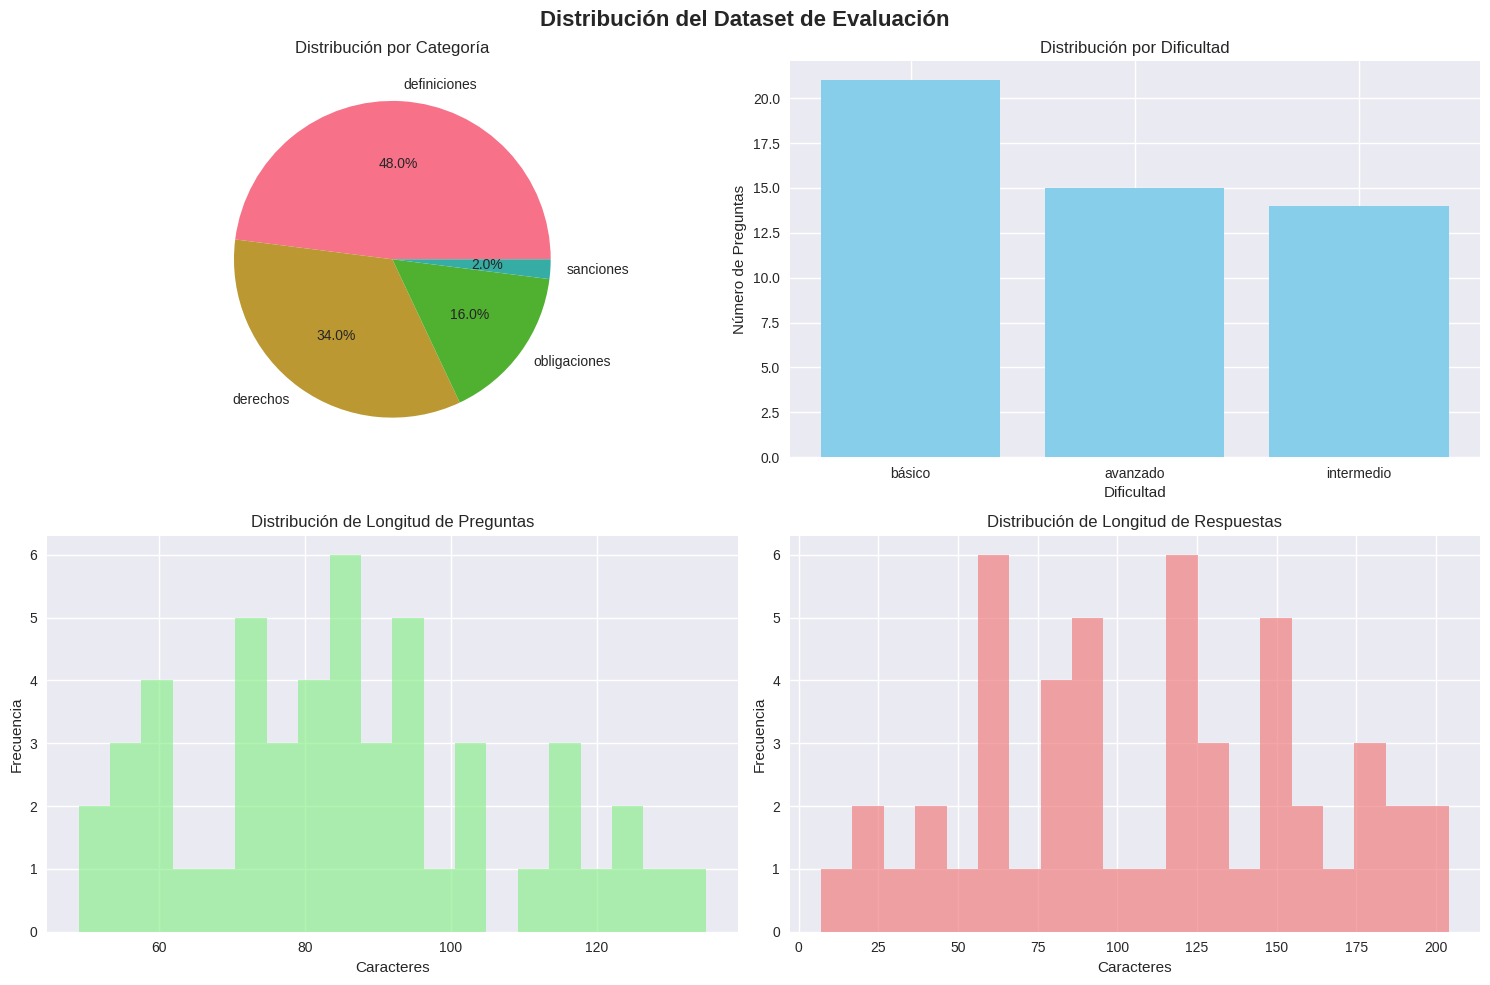


 Estadísticas detalladas:
  - Longitud promedio de preguntas: 86.1 caracteres
  - Longitud promedio de respuestas: 109.2 caracteres
  - Número promedio de artículos esperados: 1.0


In [24]:
# Ejecutar visualizaciones
visualize_dataset_distribution(df_ground_truth)

In [25]:
show_sample_questions(df_ground_truth)


 Ejemplos de preguntas del dataset:

 Pregunta 1:
   Pregunta: ¿Cuál es el objeto del código mencionado en el artículo?
   Respuesta esperada: Establecer normas para regular las relaciones entre trabajadores y empleadores en la prestación subordinada y retribuida de la actividad laboral.
   Artículos relevantes: [1]
   Categoría: definiciones
   Dificultad: básico
--------------------------------------------------------------------------------

 Pregunta 2:
   Pregunta: ¿Qué tipos de trabajadores están sujetos a las disposiciones del código?
   Respuesta esperada: Los trabajadores intelectuales, manuales o técnicos en relación de dependencia, los profesores de institutos de enseñanza privada y quienes ejerzan la práctica deportiva profesional.
   Artículos relevantes: [2]
   Categoría: definiciones
   Dificultad: avanzado
--------------------------------------------------------------------------------

 Pregunta 3:
   Pregunta: ¿Qué tipo de acuerdos son nulos en relación a los derecho

# 3. Configuración del Entorno

## Configuración de Servicios y Modelos

Esta sección establece la conexión con todos los servicios necesarios para la evaluación del pipeline RAG:

### Servicios a Configurar

1. **Qdrant**: Base de datos vectorial para retrieval
2. **Modelos de Embedding**: Para representación de texto
3. **Modelos de Re-ranking**: Para mejorar relevancia de documentos
4. **LLM**: Para generación y evaluación de respuestas
5. **Sistema de Métricas**: Para cálculo de métricas de evaluación


In [26]:
class QdrantManager:

    def __init__(self, url):
        """Inicializa el cliente de Qdrant"""
        self.client = QdrantClient(url=url)
        print(f"Cliente Qdrant inicializado en {url}")

    def create_collection(self, collection_name, vector_size):
        """
        Crea una colección en Qdrant. 
        Si ya existe, la elimina antes de crearla.
        """
        if self.client.collection_exists(collection_name):
            print(f"Colección '{collection_name}' ya existe. Eliminando...")
            self.client.delete_collection(collection_name)

        self.client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(
                size=vector_size,
                distance=Distance.COSINE
            ),
            timeout=60
        )
        print(f"Colección '{collection_name}' creada con dimensión {vector_size}")

    def insert_documents(
        self,
        collection_name,
        texts,
        embeddings,
        articles_metadata
    ):
        """
        Inserta documentos en Qdrant con metadatos enriquecidos
        """
        try:
            points = []
            for i, (text, embedding) in enumerate(zip(texts, embeddings)):
                payload = {
                    "text": text,
                    "text_length": len(text),
                    "source": "codigo_trabajo_paraguay",
                }

                # Agregar metadatos adicionales
                article = articles_metadata[i]
                payload.update({
                    "libro": article.get("libro"),
                    "titulo": article.get("titulo"),
                    "capitulo": article.get("capitulo"),
                    "capitulo_descripcion": article.get("capitulo_descripcion"),
                    "articulo_numero": article.get("articulo_numero"),
                    "articulo": article.get("articulo")
                })

                point = PointStruct(
                    id=i,
                    vector=embedding.tolist(),
                    payload=payload
                )
                points.append(point)

            # Insertar en lote
            self.client.upsert(collection_name=collection_name, points=points)
            print(f"{len(points)} documentos insertados en '{collection_name}'")
            return True

        except Exception as e:
            print(f"Error insertando documentos en '{collection_name}': {e}")
            return False

    def search(self, collection_name, query_embedding, limit = 3):
        """
        Busca puntos en Qdrant dados un embedding de consulta
        """
        try:
            results = self.client.query_points(
                collection_name=collection_name,
                query=query_embedding,
                limit=limit
            ).points
            return results
        except Exception as e:
            print(f"Error en búsqueda de '{collection_name}': {e}")
            return None

    def display_results(self, search_results, show_metadata = True, max_text_len = 120):
        """
        Muestra resultados de búsqueda en Qdrant con metadatos enriquecidos
        """
        if not search_results:
            print("No se encontraron resultados")
            return

        print("\nResultados de búsqueda en Qdrant")
        print("=" * 80)

        for i, result in enumerate(search_results, start=1):
            payload = result.payload or {}
            score = result.score

            text_preview = payload.get("articulo", "").strip()
            if len(text_preview) > max_text_len:
                text_preview = text_preview[:max_text_len] + "..."

            print(f"\n{i}. Similitud: {score:.3f}")
            print(f"\t {text_preview}")

            if show_metadata:
                print(f"\t Libro: {payload.get('libro')}")
                print(f"\t Título: {payload.get('titulo')}")
                print(f"\t Capítulo: {payload.get('capitulo')} - {payload.get('capitulo_descripcion')}")
                print(f"\t Artículo Nº: {payload.get('articulo_numero')}")

In [27]:
# Configura la conexión con Qdrant
def setup_qdrant() -> bool:
    try:
        print("\n\nConfigurando Qdrant...")
        qdrant_manager = QdrantManager(url=QDRANT_CONFIG['url'])
        
        return qdrant_manager
    except Exception as e:
        print(f"Error configurando Qdrant: {e}")

In [28]:
# Carga todos los modelos de embeddings definidos en la configuración
def setup_embedding_models() -> Dict[str, dict]:
    embedding_models = {}
    try:
        print("\n\nCargando modelos de embedding...")
        
        for name, config in EMBEDDING_MODELS.items():
            try:
                print(f"  - Cargando {name}...")
                model = SentenceTransformer(config['model_name'], trust_remote_code=True)
                embedding_models[name] = {
                    'model': model,
                    'config': config
                }
                print(f"{name} cargado (dimensión: {config['dimension']})")
            except Exception as e:
                print(f"Error cargando {name}: {e}")
        
        print(f"{len(embedding_models)} modelos de embedding cargados")
    except Exception as e:
        print(f"Error configurando modelos de embedding: {e}")
    
    return embedding_models

In [29]:
# Carga todos los modelos de re-ranking configurados
def setup_reranking_models() -> Dict[str, dict]:
    reranking_models = {}
    try:
        print("\n\nCargando modelos de re-ranking...")
        
        for name, config in RERANKING_MODELS.items():
            try:
                print(f"  - Cargando {name}...")
                model = CrossEncoder(config['model_name'], trust_remote_code=True)
                reranking_models[name] = {
                    'model': model,
                    'config': config
                }
                print(f"{name} cargado")
            except Exception as e:
                print(f"Error cargando {name}: {e}")
        
        print(f"{len(reranking_models)} modelos de re-ranking cargados")
    except Exception as e:
        print(f"Error configurando modelos de re-ranking: {e}")
    
    return reranking_models

In [30]:
# Configura el pipeline de LLM (OpenAI o fallback local)
def setup_llm_pipeline() -> Dict[str, str]:
    llm_pipeline = {}
    try:
        print("\n\nConfigurando LLM pipeline...")
        llm_pipeline = {
            'provider': LLM_CONFIG['provider'],
            'model': LLM_CONFIG['model']
        }
        print("LLM pipeline configurado...")
    except Exception as e:
        print(f"Error configurando LLM: {e}")
    
    return llm_pipeline

In [31]:
# Configura el sistema de métricas de evaluación
def setup_evaluation_metrics() -> Dict[str, dict]:
    evaluation_metrics = {}
    try:
        print("\n\nConfigurando sistema de métricas...")
        evaluation_metrics = {
            'retrieval_metrics': RETRIEVAL_METRICS,
            'llm_criteria': LLM_EVALUATION_CRITERIA,
            'custom_metrics': {}
        }
        print("Sistema de métricas configurado")
    except Exception as e:
        print(f"Error configurando métricas: {e}")
    return evaluation_metrics

In [32]:
# Inicializa todos los servicios y muestra un resumen
def initialize_all() -> Dict[str, bool]:
    print("Inicializando entorno completo...")
    print("=" * 50)

    results = {
        'qdrant': setup_qdrant(),
        'embedding_models': setup_embedding_models(),
        'reranking_models': setup_reranking_models(),
        'llm_pipeline': setup_llm_pipeline(),
        'evaluation_metrics': setup_evaluation_metrics()
    }
    
    return results

In [33]:
initialized_services = initialize_all()

Inicializando entorno completo...


Configurando Qdrant...
Cliente Qdrant inicializado en http://localhost:6333


Cargando modelos de embedding...
  - Cargando multilingual-e5-small...
multilingual-e5-small cargado (dimensión: 384)
  - Cargando gte-multilingual-base...


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


gte-multilingual-base cargado (dimensión: 768)
  - Cargando multilingual-e5-base...
multilingual-e5-base cargado (dimensión: 768)
  - Cargando paraphrase-multilingual-MiniLM-L12-v2...
paraphrase-multilingual-MiniLM-L12-v2 cargado (dimensión: 384)
4 modelos de embedding cargados


Cargando modelos de re-ranking...
  - Cargando mmarco-mMiniLMv2-L12-H384-v1...
mmarco-mMiniLMv2-L12-H384-v1 cargado
  - Cargando gte-multilingual-reranker-base...
gte-multilingual-reranker-base cargado
  - Cargando mxbai-rerank-base-v2...


Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at mixedbread-ai/mxbai-rerank-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


mxbai-rerank-base-v2 cargado
3 modelos de re-ranking cargados


Configurando LLM pipeline...
LLM pipeline configurado...


Configurando sistema de métricas...
Sistema de métricas configurado


In [34]:
# Crea colecciones en Qdrant por cada modelo y agrega los artículos de `law_data` con sus embeddings y metadatos
def insert_law_data_in_collections(models_dict, qdrant_manager, law_data):

    for model_key, model_info in models_dict.items():
        # Extraer config y modelo
        model = model_info['model']
        config = model_info['config']
        model_name = config['model_name'].split("/")[-1]
        dimension = config['dimension']

        # Crear colección en Qdrant
        collection_name = f"test_collection_{model_name}"
        qdrant_manager.create_collection(collection_name, vector_size=dimension)

        # Extraer textos de law_data
        texts = [f"{art['capitulo_descripcion']}: {art['articulo']}" for art in law_data['articulos']]
        
        # Generar embeddings con el modelo actual
        embeddings = model.encode(texts)

        # Insertar en Qdrant
        success = qdrant_manager.insert_documents(
            collection_name=collection_name,
            texts=texts,
            embeddings=embeddings,
            articles_metadata=law_data['articulos']
        )

In [35]:
insert_law_data_in_collections(initialized_services['embedding_models'], initialized_services['qdrant'], law_data)

Colección 'test_collection_multilingual-e5-small' ya existe. Eliminando...
Colección 'test_collection_multilingual-e5-small' creada con dimensión 384
410 documentos insertados en 'test_collection_multilingual-e5-small'
Colección 'test_collection_gte-multilingual-base' ya existe. Eliminando...
Colección 'test_collection_gte-multilingual-base' creada con dimensión 768
410 documentos insertados en 'test_collection_gte-multilingual-base'
Colección 'test_collection_multilingual-e5-base' ya existe. Eliminando...
Colección 'test_collection_multilingual-e5-base' creada con dimensión 768
410 documentos insertados en 'test_collection_multilingual-e5-base'
Colección 'test_collection_paraphrase-multilingual-MiniLM-L12-v2' ya existe. Eliminando...
Colección 'test_collection_paraphrase-multilingual-MiniLM-L12-v2' creada con dimensión 384
410 documentos insertados en 'test_collection_paraphrase-multilingual-MiniLM-L12-v2'


# 4. Evaluación de Retrievers (Embeddings + Qdrant)

## Objetivo de la Evaluación

Esta sección evalúa la calidad del sistema de recuperación de documentos usando diferentes modelos de embeddings y Qdrant. Se miden métricas objetivas para determinar qué modelo de embedding funciona mejor para el dominio del derecho laboral paraguayo.

### Métricas de Evaluación

- **Recall@k**: Proporción de documentos relevantes recuperados en los top-k
- **Precision@k**: Proporción de documentos relevantes entre los top-k recuperados
- **nDCG@k**: Normalized Discounted Cumulative Gain - considera el ranking
- **MRR**: Mean Reciprocal Rank - posición del primer documento relevante
- **Hit Rate@k**: Proporción de consultas que tienen al menos un documento relevante en top-k

### Proceso de Evaluación

1. **Generación de embeddings** para cada pregunta del dataset
2. **Búsqueda en Qdrant** usando diferentes modelos de embedding
3. **Cálculo de métricas** comparando con documentos esperados
4. **Análisis comparativo** entre modelos
5. **Visualización de resultados** para identificar patrones

### Modelos Evaluados

* [**multilingual-e5-small**](https://huggingface.co/intfloat/multilingual-e5-small): Multilingüe · Small · Rápido 
* [**gte-multilingual-base**](https://huggingface.co/Alibaba-NLP/gte-multilingual-base): Multilingüe · Large · Alto rendimiento 
* [**multilingual-e5-base**](https://huggingface.co/intfloat/multilingual-e5-base): Multilingüe · Base · Robusto 
* [**paraphrase-multilingual-MiniLM-L12-v2**](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2): Multilingüe · Ligero · Rápido

In [36]:
# Funciones de búsqueda en Qdrant
def search_documents(qdrant_client, models_dict, 
                     query: str):
    try:
        model = models_dict['model']
        config = models_dict['config']
        model_name = config['model_name'].split("/")[-1]
        
        # Embedding de la consulta
        query_embedding = model.encode([query])[0].tolist()
        
        # Buscar en Qdrant
        search_results = qdrant_client.search(
            collection_name=f"test_collection_{model_name}",
            query_embedding=query_embedding,
            limit=QDRANT_CONFIG['top_k']
        )
        
        return [
            {"id": result.id, "score": result.score, "payload": result.payload}
            for result in search_results
        ]
    except Exception as e:
        print(f"Error en búsqueda con {model_name}: {e}")
        return []

In [37]:
# Funciones de métricas
def calculate_recall_at_k(retrieved_ids, expected_ids, k):
    if not expected_ids:
        return 0.0
    retrieved_k = retrieved_ids[:k]
    num_relevant = sum(1 for doc_id in retrieved_k if doc_id in expected_ids)
    return num_relevant / len(expected_ids)

# ======================================================
# NOTE: We are NOT using precision_at_k in this evaluation
# because the ground-truth dataset contains only 1 relevant document per query.
# If the dataset had more than 1 relevant document per query, 
# precision_at_k could be included as an additional metric.
# ======================================================
def calculate_precision_at_k(retrieved_ids, expected_ids, k):
    if k == 0:
        return 0.0
    retrieved_k = retrieved_ids[:k]
    num_relevant = sum(1 for doc_id in retrieved_k if doc_id in expected_ids)
    return num_relevant / k

def calculate_ndcg_at_k(retrieved_ids, expected_ids, k):
    if not expected_ids or k == 0:
        return 0.0
    relevance = [1 if doc_id in expected_ids else 0 for doc_id in retrieved_ids[:k]]
    dcg = sum(rel / np.log2(i + 2) for i, rel in enumerate(relevance))
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(expected_ids), k)))
    return float(dcg / idcg) if idcg > 0 else 0.0

def calculate_mrr(retrieved_ids, expected_ids):
    if not expected_ids:
        return 0.0
    for i, doc_id in enumerate(retrieved_ids):
        if doc_id in expected_ids:
            return 1.0 / (i + 1)
    return 0.0

def calculate_hit_rate_at_k(retrieved_ids, expected_ids, k):
    if not expected_ids:
        return 0.0
    retrieved_k = retrieved_ids[:k]
    return 1.0 if any(doc_id in expected_ids for doc_id in retrieved_k) else 0

In [38]:
# Función de evaluación principal
def evaluate_single_query(qdrant_client, dict_embedding_model,
                          query, expected_art_num,
                          retrieval_metrics):
    """
    Evalúa una sola consulta con un modelo de embedding
    """
    documents = search_documents(qdrant_client, dict_embedding_model, query)
    retrieved_art_num = [doc['payload']['articulo_numero'] for doc in documents]

    metrics = {}

    # Recall@k
    for k in retrieval_metrics['recall_at_k']:
        metrics[f"recall_at_{k}"] = calculate_recall_at_k(retrieved_art_num, expected_art_num, k)

    # Precision@k
    #for k in retrieval_metrics['precision_at_k']:
    #    metrics[f"precision_at_{k}"] = calculate_precision_at_k(retrieved_art_num, expected_art_num, k)

    # nDCG@k
    for k in retrieval_metrics['ndcg_at_k']:
        metrics[f"ndcg_at_{k}"] = calculate_ndcg_at_k(retrieved_art_num, expected_art_num, k)

    # Hit Rate@k
    for k in retrieval_metrics['hit_rate_at_k']:
        metrics[f"hit_rate_at_{k}"] = calculate_hit_rate_at_k(retrieved_art_num, expected_art_num, k)
    
    # MRR
    if retrieval_metrics.get("mrr"):
        metrics["mrr"] = calculate_mrr(retrieved_art_num, expected_art_num)

    # Extra info
    metrics["total_retrieved"] = len(retrieved_art_num)
    metrics["total_expected"] = len(expected_art_num)
    metrics["retrieved_arts_num"] = retrieved_art_num

    return metrics

In [39]:
def print_k_metrics(query_metrics, ks=[1, 3, 5, 10]):
    for k in ks:
        print(
            f"@{k} -> "
            f"Recall: {query_metrics.get(f'recall_at_{k}', 0):.3f}, "
            #f"Precision: {query_metrics.get(f'precision_at_{k}', 0):.3f}, "
            f"nDCG: {query_metrics.get(f'ndcg_at_{k}', 0):.3f}, "
            f"HitRate: {query_metrics.get(f'hit_rate_at_{k}', 0):.3f}"
        )
    print(f"MRR -> {query_metrics['mrr']:.3f}\n\n")

In [40]:
def print_model_summary(model_key, aggregated, ks=[1, 3, 5, 10]):
    print(f"Resumen de {model_key}:")

    for k in ks:
        print(
            f"@{k} -> "
            f"Recall promedio: {aggregated[f'recall_at_{k}']['mean']:.3f}, "
            #f"Precision promedio: {aggregated[f'precision_at_{k}']['mean']:.3f}, "
            f"nDCG promedio: {aggregated[f'ndcg_at_{k}']['mean']:.3f}, "
            f"HitRate promedio: {aggregated[f'hit_rate_at_{k}']['mean']:.3f}"
        )
    print(f"MRR promedio: {aggregated['mrr']['mean']:.3f}\n\n")

In [41]:
def calculate_aggregated_metrics(query_results):
    """
    Calcula métricas agregadas (promedio, desviación estándar) de los resultados de consultas
    """
    if not query_results:
        return {}

    # Obtener todas las métricas disponibles
    metric_names = [key for key in query_results[0].keys() 
                   if key not in ['query', 'expected_articles', 'query_id', 'retrieved_ids', 
                                 'total_retrieved', 'total_expected']]
    aggregated = {}
    
    for metric_name in metric_names:
        values = [result[metric_name] for result in query_results if metric_name in result]
        
        if values:
            aggregated[metric_name] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values)),
                'median': float(np.median(values))
            }
    
    return aggregated

In [42]:
# Función para ejecutar evaluación completa de retrievers
def evaluate_all_retrievers(dataset, qdrant_client, embedding_models, retrieval_metrics, show_per_query=False):
    """
    Evalúa todos los modelos de embedding con el dataset ground truth
    """
    print("Iniciando evaluación completa de retrievers...")
    print(f"Evaluando {len(dataset)} preguntas con {len(embedding_models)} modelos")
    print("=" * 60)
    
    all_results = {}
    
    for model_key, dict_embedding_model in embedding_models.items():
        print(f"\nEvaluando modelo: {model_key}")
        print("-" * 40)
        
        model_results = {
            'model_name': model_key,
            'query_results': [],
            'aggregated_metrics': {}
        }
        
        # Evaluar cada pregunta
        for idx, row in dataset.iterrows():
            query = row['question']
            expected_articles = row['expected_articles']

            if show_per_query:
                print(f"Pregunta {idx + 1}/{len(dataset)}: {query[:50]}...")
            
            try:
                # Evaluar consulta
                query_metrics = evaluate_single_query(
                    qdrant_client=qdrant_client,
                    dict_embedding_model=dict_embedding_model,
                    query=query,
                    expected_art_num=expected_articles,
                    retrieval_metrics=retrieval_metrics
                )
                
                # Agregar información de la consulta
                query_metrics['query'] = query
                query_metrics['expected_articles'] = expected_articles
                query_metrics['query_id'] = idx
                
                model_results['query_results'].append(query_metrics)
                

                # Extraer todas las k de las métricas que son listas
                all_ks = {k for v in retrieval_metrics.values() if isinstance(v, list) for k in v}
                all_ks = sorted(list(all_ks))

                if show_per_query:
                    # Mostrar métricas
                    print_k_metrics(query_metrics, ks=all_ks)
                
            except Exception as e:
                print(f"Error en pregunta {idx + 1}: {e}")
                continue
        
        # Calcular métricas agregadas
        if model_results['query_results']:
            print(f"\nCalculando métricas agregadas para {model_key}...")
            aggregated = calculate_aggregated_metrics(model_results['query_results'])
            model_results['aggregated_metrics'] = aggregated
            # Mostrar resumen
            print_model_summary(model_key, aggregated, ks=all_ks)
                 
        all_results[model_key] = model_results
    
    print("\n" + "=" * 60)
    print("Evaluación de retrievers completada")
    
    return all_results

In [43]:
# Se puede mostrar el detalle por pregunta agregando show_per_query=True como ultimo argumento del metodo
all_results = evaluate_all_retrievers(df_ground_truth, 
                                      initialized_services['qdrant'],
                                      initialized_services['embedding_models'], 
                                      initialized_services['evaluation_metrics']['retrieval_metrics']
                                     )

Iniciando evaluación completa de retrievers...
Evaluando 50 preguntas con 4 modelos

Evaluando modelo: multilingual-e5-small
----------------------------------------

Calculando métricas agregadas para multilingual-e5-small...
Resumen de multilingual-e5-small:
@1 -> Recall promedio: 0.620, nDCG promedio: 0.620, HitRate promedio: 0.620
@3 -> Recall promedio: 0.800, nDCG promedio: 0.726, HitRate promedio: 0.800
@5 -> Recall promedio: 0.840, nDCG promedio: 0.742, HitRate promedio: 0.840
@10 -> Recall promedio: 0.880, nDCG promedio: 0.756, HitRate promedio: 0.880
MRR promedio: 0.715



Evaluando modelo: gte-multilingual-base
----------------------------------------

Calculando métricas agregadas para gte-multilingual-base...
Resumen de gte-multilingual-base:
@1 -> Recall promedio: 0.760, nDCG promedio: 0.760, HitRate promedio: 0.760
@3 -> Recall promedio: 0.860, nDCG promedio: 0.820, HitRate promedio: 0.860
@5 -> Recall promedio: 0.920, nDCG promedio: 0.845, HitRate promedio: 0.920
@10 -> 

In [44]:
# Convertir el resultado en DataFrame
all_rows = []

for model_key, model_data in all_results.items():
    model_name = model_data['model_name']
    for query_metrics in model_data['query_results']:
        # Agregar el nombre del modelo a cada diccionario de métricas
        row = query_metrics.copy()
        row['model_name'] = model_name
        all_rows.append(row)

# Crear DataFrame
df_retriever_eval = pd.DataFrame(all_rows)

basic_cols = [
    'model_name', 'query_id', 'query', 'expected_articles', 
    'total_expected', 'retrieved_arts_num', 'total_retrieved'
]

metric_cols = [col for col in df_retriever_eval.columns if col not in basic_cols]

df_retriever_eval = df_retriever_eval[basic_cols + metric_cols]

# Mostrar primeras filas
df_retriever_eval.head(5)

,model_name,query_id,query,expected_articles,total_expected,retrieved_arts_num,total_retrieved,recall_at_1,recall_at_3,recall_at_5,recall_at_10,ndcg_at_1,ndcg_at_3,ndcg_at_5,ndcg_at_10,hit_rate_at_1,hit_rate_at_3,hit_rate_at_5,hit_rate_at_10,mrr
0,multilingual-e5-small,0,¿Cuál es el objeto del código mencionado en el...,[1],1,"[1, 5, 2, 4, 6, 407, 347, 206, 23, 47]",10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,multilingual-e5-small,1,¿Qué tipos de trabajadores están sujetos a las...,[2],1,"[2, 147, 5, 1, 216, 47, 117, 206, 103, 4]",10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,multilingual-e5-small,2,¿Qué tipo de acuerdos son nulos en relación a ...,[3],1,"[302, 40, 41, 54, 369, 67, 4, 360, 328, 47]",10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,multilingual-e5-small,3,¿Qué ocurre con los contratos o reglamentos qu...,[4],1,"[4, 64, 47, 345, 355, 5, 7, 302, 65, 112]",10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,multilingual-e5-small,4,¿Qué se establece sobre las garantías y derech...,[5],1,"[5, 8, 1, 64, 3, 4, 2, 47, 303, 9]",10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [45]:
{k for v in RETRIEVAL_METRICS.values() if isinstance(v, list) for k in v}

{1, 3, 5, 10}

In [46]:
# Visualización de resultados de retrievers
def visualize_retrieval_results(retrieval_results, k):
    """
    Visualiza los resultados de evaluación de retrievers
    """
    if not retrieval_results:
        print("No hay resultados para visualizar")
        return
    
    # Preparar datos para visualización
    models = list(retrieval_results.keys())
    metrics_to_plot = [
        f'recall_at_{k}', 
        #f'precision_at_{k}', 
        f'ndcg_at_{k}', 
        f'hit_rate_at_{k}', 
        'mrr'
    ]
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Comparación de Modelos de Embedding - Métricas de Retrieval Promedio - k={k}', 
                 fontsize=16, fontweight='bold')
    
    # Colores para cada modelo
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    for idx, metric in enumerate(metrics_to_plot):
        row = idx // 2
        col = idx % 2
        
        # Extraer datos para la métrica
        model_names = []
        mean_values = []
        std_values = []
        
        for model_name in models:
            if metric in retrieval_results[model_name]['aggregated_metrics']:
                model_names.append(model_name)
                mean_values.append(retrieval_results[model_name]['aggregated_metrics'][metric]['mean'])
                std_values.append(retrieval_results[model_name]['aggregated_metrics'][metric]['std'])
        
        if model_names:
            # Crear gráfico de barras con barras de error
            bars = axes[row, col].bar(model_names,
                                      mean_values, 
                                      yerr=std_values,
                                      color=colors[:len(model_names)], 
                                      alpha=0.8, 
                                      capsize=2,
                                      ecolor='gray')
       
            axes[row, col].set_title(metric)
            axes[row, col].set_ylabel('Score')
            axes[row, col].set_ylim(0, 1)
            
            # Rotar etiquetas del eje x
            axes[row, col].tick_params(axis='x', rotation=45)
            
            # Agregar valores en las barras
            for bar, mean_val in zip(bars, mean_values):
                height = bar.get_height()
                axes[row, col].text(bar.get_x() + 0.01,   
                                    height + 0.03,   
                                    f'{mean_val:.3f}',    
                                    ha='left',            
                                    va='center',          
                                    fontsize=9)
    
    plt.tight_layout()
    plt.show()

In [47]:
print("\n===== Comparación de Modelos de Embedding - Métricas de Retrieval (promedio) =====\n")


===== Comparación de Modelos de Embedding - Métricas de Retrieval (promedio) =====



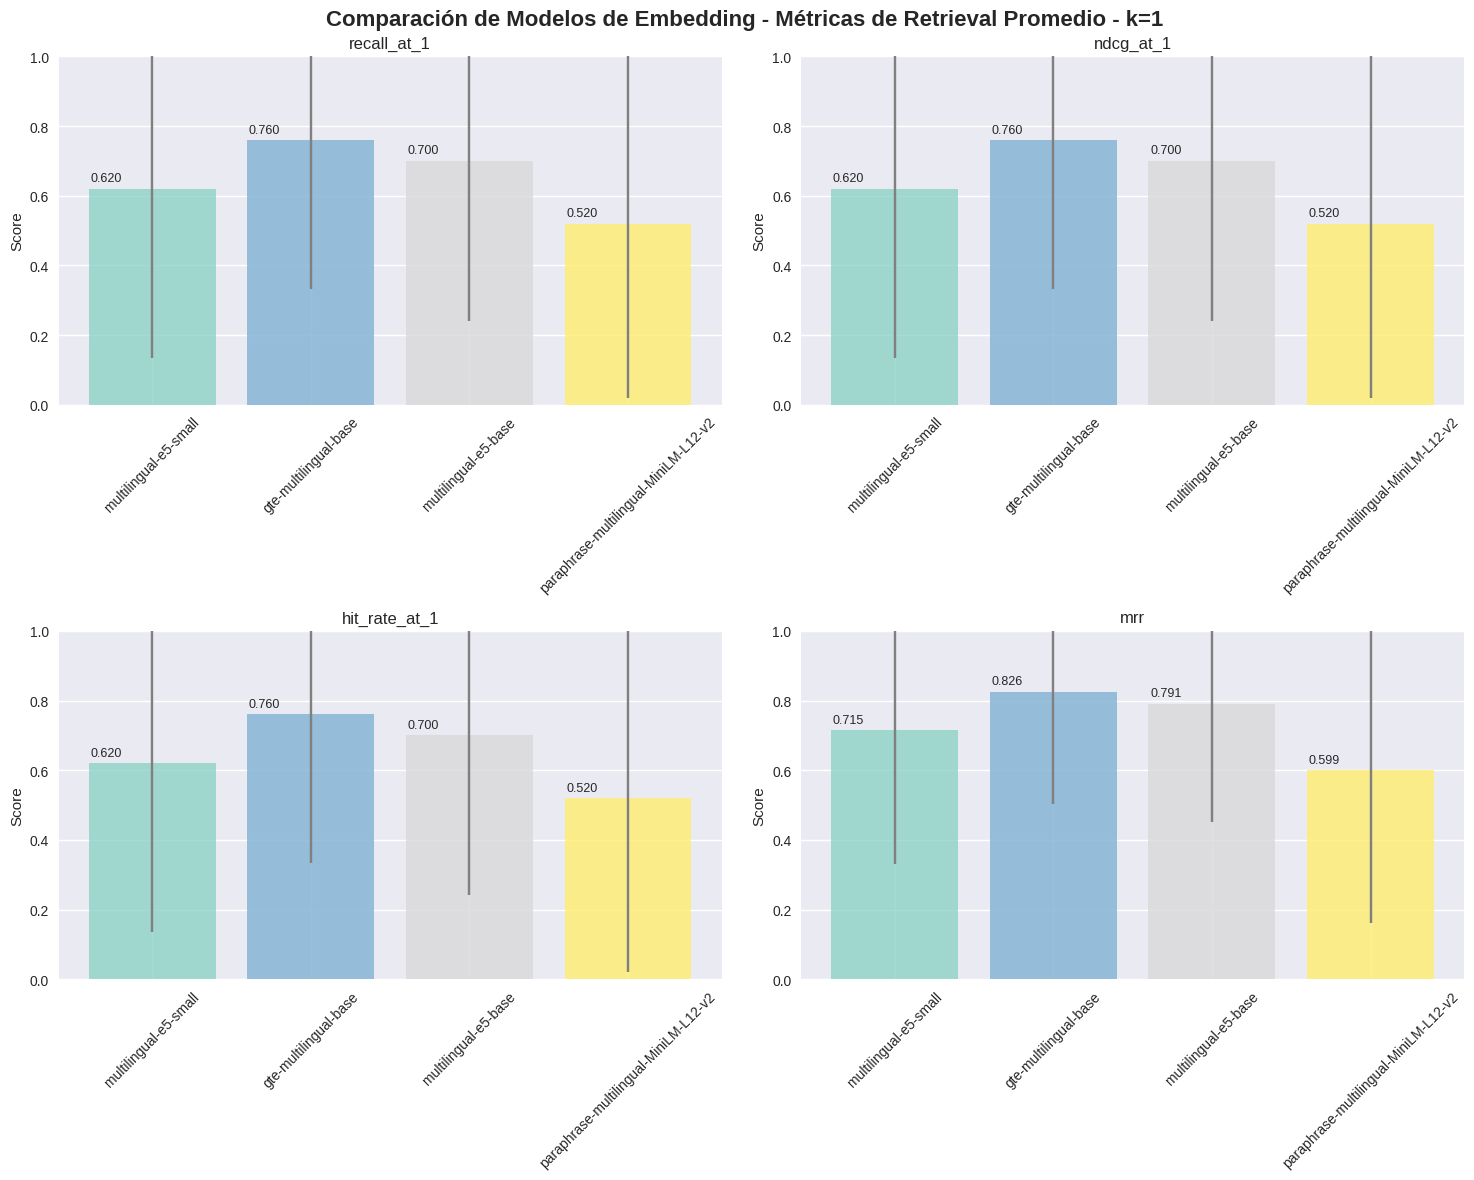

In [48]:
visualize_retrieval_results(all_results, k=1)

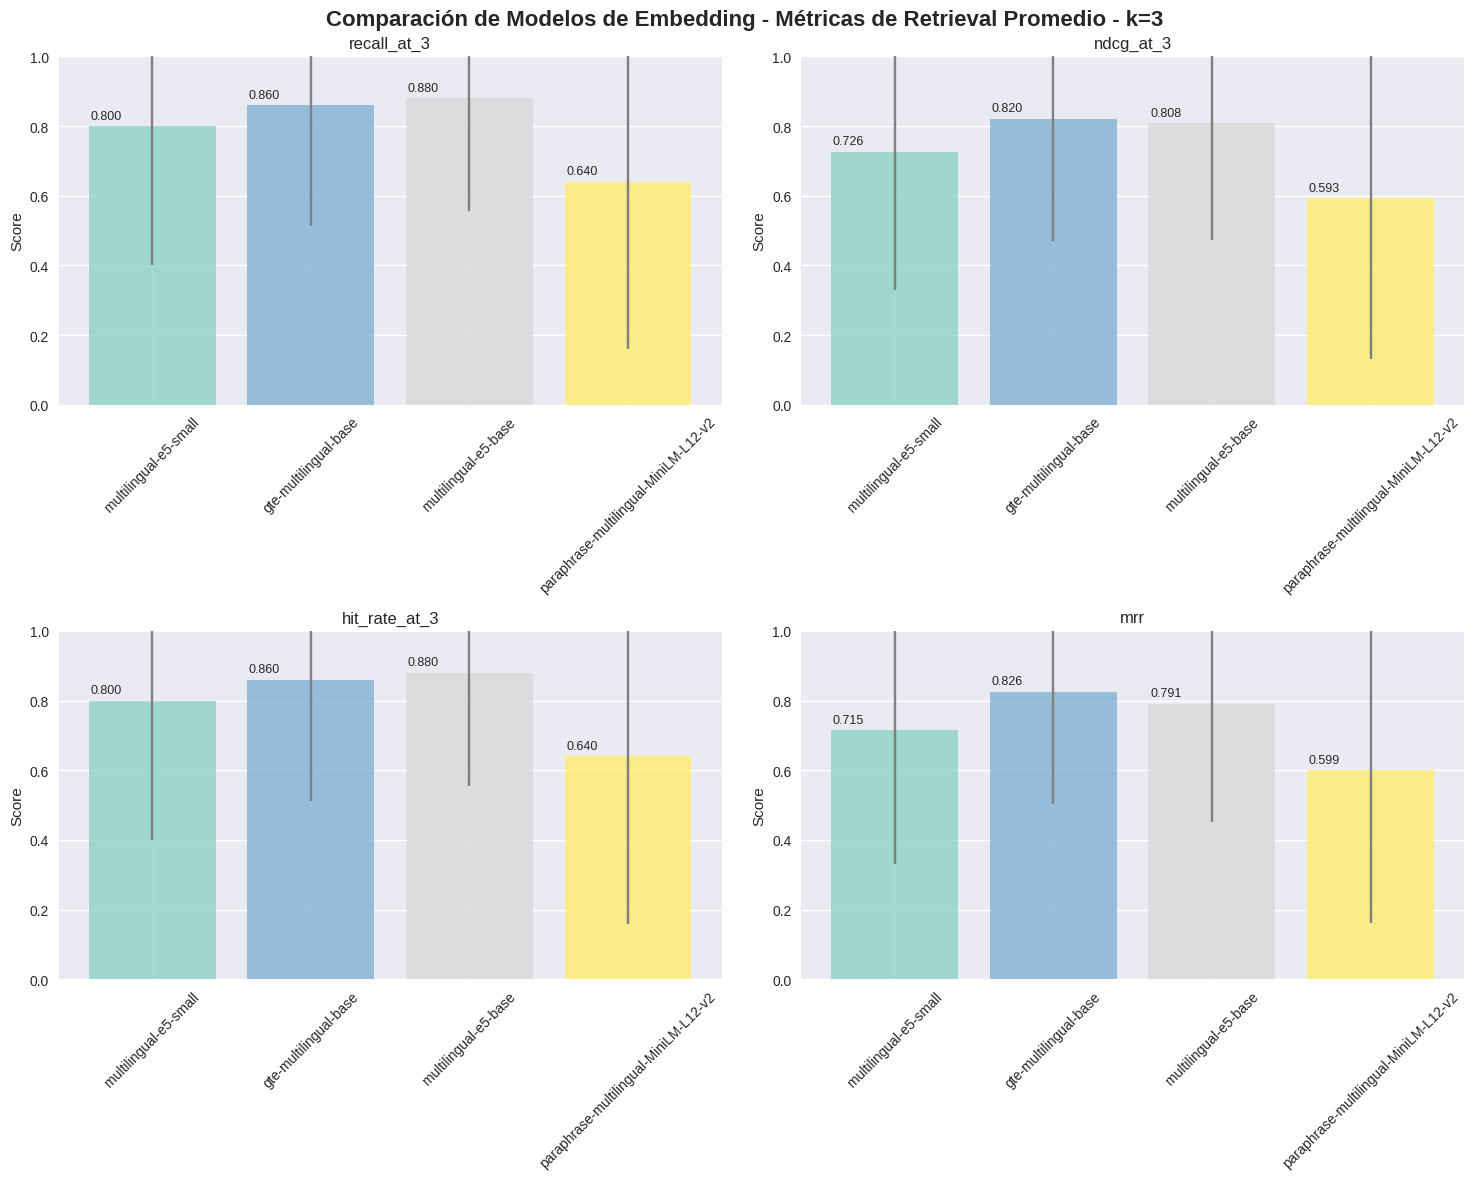

In [49]:
visualize_retrieval_results(all_results, k=3)

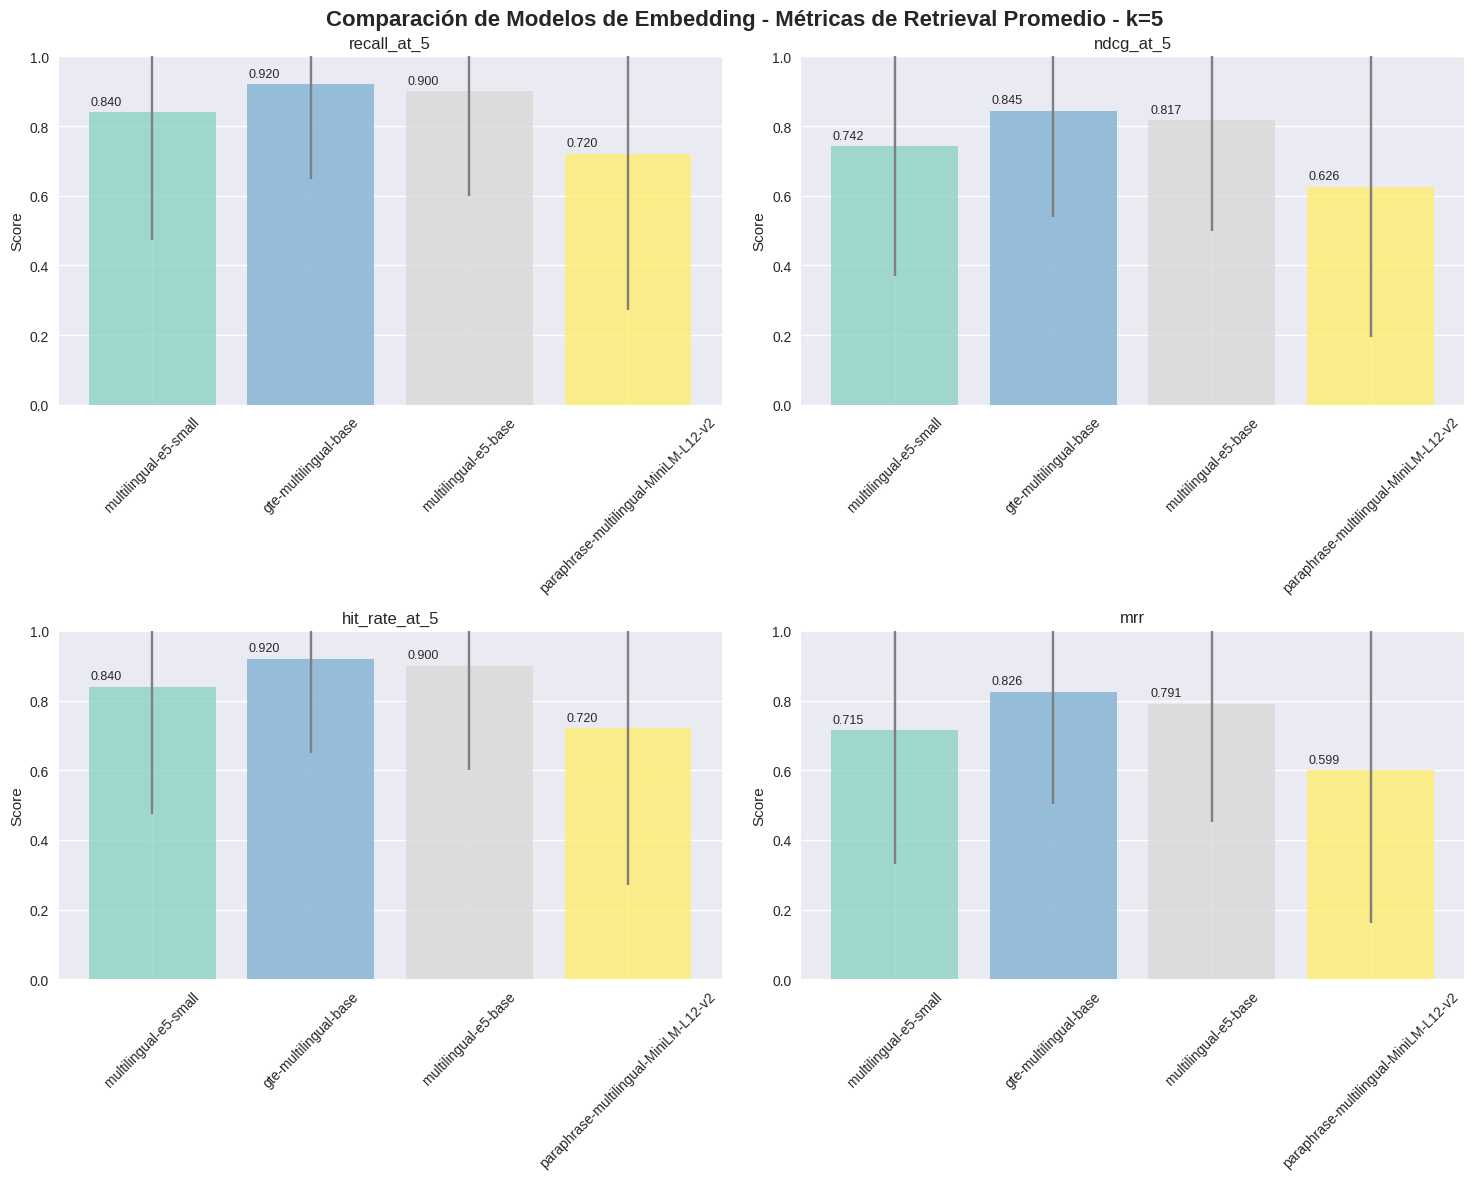

In [50]:
visualize_retrieval_results(all_results, k=5)

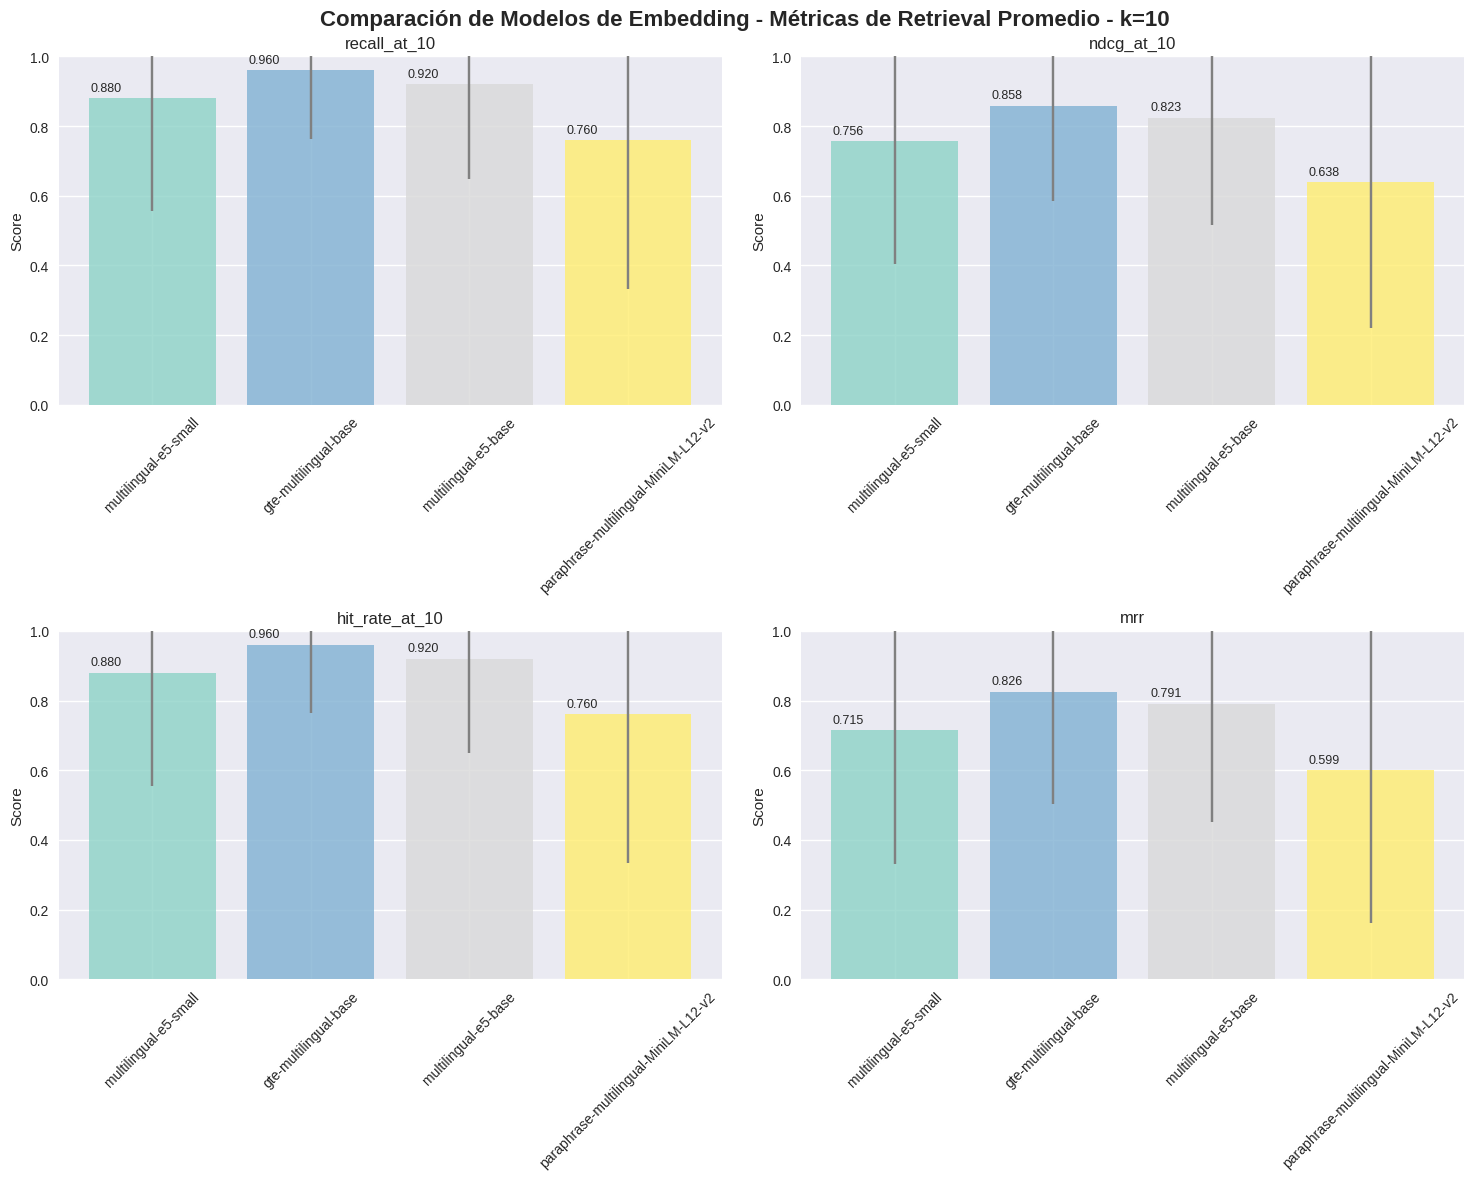

In [51]:
visualize_retrieval_results(all_results, k=10)

In [52]:
# Ver comparativa de métrica por modelo
def prepare_comparison_df(retrieval_results, k):
    """
    Genera un DataFrame comparativo con mean ± std de cada métrica por modelo.
    """
    models = list(retrieval_results.keys())
    metrics_to_plot = [
        f'recall_at_{k}', 
        #f'precision_at_{k}', 
        f'ndcg_at_{k}', 
        f'hit_rate_at_{k}', 
        'mrr'
    ]
    comparison_rows = []

    for model_name in models:
        aggregated = retrieval_results[model_name]['aggregated_metrics']
        row = {'Modelo': model_name}
        for metric in metrics_to_plot:
            if metric in aggregated:
                mean_val = aggregated[metric]['mean']
                std_val = aggregated[metric]['std']
                row[f'{metric}_promedio'] = f"{mean_val:.3f} ± {std_val:.3f}"
            else:
                row[metric] = "N/A"
        comparison_rows.append(row)

    comparison_df = pd.DataFrame(comparison_rows)
    # Ordenar columnas: Modelo primero
    cols = ['Modelo'] + [f'{metric}_promedio' for metric in metrics_to_plot if f'{metric}_promedio' in comparison_df.columns]
    comparison_df = comparison_df[cols]
    return comparison_df

In [53]:
print("\n===== Resumen Comparativo de Modelos de Embedding (promedio de métricas) =====\n")


===== Resumen Comparativo de Modelos de Embedding (promedio de métricas) =====



In [54]:
prepare_comparison_df(all_results, k=1)

,Modelo,recall_at_1_promedio,ndcg_at_1_promedio,hit_rate_at_1_promedio,mrr_promedio
0,multilingual-e5-small,0.620 ± 0.485,0.620 ± 0.485,0.620 ± 0.485,0.715 ± 0.385
1,gte-multilingual-base,0.760 ± 0.427,0.760 ± 0.427,0.760 ± 0.427,0.826 ± 0.322
2,multilingual-e5-base,0.700 ± 0.458,0.700 ± 0.458,0.700 ± 0.458,0.791 ± 0.340
3,paraphrase-multilingual-MiniLM-L12-v2,0.520 ± 0.500,0.520 ± 0.500,0.520 ± 0.500,0.599 ± 0.439


In [55]:
prepare_comparison_df(all_results, k=3)

,Modelo,recall_at_3_promedio,ndcg_at_3_promedio,hit_rate_at_3_promedio,mrr_promedio
0,multilingual-e5-small,0.800 ± 0.400,0.726 ± 0.395,0.800 ± 0.400,0.715 ± 0.385
1,gte-multilingual-base,0.860 ± 0.347,0.820 ± 0.352,0.860 ± 0.347,0.826 ± 0.322
2,multilingual-e5-base,0.880 ± 0.325,0.808 ± 0.335,0.880 ± 0.325,0.791 ± 0.340
3,paraphrase-multilingual-MiniLM-L12-v2,0.640 ± 0.480,0.593 ± 0.462,0.640 ± 0.480,0.599 ± 0.439


In [56]:
prepare_comparison_df(all_results, k=5)

,Modelo,recall_at_5_promedio,ndcg_at_5_promedio,hit_rate_at_5_promedio,mrr_promedio
0,multilingual-e5-small,0.840 ± 0.367,0.742 ± 0.373,0.840 ± 0.367,0.715 ± 0.385
1,gte-multilingual-base,0.920 ± 0.271,0.845 ± 0.305,0.920 ± 0.271,0.826 ± 0.322
2,multilingual-e5-base,0.900 ± 0.300,0.817 ± 0.319,0.900 ± 0.300,0.791 ± 0.340
3,paraphrase-multilingual-MiniLM-L12-v2,0.720 ± 0.449,0.626 ± 0.432,0.720 ± 0.449,0.599 ± 0.439


In [57]:
prepare_comparison_df(all_results, k=10)

,Modelo,recall_at_10_promedio,ndcg_at_10_promedio,hit_rate_at_10_promedio,mrr_promedio
0,multilingual-e5-small,0.880 ± 0.325,0.756 ± 0.351,0.880 ± 0.325,0.715 ± 0.385
1,gte-multilingual-base,0.960 ± 0.196,0.858 ± 0.273,0.960 ± 0.196,0.826 ± 0.322
2,multilingual-e5-base,0.920 ± 0.271,0.823 ± 0.306,0.920 ± 0.271,0.791 ± 0.340
3,paraphrase-multilingual-MiniLM-L12-v2,0.760 ± 0.427,0.638 ± 0.418,0.760 ± 0.427,0.599 ± 0.439


In [58]:
# Mostrar el mejor modelo por métrica
def best_models_retrieval(retrieval_results, k):
    """
    Devuelve un DataFrame con el mejor modelo por cada métrica para un valor k.
    """
    models = list(retrieval_results.keys())
    metrics_to_plot = [
        f'recall_at_{k}', 
        #f'precision_at_{k}', 
        f'ndcg_at_{k}', 
        f'hit_rate_at_{k}', 
        'mrr'
    ]
    
    rows = []
    for metric in metrics_to_plot:
        best_model = None
        best_score = -1
        for model_name in models:
            if metric in retrieval_results[model_name]['aggregated_metrics']:
                score = retrieval_results[model_name]['aggregated_metrics'][metric]['mean']
                if score > best_score:
                    best_score = score
                    best_model = model_name
        if best_model:
            rows.append({
                'Métrica': metric,
                'Mejor Modelo': best_model,
                'Score Promedio': best_score
            })
    
    return pd.DataFrame(rows)


In [59]:
print(f"\n===== Mejores Modelos (promedio de métricas) =====\n")


===== Mejores Modelos (promedio de métricas) =====



In [60]:
best_models_retrieval(all_results, k=1)

,Métrica,Mejor Modelo,Score Promedio
0,recall_at_1,gte-multilingual-base,0.760000
1,ndcg_at_1,gte-multilingual-base,0.760000
2,hit_rate_at_1,gte-multilingual-base,0.760000
3,mrr,gte-multilingual-base,0.825857


In [61]:
best_models_retrieval(all_results, k=3)

,Métrica,Mejor Modelo,Score Promedio
0,recall_at_3,multilingual-e5-base,0.880000
1,ndcg_at_3,gte-multilingual-base,0.820474
2,hit_rate_at_3,multilingual-e5-base,0.880000
3,mrr,gte-multilingual-base,0.825857


In [62]:
best_models_retrieval(all_results, k=5)

,Métrica,Mejor Modelo,Score Promedio
0,recall_at_5,gte-multilingual-base,0.920000
1,ndcg_at_5,gte-multilingual-base,0.844562
2,hit_rate_at_5,gte-multilingual-base,0.920000
3,mrr,gte-multilingual-base,0.825857


In [63]:
best_models_retrieval(all_results, k=10)

,Métrica,Mejor Modelo,Score Promedio
0,recall_at_10,gte-multilingual-base,0.960000
1,ndcg_at_10,gte-multilingual-base,0.858353
2,hit_rate_at_10,gte-multilingual-base,0.960000
3,mrr,gte-multilingual-base,0.825857


In [64]:
df_k1 = best_models_retrieval(all_results, k=1)
df_k3 = best_models_retrieval(all_results, k=3)
df_k5 = best_models_retrieval(all_results, k=5)
df_k10 = best_models_retrieval(all_results, k=10)

# Agregar columna con k
df_k1['k'] = 1
df_k3['k'] = 3
df_k5['k'] = 5
df_k10['k'] = 10

# Concatenar todos en un solo DataFrame
df_summary = pd.concat([df_k1, df_k3, df_k5, df_k10], ignore_index=True)

# Reordenar columnas
df_summary = df_summary[['k', 'Métrica', 'Mejor Modelo', 'Score Promedio']]

# Mostrar
df_summary

,k,Métrica,Mejor Modelo,Score Promedio
0,1,recall_at_1,gte-multilingual-base,0.760000
1,1,ndcg_at_1,gte-multilingual-base,0.760000
2,1,hit_rate_at_1,gte-multilingual-base,0.760000
3,1,mrr,gte-multilingual-base,0.825857
4,3,recall_at_3,multilingual-e5-base,0.880000
5,3,ndcg_at_3,gte-multilingual-base,0.820474
6,3,hit_rate_at_3,multilingual-e5-base,0.880000
7,3,mrr,gte-multilingual-base,0.825857
8,5,recall_at_5,gte-multilingual-base,0.920000
9,5,ndcg_at_5,gte-multilingual-base,0.844562


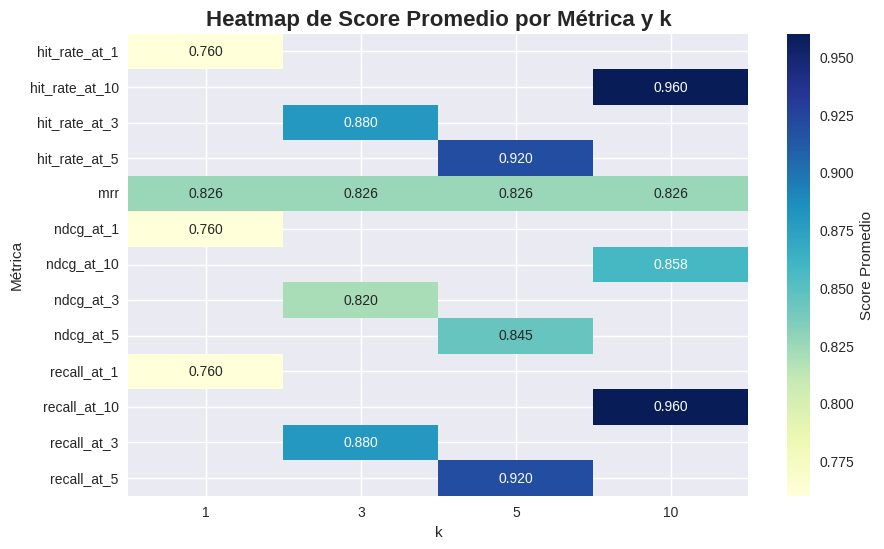

In [65]:
# Pivotar para tener métricas como filas, k como columnas, y Score Promedio como valores
heatmap_df = df_summary.pivot(index='Métrica', columns='k', values='Score Promedio')

# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Score Promedio'})

plt.title("Heatmap de Score Promedio por Métrica y k", fontsize=16, fontweight='bold')

plt.ylabel("Métrica")
plt.xlabel("k")
plt.yticks(rotation=0)

plt.show()

In [66]:
def analyze_models_embedding_full(
    df,
    strength_threshold=0.85,
    weakness_threshold=0.75,
    language="en",
    metric_weights=None
):
    """
    Full analysis of model performance:
    - Strengths, weaknesses, considerations (detailed per metric)
    - Weighted final score
    - Grouped by model and k
    """
    if metric_weights is None:
        #metric_weights = {
        #    "recall": 0.3,
        #    "precision": 0.3,
        #    "ndcg": 0.2,
        #    "mrr": 0.15,
        #    "hit_rate": 0.05
        #}
        metric_weights = {
            "precision": 0.3,
            "ndcg": 0.35,
            "mrr": 0.25,
            "hit_rate": 0.1
        }

    # Translation dictionary
    texts = {
        "en": {
            "strengths": "Strengths",
            "weaknesses": "Weaknesses",
            "considerations": "Considerations",
            "no_strengths": "No clear strengths detected.",
            "no_weaknesses": "No critical weaknesses detected.",
            "no_considerations": "No additional observations.",
            "high": "High",
            "low": "Low",
            "final_score": "Final Weighted Score",
            "recall_vs_precision_high": "Model favors retrieving more results (high coverage) but not all are relevant.",
            "recall_vs_precision_low": "Model is more precise but with lower coverage.",
            "ndcg_low": "Ranking quality is not optimal, this may affect user experience.",
            "mrr_high": "Model returns relevant results at the top of the ranking.",
            "mrr_low": "Relevant results appear lower in the ranking.",
            "hit_low": "Low probability of finding at least one relevant result in top-k."
        },
        "es": {
            "strengths": "Fortalezas",
            "weaknesses": "Debilidades",
            "considerations": "Consideraciones",
            "no_strengths": "No se detectaron fortalezas claras.",
            "no_weaknesses": "No se detectaron debilidades críticas.",
            "no_considerations": "Sin observaciones adicionales.",
            "high": "Alto",
            "low": "Bajo",
            "final_score": "Score Final Ponderado",
            "recall_vs_precision_high": "El modelo prioriza recuperar más resultados (alta cobertura) aunque no todos sean relevantes.",
            "recall_vs_precision_low": "El modelo es más preciso pero con menor cobertura.",
            "ndcg_low": "La calidad del ranking no es óptima, lo que puede afectar la experiencia del usuario.",
            "mrr_high": "El modelo devuelve resultados relevantes en las primeras posiciones.",
            "mrr_low": "Los resultados relevantes aparecen más abajo en la lista.",
            "hit_low": "Baja probabilidad de encontrar al menos un resultado relevante en el top-k."
        }
    }

    lang = texts.get(language, texts["en"])
    insights = {}

    # Normalize metrics
    df_norm = df.copy()
    for metric_type in metric_weights.keys():
        mask = df_norm["Métrica"].str.startswith(metric_type)
        if mask.any():
            scores = df_norm.loc[mask, "Score Promedio"]
            min_score, max_score = scores.min(), scores.max()
            if max_score > min_score:
                df_norm.loc[mask, "Score Normalizado"] = (scores - min_score) / (max_score - min_score)
            else:
                df_norm.loc[mask, "Score Normalizado"] = 1.0

    # Group by model
    for model, subset_model in df_norm.groupby("Mejor Modelo"):
        model_insights = {}

        # Group by k
        for k_value, subset_k in subset_model.groupby("k"):
            strengths = []
            weaknesses = []
            considerations = []

            # Weighted final score
            weighted_scores = []
            for _, row in subset_k.iterrows():
                metric = row["Métrica"]
                score_norm = row.get("Score Normalizado", row["Score Promedio"])
                for key in metric_weights:
                    if metric.startswith(key):
                        weighted_scores.append(score_norm * metric_weights[key])
                        break
            final_score = sum(weighted_scores)

            # Strengths and weaknesses
            for _, row in subset_k.iterrows():
                metric = row["Métrica"]
                score = row["Score Promedio"]
                if score >= strength_threshold:
                    strengths.append(f"{lang['high']} {metric} (score={score:.2f})")
                elif score <= weakness_threshold:
                    weaknesses.append(f"{lang['low']} {metric} (score={score:.2f})")

            # Detailed considerations
            recall_scores = subset_k[subset_k["Métrica"].str.startswith("recall_at")]["Score Promedio"]
            precision_scores = subset_k[subset_k["Métrica"].str.startswith("precision_at")]["Score Promedio"]
            if not recall_scores.empty and not precision_scores.empty:
                if recall_scores.mean() > precision_scores.mean():
                    considerations.append(lang["recall_vs_precision_high"])
                else:
                    considerations.append(lang["recall_vs_precision_low"])

            ndcg_scores = subset_k[subset_k["Métrica"].str.startswith("ndcg_at")]["Score Promedio"]
            if not ndcg_scores.empty and ndcg_scores.mean() < 0.5:
                considerations.append(lang["ndcg_low"])

            mrr_scores = subset_k[subset_k["Métrica"]=="mrr"]["Score Promedio"]
            if not mrr_scores.empty:
                if mrr_scores.mean() >= 0.6:
                    considerations.append(lang["mrr_high"])
                else:
                    considerations.append(lang["mrr_low"])

            hit_scores = subset_k[subset_k["Métrica"].str.startswith("hit_rate_at")]["Score Promedio"]
            if not hit_scores.empty and hit_scores.mean() < 0.5:
                considerations.append(lang["hit_low"])

            # Always include final score
            considerations.append(f"{lang['final_score']}: {final_score:.3f}")

            model_insights[k_value] = {
                lang["strengths"]: strengths if strengths else [lang["no_strengths"]],
                lang["weaknesses"]: weaknesses if weaknesses else [lang["no_weaknesses"]],
                lang["considerations"]: considerations
            }

        insights[model] = model_insights

    return insights


In [67]:
results_analyze_models_es = analyze_models_embedding_full(df_summary, language="es")
results_analyze_models_en = analyze_models_embedding_full(df_summary, language="en")

for model, ks in results_analyze_models_es.items():
    print(f"\nModelo: {model}")
    for k, analysis in ks.items():
        print(f"  k = {k}")
        for section, messages in analysis.items():
            print(f"    {section}:")
            for msg in messages:
                print(f"      - {msg}")


Modelo: gte-multilingual-base
  k = 1
    Fortalezas:
      - No se detectaron fortalezas claras.
    Debilidades:
      - No se detectaron debilidades críticas.
    Consideraciones:
      - El modelo devuelve resultados relevantes en las primeras posiciones.
      - Score Final Ponderado: 0.250
  k = 3
    Fortalezas:
      - No se detectaron fortalezas claras.
    Debilidades:
      - No se detectaron debilidades críticas.
    Consideraciones:
      - El modelo devuelve resultados relevantes en las primeras posiciones.
      - Score Final Ponderado: 0.465
  k = 5
    Fortalezas:
      - Alto recall_at_5 (score=0.92)
      - Alto hit_rate_at_5 (score=0.92)
    Debilidades:
      - No se detectaron debilidades críticas.
    Consideraciones:
      - El modelo devuelve resultados relevantes en las primeras posiciones.
      - Score Final Ponderado: 0.631
  k = 10
    Fortalezas:
      - Alto recall_at_10 (score=0.96)
      - Alto ndcg_at_10 (score=0.86)
      - Alto hit_rate_at_10 (scor

In [68]:
best_embedding_config = dict()
best_embedding_config["embedding_model"] = "gte-multilingual-base"
best_embedding_config["k"] = 10
best_embedding_config["collection_name"] = f'test_collection_{best_embedding_config["embedding_model"]}'

pprint(best_embedding_config, indent=2, width=100)

{ 'collection_name': 'test_collection_gte-multilingual-base',
  'embedding_model': 'gte-multilingual-base',
  'k': 10}


In [331]:
# Guardar resultados de evaluación de retrievers
def save_retrieval_evaluation_results(retrieval_results, results_analyze_models, best_embedding_config, dataset, evaluation_name = "retrieval_evaluation"):
    """
    Guarda los resultados de evaluación de retrievers
    """
    # Preparar configuración
    config = {
        'embedding_models': list(EMBEDDING_MODELS.keys()),
        'retrieval_metrics': RETRIEVAL_METRICS,
        'qdrant_config': QDRANT_CONFIG,
        'ground_truth_size': len(dataset)
    }
    
    # Preparar metadatos
    metadata = {
        'evaluation_type': 'retrieval',
        'description': 'Evaluación de modelos de embedding para retrieval en Qdrant',
        'timestamp': datetime.now().isoformat(),
        'total_queries': len(dataset),
        'total_models': len(retrieval_results),
        'analyze_models': results_analyze_models_es,
        'best_embedding': best_embedding_config
    }
    
    # Guardar evaluación
    filepath = eval_manager.save_evaluation(
        evaluation_name=evaluation_name,
        config=config,
        results=retrieval_results,
        metadata=metadata
    )

In [332]:
# Guardar resultados
retrieval_filepath = save_retrieval_evaluation_results(all_results, results_analyze_models_es, best_embedding_config, df_ground_truth)

Evaluación guardada: experiment_results/retrieval_evaluation_26092025.json


# 5. Evaluación con Re-ranking

## Objetivo de la Evaluación

Esta sección evalúa cómo los modelos de re-ranking (cross-encoders) mejoran la calidad de los documentos recuperados. Los cross-encoders consideran tanto la consulta como el documento de forma conjunta, lo que les permite hacer predicciones más precisas sobre la relevancia.

### Proceso de Re-ranking

1. **Retrieval inicial**: Obtener documentos usando embeddings
2. **Re-ranking**: Reordenar documentos usando cross-encoder
3. **Evaluación**: Comparar métricas antes y después del re-ranking
4. **Análisis**: Identificar mejoras en relevancia y ranking

### Métricas de Evaluación

* **Mejora en Recall\@k**: Incremento en recuperación de documentos relevantes
* **Mejora en Precision\@k**: Aumento en la proporción de documentos relevantes dentro del top-k
* **Mejora en nDCG\@k**: Mejora en la calidad del ranking considerando la posición de los documentos relevantes
* **Mejora en Hit Rate\@k**: Mayor frecuencia con la que al menos un documento relevante aparece en el top-k
* **Mejora en MRR**: Mejor posición promedio del primer documento relevante

### Modelos de Re-ranking Evaluados

* [**mmarco-mMiniLMv2-L12-H384-v1**](https://huggingface.co/cross-encoder/mmarco-mMiniLMv2-L12-H384-v1): Multilingüe · Ligero · Rápido
* [**gte-multilingual-reranker-base**](https://huggingface.co/Alibaba-NLP/gte-multilingual-reranker-base): Multilingüe · Equilibrado · Velocidad/Calidad
* [**mxbai-rerank-base-v2**](https://huggingface.co/mixedbread-ai/mxbai-rerank-base-v2): Multilingüe · Robusto · Preciso

In [236]:
# Clase para evaluación de re-ranking
class RerankingEvaluator:
    """
    Evalúa la mejora en calidad de documentos mediante re-ranking
    """
    
    def __init__(self, reranking_models, qdrant_client, embedding_model, collection_name, top_k):
        self.reranking_models = reranking_models
        self.qdrant_client = qdrant_client
        self.embedding_model = embedding_model
        self.collection_name = collection_name
        self.top_k = top_k
        self.results = {}
    
    def retrieve_documents(self, query):

        # Obtener modelo de embedding
        model_info = self.embedding_model
        model = model_info['model']
        
        # Generar embedding de la consulta
        query_embedding = model.encode(query)
        
        # Buscar en Qdrant
        search_results = self.qdrant_client.search(
            collection_name=self.collection_name,
            query_embedding=query_embedding,
            limit=self.top_k * 2
        )
        
        # Formatear resultados
        documents = []
        for result in search_results:
            documents.append({
                'id': result.id,
                'score': result.score,
                'payload': result.payload
            })
        
        return documents
    
    def rerank_documents(self, query, documents, reranking_model_name):
        """
        Re-ordena documentos usando un modelo de re-ranking
        """
        if not documents:
            return []
        
        try:
            # Obtener modelo de re-ranking
            model_info = self.reranking_models[reranking_model_name]
            model = model_info['model']
            
            # Preparar pares (query, documento) para el cross-encoder
            query_doc_pairs = []
            for doc in documents:
                # Extraer texto del documento para re-ranking
                doc_text = self._extract_document_text(doc['payload'])
                query_doc_pairs.append((query, doc_text))
            
            # Calcular scores de relevancia
            relevance_scores = model.predict(query_doc_pairs)
            
            # Crear documentos con nuevos scores
            reranked_docs = []
            for i, doc in enumerate(documents):
                reranked_doc = doc.copy()
                reranked_doc['rerank_score'] = float(relevance_scores[i])
                reranked_doc['original_score'] = doc['score']
                reranked_docs.append(reranked_doc)
            
            # Ordenar por score de re-ranking
            reranked_docs.sort(key=lambda x: x['rerank_score'], reverse=True)
            
            return reranked_docs
            
        except Exception as e:
            print(f" Error en re-ranking con {reranking_model_name}: {e}")
            return documents  # Retornar documentos originales si hay error
    
    def _extract_document_text(self, payload):
        """
        Extrae el texto relevante del payload del documento para re-ranking
        """
        
        # Retornar capítulo y artículo (mismo formato que para embedding)
        return f"{payload['capitulo_descripcion']}: {payload['articulo']}"
        
    def evaluate_reranking_improvement(self, query, expected_articles, reranking_model_name):
        """
        Evalúa la mejora del re-ranking para una consulta específica
        """
        # 1. Retrieval inicial (sin re-ranking)
        initial_docs = self.retrieve_documents(query)
        retrieved_articles = [doc['id'] for doc in initial_docs]
        
        # 2. Re-ranking
        reranked_docs = self.rerank_documents(query, initial_docs, reranking_model_name)
        reranked_articles = [doc['id'] for doc in reranked_docs]
        
        # 3. Calcular métricas antes y después
        metrics = {}
        
        # Métricas iniciales (sin re-ranking)
        metrics[f'initial_recall_at_{self.top_k}'] = calculate_recall_at_k(retrieved_articles, expected_articles, self.top_k)
        #metrics[f'initial_precision_at_{self.top_k}'] = calculate_precision_at_k(retrieved_articles, expected_articles, self.top_k)
        metrics[f'initial_ndcg_at_{self.top_k}'] = calculate_ndcg_at_k(retrieved_articles, expected_articles, self.top_k)
        metrics[f'initial_hit_rate_at_{self.top_k}'] = calculate_hit_rate_at_k(retrieved_articles, expected_articles, self.top_k)
        metrics['initial_mrr'] = calculate_mrr(retrieved_articles, expected_articles)
        
        # Métricas después del re-ranking
        metrics[f'reranked_recall_at_{self.top_k}'] = calculate_recall_at_k(reranked_articles, expected_articles, self.top_k)
        #metrics[f'reranked_precision_at_{self.top_k}'] = calculate_precision_at_k(reranked_articles, expected_articles, self.top_k)
        metrics[f'reranked_ndcg_at_{self.top_k}'] = calculate_ndcg_at_k(reranked_articles, expected_articles, self.top_k)
        metrics[f'reranked_hit_rate_at_{self.top_k}'] = calculate_hit_rate_at_k(reranked_articles, expected_articles, self.top_k)
        metrics['reranked_mrr'] = calculate_mrr(reranked_articles, expected_articles)

        # Calcular mejoras
        metrics[f'recall_improvement_at_{self.top_k}'] = metrics[f'reranked_recall_at_{self.top_k}'] - metrics[f'initial_recall_at_{self.top_k}']
        #metrics[f'precision_improvement_at_{self.top_k}'] = metrics[f'reranked_precision_at_{self.top_k}'] - metrics[f'initial_precision_at_{self.top_k}']     
        metrics[f'ndcg_improvement_at_{self.top_k}'] = metrics[f'reranked_ndcg_at_{self.top_k}'] - metrics[f'initial_ndcg_at_{self.top_k}']
        metrics[f'hit_rate_improvement_at_{self.top_k}'] = metrics[f'reranked_hit_rate_at_{self.top_k}'] - metrics[f'initial_hit_rate_at_{self.top_k}']
        metrics['mrr_improvement'] = metrics['reranked_mrr'] - metrics['initial_mrr']
        
        # Información adicional
        metrics['total_documents'] = len(initial_docs)
        metrics['expected_articles'] = expected_articles
        metrics['initial_ranking'] = retrieved_articles
        metrics['reranked_ranking'] = reranked_articles
        
        return metrics

In [72]:
# Inicializar evaluador de re-ranking
reranking_evaluator = RerankingEvaluator(
    reranking_models=initialized_services['reranking_models'],
    qdrant_client=initialized_services['qdrant'],
    embedding_model=initialized_services['embedding_models'][best_embedding_config['embedding_model']],
    collection_name=best_embedding_config['collection_name'],
    top_k=best_embedding_config['k'],
)

print("Evaluador de re-ranking inicializado")

Evaluador de re-ranking inicializado


In [73]:
def print_k_improvements(query_metrics):
    k = best_embedding_config['k']
    
    print(
        f"Mejoras en k={k}\n"
        f"Recall: {query_metrics.get(f'recall_improvement_at_{k}', 0):+.3f}\n"
        #f"Precision: {query_metrics.get(f'precision_improvement_at_{k}', 0):+.3f}\n"
        f"nDCG: {query_metrics.get(f'ndcg_improvement_at_{k}', 0):+.3f}\n"
        f"HitRate: {query_metrics.get(f'hit_rate_improvement_at_{k}', 0):+.3f}\n"
        f"MRR: {query_metrics.get('mrr_improvement', 0):+.3f}\n"
    )

In [74]:
def print_improvement_summary(model_name, aggregated):
    k = best_embedding_config['k']

    print(f"Resumen de {model_name} (Mejoras promedio):")
    print(f"Recall@{k}: {aggregated.get(f'recall_improvement_at_{k}', {}).get('mean', 0):+.3f}")
    #print(f"Precision@{k}: {aggregated.get(f'precision_improvement_at_{k}', {}).get('mean', 0):+.3f}")
    print(f"nDCG@{k}: {aggregated.get(f'ndcg_improvement_at_{k}', {}).get('mean', 0):+.3f}")
    print(f"HitRate@{k}: {aggregated.get(f'hit_rate_improvement_at_{k}', {}).get('mean', 0):+.3f}")
    print(f"MRR: {aggregated.get('mrr_improvement', {}).get('mean', 0):+.3f}")

In [75]:
def calculate_reranking_aggregated_metrics(query_results):
    """
    Calcula métricas agregadas para evaluación de re-ranking
    """
    if not query_results:
        return {}
    
    # Obtener todas las métricas disponibles
    metric_names = [key for key in query_results[0].keys() 
                   if key not in ['query', 'expected_articles', 'query_id', 'initial_ranking', 
                                 'reranked_ranking', 'total_documents']]
    
    aggregated = {}
    
    for metric_name in metric_names:
        values = [result[metric_name] for result in query_results if metric_name in result]
        
        if values:
            aggregated[metric_name] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values)),
                'median': float(np.median(values))
            }
    
    return aggregated

In [76]:
# Función para evaluación completa de re-ranking
def evaluate_all_reranking(dataset, reranking_models, show_per_query=False):
    """
    Evalúa todas las combinaciones de modelos de re-ranking
    """
    print("Iniciando evaluación completa de re-ranking...")
    print(f"Evaluando {len(dataset)} preguntas")
    print(f"Modelos de re-ranking: {len(reranking_models)} disponibles")
    print("=" * 70)
    
    all_results = {}
    
    # Evaluar cada modelo de re-ranking
    embedding_name = best_embedding_config['embedding_model']
    print(f"\nEmbedding: {embedding_name}")
    print("-" * 50)
    
    embedding_results = {}
        
    for reranking_name in reranking_models.keys():
        print(f"\n\nRe-ranking: {reranking_name}")
        print("-" * 50)
        
        combination_key = f"{embedding_name}+{reranking_name}"
        combination_results = {
            'embedding_model': embedding_name,
            'reranking_model': reranking_name,
            'query_results': [],
            'aggregated_metrics': {}
        }
        
        # Evaluar cada pregunta
        for idx, row in dataset.iterrows():
            query = row['question']
            expected_articles = row['expected_articles']

            if show_per_query:
                print(f"Pregunta {idx + 1}/{len(dataset)}: {query[:40]}...")
            
            # Evaluar mejora del re-ranking
            query_metrics = reranking_evaluator.evaluate_reranking_improvement(
                query=query,
                expected_articles=expected_articles,
                reranking_model_name=reranking_name
            )
            
            # Agregar información de la consulta
            query_metrics['query'] = query
            query_metrics['expected_articles'] = expected_articles
            query_metrics['query_id'] = idx

            if show_per_query:
                print_k_improvements(query_metrics)
            
            combination_results['query_results'].append(query_metrics)
        
        # Calcular métricas agregadas
        if combination_results['query_results']:
            print(f"\nCalculando métricas agregadas...")
            aggregated = calculate_reranking_aggregated_metrics(combination_results['query_results'])
            combination_results['aggregated_metrics'] = aggregated
            
            # Mostrar resumen de mejoras
            print_improvement_summary(reranking_name, aggregated)
        
        embedding_results[reranking_name] = combination_results
    
    all_results[embedding_name] = embedding_results
    
    print("\n" + "=" * 70)
    print("Evaluación de re-ranking completada")
    
    return all_results

In [77]:
# Se puede mostrar el detalle por pregunta agregando show_per_query=True como ultimo argumento del metodo
reranking_results = evaluate_all_reranking(df_ground_truth,
                                           initialized_services['reranking_models'])

Iniciando evaluación completa de re-ranking...
Evaluando 50 preguntas
Modelos de re-ranking: 3 disponibles

Embedding: gte-multilingual-base
--------------------------------------------------


Re-ranking: mmarco-mMiniLMv2-L12-H384-v1
--------------------------------------------------

Calculando métricas agregadas...
Resumen de mmarco-mMiniLMv2-L12-H384-v1 (Mejoras promedio):
Recall@10: +0.020
nDCG@10: -0.025
HitRate@10: +0.020
MRR: -0.038


Re-ranking: gte-multilingual-reranker-base
--------------------------------------------------

Calculando métricas agregadas...
Resumen de gte-multilingual-reranker-base (Mejoras promedio):
Recall@10: +0.060
nDCG@10: -0.011
HitRate@10: +0.060
MRR: -0.036


Re-ranking: mxbai-rerank-base-v2
--------------------------------------------------

Calculando métricas agregadas...
Resumen de mxbai-rerank-base-v2 (Mejoras promedio):
Recall@10: -0.160
nDCG@10: -0.112
HitRate@10: -0.160
MRR: -0.085

Evaluación de re-ranking completada


In [78]:
# Visualización de resultados de re-ranking
def visualize_reranking_results(reranking_results, k):
    """
    Visualiza los resultados de evaluación de re-ranking
    """
    if not reranking_results:
        print("No hay resultados para visualizar")
        return
    
    # Preparar datos para visualización
    combinations = []
    improvement_data = []
    
    for embedding_name, embedding_data in reranking_results.items():
        for reranking_name, combination_data in embedding_data.items():
            if combination_data['aggregated_metrics']:
                combination_key = f"{embedding_name}\n+ {reranking_name}"
                combinations.append(combination_key)
                
                # Extraer mejoras principales
                metrics = combination_data['aggregated_metrics']
                improvement_data.append({
                    'combination': combination_key,
                    'recall_improvement': metrics.get(f'recall_improvement_at_{k}', {}).get('mean', 0),
                    #'precision_improvement': metrics.get(f'precision_improvement_at_{k}', {}).get('mean', 0),
                    'ndcg_improvement': metrics.get(f'ndcg_improvement_at_{k}', {}).get('mean', 0),
                    'hit_rate_improvement': metrics.get(f'hit_rate_improvement_at_{k}', {}).get('mean', 0),
                    'mrr_improvement': metrics.get(f'mrr_improvement', {}).get('mean', 0)
                })
                
    
    if not improvement_data:
        print("No hay datos de mejora para visualizar")
        return
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Mejoras por Re-ranking - Comparación de Combinaciones', fontsize=16, fontweight='bold')
    
    metrics_to_plot = [
        'recall_improvement', 
        #'precision_improvement'
        'ndcg_improvement', 
        'hit_rate_improvement', 
        'mrr_improvement'
    ]
    metric_titles = [
        f'Recall@{k}', 
        #f'Precision@{k}', 
        f'nDCG@{k}', 
        f'HitRate@{k}', 
        'MRR'
    ]
    
    # Colores para cada combinación
    colors = plt.cm.Set3(np.linspace(0, 1, len(combinations)))
    
    for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
        row = idx // 2
        col = idx % 2
        
        # Extraer datos para la métrica
        values = [data[metric] for data in improvement_data]
        combination_labels = [data['combination'] for data in improvement_data]
        
        # Crear gráfico de barras
        bars = axes[row, col].bar(range(len(values)), values, color=colors, alpha=0.7)
        axes[row, col].set_title(f'Mejora en {title}')
        axes[row, col].set_ylabel('Mejora (Δ)')
        axes[row, col].set_xticks(range(len(combination_labels)))
        axes[row, col].set_xticklabels(combination_labels, rotation=45, ha='right')
        
        # Línea de referencia en 0
        axes[row, col].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Agregar valores en las barras
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height + (0.001 if height >= 0 else -0.003),
                              f'{value:+.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [79]:
print("\n===== Comparación de Modelos de Reranking - Métricas de Evaluación (promedio) =====\n")


===== Comparación de Modelos de Reranking - Métricas de Evaluación (promedio) =====



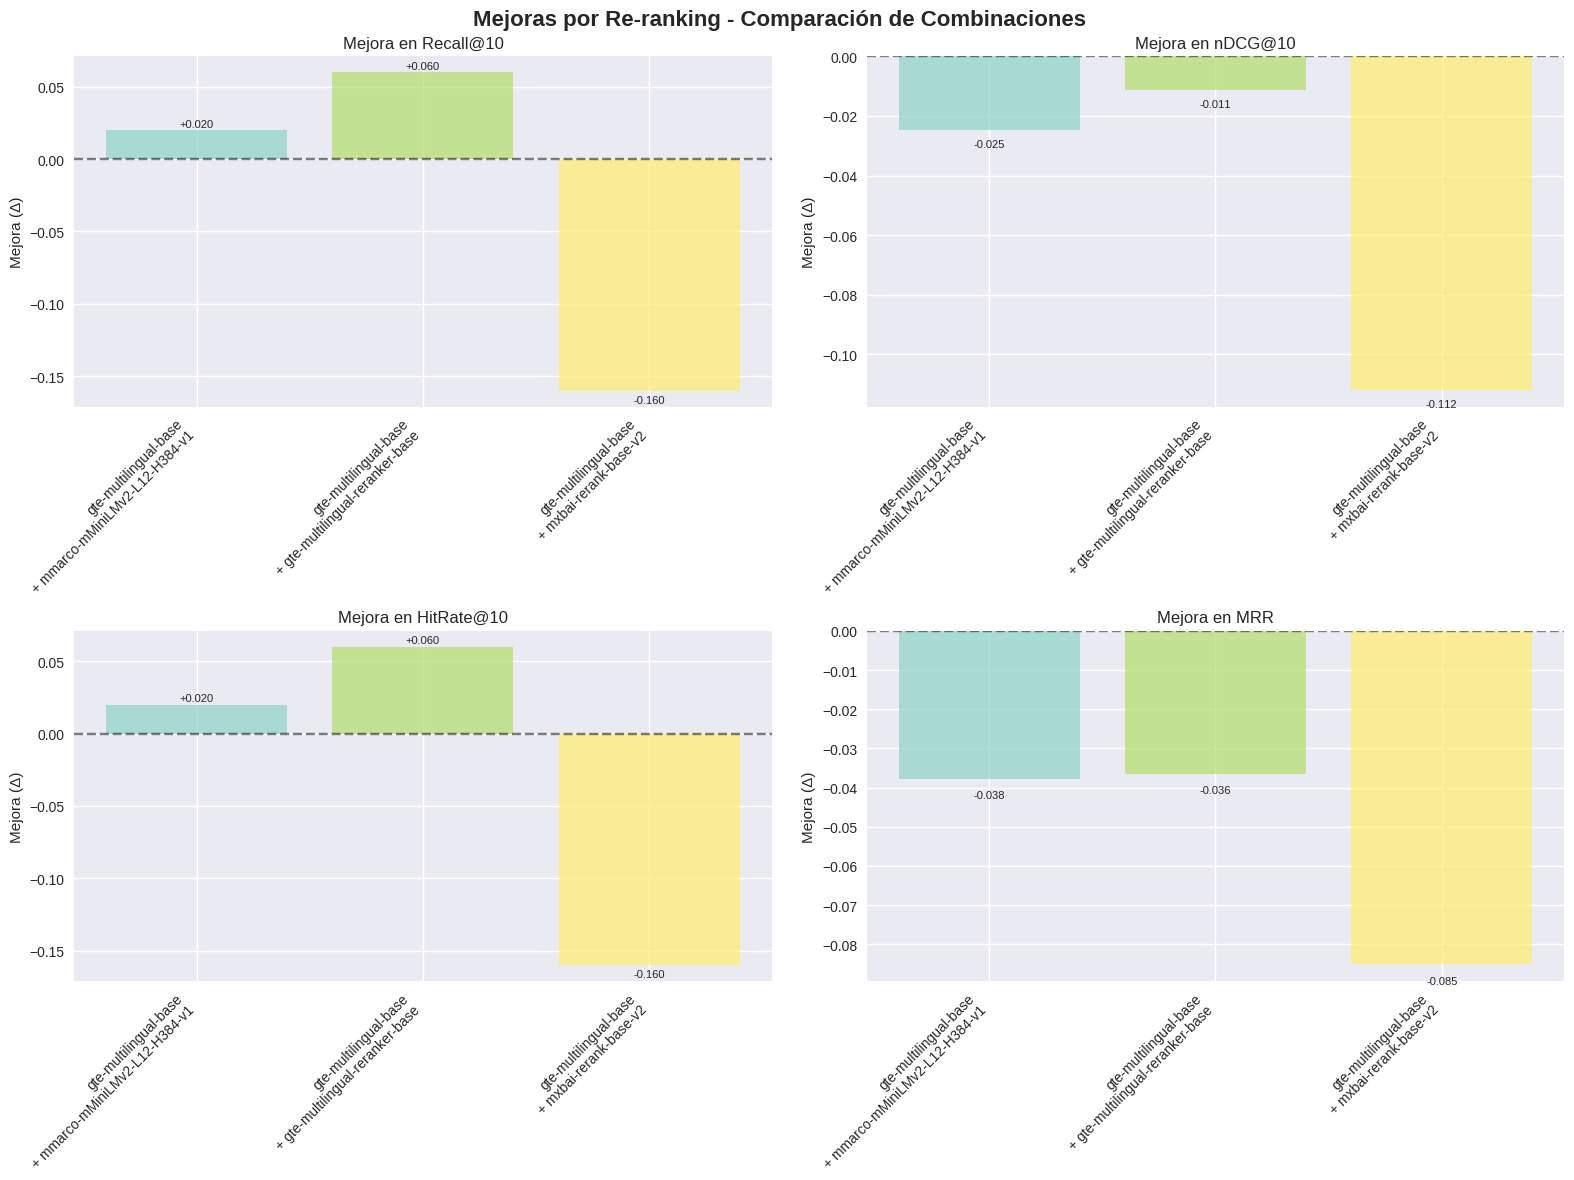

In [80]:
visualize_reranking_results(reranking_results, best_embedding_config['k'])

In [81]:
# Ver comparativa de métrica por modelo
def prepare_comparison_reranking_df(reranking_results, k):
    """
    Genera un DataFrame comparativo con mean ± std de cada métrica por modelo.
    """
    metrics = [
        f'recall_improvement_at_{k}', 
        #f'precision_improvement_at_{k}', 
        f'ndcg_improvement_at_{k}', 
        f'hit_rate_improvement_at_{k}', 
        'mrr_improvement'
    ]
    comparison_rows = []

    for embedding_name, embedding_data in reranking_results.items():
        for reranking_name, combination_data in embedding_data.items():
            row = {
                'Embedding': embedding_name,
                'Reranking': reranking_name
            }
        
            aggregated = combination_data['aggregated_metrics']
            
            for metric in metrics:
                if metric in aggregated:
                    mean_val = aggregated[metric]['mean']
                    std_val = aggregated[metric]['std']
                    row[f'{metric}_promedio'] = f"{mean_val:.3f} ± {std_val:.3f}"
                else:
                    row[metric] = "N/A"
            comparison_rows.append(row)

    comparison_df = pd.DataFrame(comparison_rows)
    # Ordenar columnas: Modelo primero
    cols = ['Embedding', 'Reranking'] + [f'{metric}_promedio' for metric in metrics if f'{metric}_promedio' in comparison_df.columns]
    comparison_df = comparison_df[cols]
    return comparison_df

In [82]:
print("\n===== Resumen Comparativo de Modelos de Reranking (promedio de métricas) =====\n")


===== Resumen Comparativo de Modelos de Reranking (promedio de métricas) =====



In [83]:
prepare_comparison_reranking_df(reranking_results, best_embedding_config['k'])

,Embedding,Reranking,recall_improvement_at_10_promedio,ndcg_improvement_at_10_promedio,hit_rate_improvement_at_10_promedio,mrr_improvement_promedio
0,gte-multilingual-base,mmarco-mMiniLMv2-L12-H384-v1,0.020 ± 0.374,-0.025 ± 0.197,0.020 ± 0.374,-0.038 ± 0.149
1,gte-multilingual-base,gte-multilingual-reranker-base,0.060 ± 0.369,-0.011 ± 0.228,0.060 ± 0.369,-0.036 ± 0.193
2,gte-multilingual-base,mxbai-rerank-base-v2,-0.160 ± 0.543,-0.112 ± 0.294,-0.160 ± 0.543,-0.085 ± 0.216


In [84]:
# Mostrar el mejor modelo por métrica
def best_models_reranking(reranking_results, k):
    """
    Devuelve un DataFrame con el mejor modelo por cada métrica para un valor k.
    """

    metrics = [
        f'recall_improvement_at_{k}', 
        #f'precision_improvement_at_{k}', 
        f'ndcg_improvement_at_{k}', 
        f'hit_rate_improvement_at_{k}', 
        'mrr_improvement'
    ]
    
    rows = []
    for metric in metrics:
        best_model = None
        best_score = -1
        
        for embedding_name, embedding_data in reranking_results.items():
            for reranking_name, combination_data in embedding_data.items():
                if metric in combination_data['aggregated_metrics']:
                    score = combination_data['aggregated_metrics'][metric]['mean']
                    if score > best_score:
                        best_score = score
                        best_model = f'{embedding_name} + {reranking_name}'
            if best_model:
                rows.append({
                    'Métrica': metric,
                    'Mejor Modelo': best_model,
                    'Score Promedio': best_score
                })
    
    return pd.DataFrame(rows)

In [85]:
print(f"\n===== Mejores Modelos de Reranking (promedio de métricas) =====\n")


===== Mejores Modelos de Reranking (promedio de métricas) =====



In [86]:
best_models_reranking(reranking_results, best_embedding_config['k'])

,Métrica,Mejor Modelo,Score Promedio
0,recall_improvement_at_10,gte-multilingual-base + gte-multilingual-reran...,0.060000
1,ndcg_improvement_at_10,gte-multilingual-base + gte-multilingual-reran...,-0.011209
2,hit_rate_improvement_at_10,gte-multilingual-base + gte-multilingual-reran...,0.060000
3,mrr_improvement,gte-multilingual-base + gte-multilingual-reran...,-0.036409


In [87]:
df_best_k = best_models_reranking(reranking_results, best_embedding_config['k'])


# Agregar columna con k
df_best_k['k'] = best_embedding_config['k']

# Reordenar columnas
df_reranking_summary = df_best_k[['k', 'Métrica', 'Mejor Modelo', 'Score Promedio']]

# Mostrar
df_reranking_summary

,k,Métrica,Mejor Modelo,Score Promedio
0,10,recall_improvement_at_10,gte-multilingual-base + gte-multilingual-reran...,0.060000
1,10,ndcg_improvement_at_10,gte-multilingual-base + gte-multilingual-reran...,-0.011209
2,10,hit_rate_improvement_at_10,gte-multilingual-base + gte-multilingual-reran...,0.060000
3,10,mrr_improvement,gte-multilingual-base + gte-multilingual-reran...,-0.036409


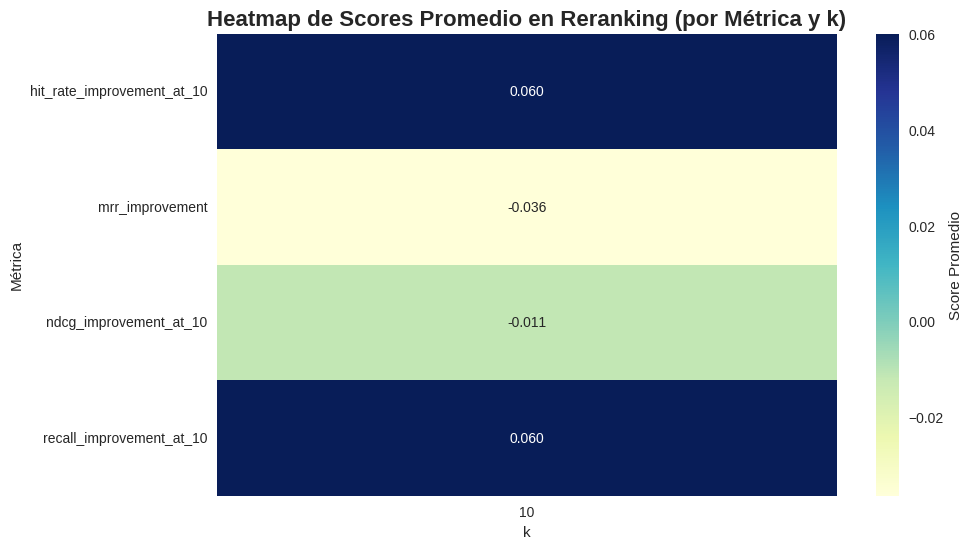

In [88]:
# Pivotar para tener métricas como filas, k como columnas, y Score Promedio como valores
heatmap_reranking_df = df_reranking_summary.pivot(index='Métrica', columns='k', values='Score Promedio')

# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_reranking_df, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'Score Promedio'})

plt.title("Heatmap de Scores Promedio en Reranking (por Métrica y k)", fontsize=16, fontweight='bold')

plt.ylabel("Métrica")
plt.xlabel("k")
plt.yticks(rotation=0)

plt.show()

In [349]:
def analyze_reranking_improvements(df, improvement_threshold= 0.03, language="en"):
    """
    Analyze reranking improvements by model and k, and decide if reranking is worth it.
    """

    # Weights for improvements (can be adjusted)
    metric_weights = {
        "recall_improvement": 0.3,
        "ndcg_improvement": 0.35,
        "mrr_improvement": 0.25,
        "hit_rate_improvement": 0.1,
    }

    # Labels
    texts = {
        "en": {
            "metric_scores": "Metric Improvements",
            "final_score": "Weighted Final Improvement",
            "decision": "Decision",
            "recommended": "Recommended",
            "not_recommended": "Not recommended",
            "reason": "Weighted improvement {:.3f} vs threshold {:.3f}"
        },
        "es": {
            "metric_scores": "Mejoras de Métricas",
            "final_score": "Mejora Final Ponderada",
            "decision": "Decisión",
            "recommended": "Recomendado",
            "not_recommended": "No recomendado",
            "reason": "Mejora ponderada {:.3f} vs umbral {:.3f}"
        }
    }
    lang = texts.get(language, texts["en"])

    results = {}

    for model in df["Mejor Modelo"].unique():
        results[model] = {}
        model_df = df[df["Mejor Modelo"] == model]

        for k_value in sorted(model_df["k"].unique()):
            subset = model_df[model_df["k"] == k_value]

            metric_scores = {}
            weighted_sum = 0.0
            total_weight = 0.0

            for _, row in subset.iterrows():
                metric_name = row["Métrica"]
                score = row["Score Promedio"]

                metric_scores[metric_name] = score

                if metric_name in metric_weights:
                    weighted_sum += score * metric_weights[metric_name]
                    total_weight += metric_weights[metric_name]

            final_score = weighted_sum / total_weight if total_weight > 0 else 0

            # Decisión
            if final_score >= improvement_threshold:
                decision = lang["recommended"]
            else:
                decision = lang["not_recommended"]

            results[model][int(k_value)] = {
                lang["metric_scores"]: metric_scores,
                lang["final_score"]: final_score,
                lang["decision"]: {
                    "status": decision,
                    "detail": lang["reason"].format(final_score, improvement_threshold)
                }
            }

    return results

In [350]:
# Resultados en inglés
insights_reranking_en = analyze_reranking_improvements(df_reranking_summary, language="en")
insights_reranking_es = analyze_reranking_improvements(df_reranking_summary, language="es")


for model, ks in insights_reranking_es.items():
    print(f"\nModelo: {model}")
    for k, analysis in ks.items():
        print(f"  k = {k}")
        for section, content in analysis.items():
            if isinstance(content, dict):
                print(f"    {section}:")
                for key, value in content.items():
                    print(f"      - {key}: {value}")
            else:
                print(f"    {section}: {content}")


Modelo: gte-multilingual-base + gte-multilingual-reranker-base
  k = 10
    Mejoras de Métricas:
      - recall_improvement_at_10: 0.06
      - ndcg_improvement_at_10: -0.011208626709516657
      - hit_rate_improvement_at_10: 0.06
      - mrr_improvement: -0.036408628523179616
    Mejora Final Ponderada: -0.036408628523179616
    Decisión:
      - status: No recomendado
      - detail: Mejora ponderada -0.036 vs umbral 0.030


In [351]:
best_reranking_config = {
    "use_reranking": False, 
    "reranking_model": "mmarco-mMiniLMv2-L12-H384-v1",
    "embedding_model": best_embedding_config["embedding_model"],
    "k": best_embedding_config["k"],
    "collection_name": best_embedding_config["collection_name"]
}

pprint(best_reranking_config, indent=2, width=100) 

{ 'collection_name': 'test_collection_gte-multilingual-base',
  'embedding_model': 'gte-multilingual-base',
  'k': 10,
  'reranking_model': 'mmarco-mMiniLMv2-L12-H384-v1',
  'use_reranking': False}


In [353]:
# Guardar resultados de evaluación de re-ranking
def save_reranking_evaluation_results(reranking_results, insights_reranking, best_reranking_config, dataset, evaluation_name = "reranking_evaluation"):
    """
    Guarda los resultados de evaluación de re-ranking
    """
    # Preparar configuración
    config = {
        'embedding_models': list(EMBEDDING_MODELS.keys()),
        'reranking_models': list(RERANKING_MODELS.keys()),
        'retrieval_metrics': RETRIEVAL_METRICS,
        'qdrant_config': QDRANT_CONFIG,
        'dataset_size': len(dataset)
    }
    
    # Preparar metadatos
    metadata = {
        'evaluation_type': 'reranking',
        'description': 'Evaluación de modelos de re-ranking para mejorar relevancia de documentos',
        'timestamp': datetime.now().isoformat(),
        'total_queries': len(dataset),
        'total_combinations': sum(len(embedding_data) for embedding_data in reranking_results.values()),
        'insights_reranking': insights_reranking,
        'best_reranking_config': best_reranking_config
    }
    
    # Guardar evaluación
    filepath = eval_manager.save_evaluation(
        evaluation_name=evaluation_name,
        config=config,
        results=reranking_results,
        metadata=metadata
    )

In [354]:
# Guardar resultados
reranking_filepath = save_reranking_evaluation_results(reranking_results, insights_reranking_es, best_reranking_config, df_ground_truth)

Evaluación guardada: experiment_results/reranking_evaluation_26092025.json


# 6. Evaluación del Flujo Completo con LLM

## Objetivo de la Evaluación

En esta etapa, nos concentramos en evaluar la **calidad de las respuestas generadas por el LLM**. Dado que ya se midieron las métricas objetivas de *retrieval* y *reranking*, el análisis se centra ahora en las **métricas subjetivas**, utilizando un enfoque de *LLM-as-a-judge*.

### Proceso de Evaluación Subjetiva

1. **Generación**: Crear respuestas con el LLM usando el contexto recuperado.
2. **Evaluación Automática**: Emplear un LLM evaluador para asignar puntuaciones a cada criterio subjetivo.
3. **Análisis de Calidad**: Revisar fortalezas y debilidades en la generación de respuestas.
4. **Decisión**: Identificar si la calidad es suficiente o si se requieren ajustes (ej. cambios en prompts, más contexto, mejor reranking).

### Métricas de Evaluación Subjetiva

* **Coherencia**: ¿La respuesta mantiene una estructura clara y lógica?
* **Relevancia**: ¿Responde directamente a la pregunta planteada?
* **Completitud**: ¿Cubre todos los aspectos necesarios de la consulta?
* **Fidelidad**: ¿Se ajusta estrictamente a la evidencia en el contexto?
* **Concisión**: ¿Es clara y directa sin omitir información esencial?

Cada criterio se evalúa con una escala (ej. 1 a 5) y se puede calcular un **score promedio de calidad global**.

### Modelos de LLM Evaluados

* **Gemini 2.5 Flash** → Modelo rápido y eficiente, balance costo-calidad.
* **Gemini 2.5 Pro** → Versión más avanzada de Gemini, con mayor capacidad de razonamiento y fidelidad.
* **OpenAI GPT-3.5-turbo** → Modelo económico y robusto, útil como baseline y juez de calidad.
* **OpenAI GPT-4o** → Modelo de alta calidad para evaluar el límite superior de coherencia, relevancia y completitud.
* **Configuración** → Para esta evaluación **no se ajustarán parámetros de generación** como temperatura, top-k o max tokens; se comparan modelos bajo condiciones estándar.

In [309]:
model_llm_use_eval = "gpt-4o-mini"

In [310]:
# Clase para evaluación completa del pipeline RAG
class RAGPipelineEvaluator:
    """
    Evalúa el pipeline completo de RAG incluyendo generación y evaluación con LLM
    """

    def __init__(self, qdrant_client, embedding_model, reranking_model, collection_name, top_k):
        self.qdrant_client = qdrant_client
        self.embedding_model = embedding_model
        self.reranking_model = reranking_model
        self.collection_name = collection_name
        self.top_k = top_k
        self.results = {}
    
    def _retrieve_documents(self, query):

        # Obtener modelo de embedding
        model_info = self.embedding_model
        model = model_info['model']
        
        # Generar embedding de la consulta
        query_embedding = model.encode(query)
        
        # Buscar en Qdrant
        search_results = self.qdrant_client.search(
            collection_name=self.collection_name,
            query_embedding=query_embedding,
            limit=self.top_k
        )
        
        # Formatear resultados
        documents = []
        for result in search_results:
            documents.append({
                'id': result.id,
                'score': result.score,
                'payload': result.payload
            })
        
        return documents

    def _extract_document_text(self, payload):
        """
        Extrae el texto relevante del payload del documento para re-ranking
        """
    
        # Retornar capítulo y artículo (mismo formato que para embedding)
        return f"{payload['capitulo_descripcion']}: {payload['articulo']}"

    def _rerank_documents(self, query, documents):
        """
        Re-ordena documentos usando un modelo de re-ranking
        """
        if not documents:
            return []
    
        # Obtener modelo de re-ranking
        model = self.reranking_model['model']
    
        # Preparar pares (query, documento) para el cross-encoder
        query_doc_pairs = [
            (query, self._extract_document_text(doc['payload']))
            for doc in documents
        ]
    
        # Calcular scores de relevancia
        relevance_scores = model.predict(query_doc_pairs)
    
        # Asociar cada doc con su score y ordenar
        reranked_docs = [
            (doc, float(score)) for doc, score in zip(documents, relevance_scores)
        ]
        reranked_docs.sort(key=lambda x: x[1], reverse=True)
    
        # Devolver solo los documentos en orden
        return [doc for doc, _ in reranked_docs]
        
    def _build_context(self, documents):
        """
        Construye el contexto a partir de los documentos
        """
        context_parts = []
        
        for i, doc in enumerate(documents, 1):
        
            # Extraer información del documento
            payload = doc['payload']
            articulo_text = payload.get('articulo', 'Texto no disponible')
            capitulo_descripcion = payload.get('capitulo_descripcion', 'Descripción no disponible')
            articulo_numero = payload.get('articulo_numero', 'N/A')
            
            # Formatear documento
            doc_text = f"{articulo_text} [Capitulo: {capitulo_descripcion} - artículo numero: {articulo_numero}]"
            context_parts.append(f"Documento {i}:\n{doc_text}\n")
        
        return "\n".join(context_parts)

    def _create_prompt(self, query, context):
        """
        Crea el prompt para el LLM
        """
        prompt = textwrap.dedent(f"""\
            Eres un asistente especializado en derecho laboral paraguayo. 
            Responde la pregunta del usuario basándote únicamente en el contexto proporcionado.
    
            CONTEXTO:
            {context}
    
            PREGUNTA: {query}
    
            INSTRUCCIONES:
            - Responde de manera clara y precisa
            - Basa tu respuesta únicamente en el contexto proporcionado
            - Si el contexto no contiene información suficiente, indícalo claramente
            - Cita los artículos específicos cuando sea relevante
            - Mantén un tono profesional y técnico apropiado para el ámbito legal
    
            RESPUESTA:""")
        
        return prompt

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=2, min=2, max=60))
    def _generate_openai_response(self, model, prompt):
        """
        Genera respuesta usando OpenAI para un flujo RAG.
        """

        openai = OpenAI()
        
        response = openai.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "Eres un asistente especializado en derecho laboral paraguayo."},
                {"role": "user", "content": prompt}
            ]
        )
        
        return response.choices[0].message.content.strip()

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=2, min=2, max=60))
    def _generate_gemini_response(self, model, prompt):
        """
        Genera respuesta usando Gemini (Google) para un flujo RAG.
        """
        
        #gemini = genai.Client(os.getenv("GEMINI_API_KEY"))
        gemini = genai.Client()
          
        response = gemini.models.generate_content(
            model=model,
            config=types.GenerateContentConfig(
                system_instruction="Eres un asistente especializado en derecho laboral paraguayo."),
            contents=prompt
        )
        
        return response.text.strip()

    def _generate_response(self, query, documents, model, provider):
        """
        Genera respuesta usando LLM con contexto de documentos
        """
        if not documents:
            return "No se encontraron documentos relevantes para responder la pregunta."
        
        # Preparar contexto con documentos más relevantes
        context_text = self._build_context(documents)
        
        # Crear prompt para el LLM
        prompt = self._create_prompt(query, context_text)
        
        # Generar respuesta
        if provider == "openai":
            response = self._generate_openai_response(model, prompt)
        else:
            response = self._generate_gemini_response(model, prompt)
        
        return response
        
    def _create_evaluation_prompt(self, query, generated_response, expected_answer, documents):
        """
        Crea el prompt para evaluación con LLM-as-a-judge
        """
        context_text = self._build_context(documents)
        
        prompt = textwrap.dedent(f"""Eres un evaluador experto en sistemas de RAG. Evalúa la calidad de la respuesta generada según los criterios especificados.

        PREGUNTA: {query}
        
        RESPUESTA ESPERADA: {expected_answer}
        
        RESPUESTA GENERADA: {generated_response}
        
        CONTEXTO USADO: {context_text}
        
        CRITERIOS DE EVALUACIÓN:
        1. Coherencia (1-5): ¿La respuesta es coherente y bien estructurada?
        2. Relevancia (1-5): ¿La respuesta es relevante a la pregunta?
        3. Completitud (1-5): ¿La respuesta abarca todos los aspectos necesarios?
        4. Fidelidad (1-5): ¿La respuesta es fiel al contexto proporcionado?
        5. Concisión (1-5): ¿La respuesta es concisa sin ser incompleta?
        
        EVALÚA CADA CRITERIO Y RESPONDE EN EL SIGUIENTE FORMATO JSON:
        {{
            "coherence": X,
            "relevance": X,
            "completeness": X,
            "fidelity": X,
            "conciseness": X,
            "explanation": "Breve explicación de la evaluación"
        }}
        
        Donde X es un número del 1 al 5 para cada criterio.""")
        
        return prompt    

    def _parse_evaluation_response(self, evaluation_response):
        """
        Parsea la respuesta de evaluación del LLM
        """

        # Buscar JSON en la respuesta
        json_match = re.search(r'\{.*\}', evaluation_response, re.DOTALL)
        
        if json_match:
            json_str = json_match.group()
            evaluation_data = json.loads(json_str)
            
            # Validar que tenga las claves necesarias
            required_keys = ['coherence', 'relevance', 'completeness', 'fidelity', 'conciseness']
            if all(key in evaluation_data for key in required_keys):
                # Calcular overall_score como promedio de los 5 criterios
                scores = [float(evaluation_data[k]) for k in required_keys]
                evaluation_data['overall_score'] = round(sum(scores) / len(scores), 2)
                return evaluation_data

    def _evaluate_response_quality(self, query, generated_response, expected_answer, documents):
        """
        Evalúa la calidad de la respuesta generada usando LLM-as-a-judge
        """

        # Crear prompt para evaluación
        prompt = self._create_evaluation_prompt(
            query, 
            generated_response, 
            expected_answer, 
            documents
        )
        
        # Generar evaluación
        model = model_llm_use_eval
        response = self._generate_openai_response(model, prompt)
        
        # Parsear evaluación
        quality_scores = self._parse_evaluation_response(response)
        
        return quality_scores
        
    def flow_rag_evaluate(self, query, expected_answer, use_reranking, provider, model):
        """
        Evalúa el pipeline completo de RAG
        """
        
        results = {
            'query': query,
            'expected_answer': expected_answer,
        }
        
        # 1. Retrieval
        documents = self._retrieve_documents(query)
        
        # 2. Re-ranking
        if use_reranking:
            documents = self._rerank_documents(query, documents)

        results['documents'] = documents
        
        # 3. Generación de respuesta
        generated_response = self._generate_response(query, documents, model, provider)
        results['generated_response'] = generated_response
        
        # 4. Evaluación de calidad de respuesta
        quality_scores = self._evaluate_response_quality(query, generated_response, expected_answer, documents)
        results['quality_scores'] = quality_scores
        
        return results

In [168]:
# Inicializar evaluador del pipeline completo
rag_evaluator = RAGPipelineEvaluator(
    qdrant_client=initialized_services['qdrant'],
    embedding_model=initialized_services['embedding_models'][best_reranking_config['embedding_model']],
    reranking_model=initialized_services['reranking_models'][best_reranking_config['reranking_model']],
    collection_name=best_reranking_config['collection_name'],
    top_k=best_reranking_config['k']
)

print("Evaluador del pipeline RAG completo inicializado")

Evaluador del pipeline RAG completo inicializado


In [182]:
def print_quality_per_query(quality_scores):
    """
    Imprime las métricas de calidad por cada pregunta evaluada.
    """
    print("Bloque de calidad por pregunta:")
    print(f"  Overall:      {float(quality_scores.get('overall_score', 0)):.1f}/5")
    print(f"  Coherencia:   {float(quality_scores.get('coherence', 0)):.1f}/5")
    print(f"  Relevancia:   {float(quality_scores.get('relevance', 0)):.1f}/5")
    print(f"  Completitud:  {float(quality_scores.get('completeness', 0)):.1f}/5")
    print(f"  Fidelidad:    {float(quality_scores.get('fidelity', 0)):.1f}/5")
    print(f"  Concisión:    {float(quality_scores.get('conciseness', 0)):.1f}/5\n")


In [175]:
def print_model_llm_summary(model_key, aggregated):
    print(f"Resumen de {model_key} (Calidad):")
    print(f"Overall Score: {aggregated.get('quality_overall_score', {}).get('mean', 0):.1f}/5")
    print(f"Coherencia: {aggregated.get('quality_coherence', {}).get('mean', 0):.1f}/5")
    print(f"Relevancia: {aggregated.get('quality_relevance', {}).get('mean', 0):.1f}/5")
    print(f"Completitud: {aggregated.get('quality_completeness', {}).get('mean', 0):.1f}/5")
    print(f"Fidelidad: {aggregated.get('quality_fidelity', {}).get('mean', 0):.1f}/5")
    print(f"Concisión: {aggregated.get('quality_conciseness', {}).get('mean', 0):.1f}/5\n")

In [176]:
def calculate_rag_aggregated_metrics(query_results):
    """
    Calcula métricas agregadas para evaluación del pipeline RAG
    """
    if not query_results:
        return {}
        
    # Extraer métricas de calidad
    quality_metrics = {}
    for result in query_results:
        for metric, value in result['quality_scores'].items():
            if metric != 'explanation':  # Excluir explicación
                if f'quality_{metric}' not in quality_metrics:
                    quality_metrics[f'quality_{metric}'] = []
                quality_metrics[f'quality_{metric}'].append(float(value))
    
    # Calcular estadísticas
    aggregated = {}
    for metric_name, values in quality_metrics.items():
        if values:
            aggregated[metric_name] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values)),
                'median': float(np.median(values))
            }
    
    return aggregated

In [183]:
# Función para evaluación completa del pipeline RAG
def evaluate_complete_rag_pipeline(dataset, embedding_models, reranking_models, use_reranking, llm_config, show_per_query=False):
    """
    Evalúa el pipeline completo de RAG con todas las combinaciones de model
    """
    
    print("Iniciando evaluación completa del pipeline RAG...")
    print(f"Evaluando {len(dataset)} preguntas")
    print(f"Modelo de embedding: {embedding_models}")
    print(f"Modelo de re-ranking: {reranking_models if use_reranking else '-'}")
    print(f"Modelos de LLM: {len(llm_config)}")
    
    print("=" * 70)
    
    all_results = {}
    
    # Evaluar cada combinación de modelo llm
    for m in llm_config:
        provider = m["provider"]
        model = m["model"]
        print(f"\n\nLLM: {model}")
        print("-" * 50)
                    
        combination_results = {
            'embedding_model': embedding_models,
            'reranking_model': reranking_models,
            'use_reranking': use_reranking,
            'llm': model,
            'provider': provider,
            'query_results': [],
            'aggregated_metrics': {}
        }
        
        # Evaluar cada pregunta
        for idx, row in dataset.iterrows():
            query = row['question']
            expected_answer = row['expected_answer']

            if show_per_query:
                print(f"Pregunta {idx + 1}/{len(dataset)}: {query[:40]}...")
            
            # Evaluar pipeline completo
            query_metrics = rag_evaluator.flow_rag_evaluate(
                query=query,
                expected_answer=expected_answer,
                use_reranking=use_reranking,
                provider=provider,
                model=model
            )
            
            # Agregar información de la consulta
            query_metrics['query_id'] = idx
            combination_results['query_results'].append(query_metrics)

            # Mostrar métricas principales
            if show_per_query:
                quality_scores = query_metrics.get('quality_scores')
                print_quality_per_query(quality_scores)
    
                    
        # Calcular métricas agregadas
        if combination_results['query_results']:
            print(f"\nCalculando métricas agregadas...")
            aggregated = calculate_rag_aggregated_metrics(combination_results['query_results'])
            combination_results['aggregated_metrics'] = aggregated
            
            # Mostrar resumen
            print_model_llm_summary(model, aggregated)
        
        all_results[model] = combination_results
    
    print("\n" + "=" * 70)
    print("Evaluación del pipeline RAG completada")
    
    return all_results

In [184]:
# Ejecutar evaluación completa del pipeline RAG
complete_rag_results = evaluate_complete_rag_pipeline(
    dataset=df_ground_truth[:2], 
    embedding_models=initialized_services['embedding_models'][best_reranking_config['embedding_model']]['config']['model_name'], 
    reranking_models=initialized_services['reranking_models'][best_reranking_config['reranking_model']]['config']['model_name'], 
    use_reranking=False, 
    llm_config=LLM_CONFIGS, 
    show_per_query=False
)

Iniciando evaluación completa del pipeline RAG...
Evaluando 2 preguntas
Modelo de embedding: Alibaba-NLP/gte-multilingual-base
Modelo de re-ranking: -
Modelos de LLM: 4


LLM: gpt-3.5-turbo
--------------------------------------------------
Pregunta 1/2: ¿Cuál es el objeto del código mencionado...
Bloque de calidad por pregunta:
  Overall:      4.8/5
  Coherencia:   5.0/5
  Relevancia:   5.0/5
  Completitud:  5.0/5
  Fidelidad:    5.0/5
  Concisión:    4.0/5

Pregunta 2/2: ¿Qué tipos de trabajadores están sujetos...
Bloque de calidad por pregunta:
  Overall:      3.4/5
  Coherencia:   3.0/5
  Relevancia:   4.0/5
  Completitud:  4.0/5
  Fidelidad:    4.0/5
  Concisión:    2.0/5


Calculando métricas agregadas...
Resumen de gpt-3.5-turbo (Calidad):
Overall Score: 4.1/5
Coherencia: 4.0/5
Relevancia: 4.5/5
Completitud: 4.5/5
Fidelidad: 4.5/5
Concisión: 3.0/5



LLM: gpt-4o
--------------------------------------------------
Pregunta 1/2: ¿Cuál es el objeto del código mencionado...
Bloque de

In [188]:
def visualize_quality_results(rag_results):
    """
    Visualiza únicamente las métricas de calidad del pipeline RAG (por LLM).
    """
    if not rag_results:
        print("No hay resultados para visualizar")
        return
    
    quality_data = []
    models = []
    
    for llm_name, combination_data in rag_results.items():
        metrics = combination_data.get('aggregated_metrics', {})
        if not metrics:
            continue
        
        models.append(llm_name)
        quality_data.append({
            'model': llm_name,
            'coherence': metrics.get('quality_coherence', {}).get('mean', 0),
            'relevance': metrics.get('quality_relevance', {}).get('mean', 0),
            'completeness': metrics.get('quality_completeness', {}).get('mean', 0),
            'fidelity': metrics.get('quality_fidelity', {}).get('mean', 0),
            'conciseness': metrics.get('quality_conciseness', {}).get('mean', 0),
            'overall_score': metrics.get('quality_overall_score', {}).get('mean', 0)
        })
    
    if not quality_data:
        print("No hay datos suficientes para visualizar métricas de calidad")
        return
    
    # Colores
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    
    # Métricas de calidad
    quality_metrics = ['coherence', 'relevance', 'completeness', 'fidelity', 'conciseness', 'overall_score']
    quality_titles = ['Coherencia', 'Relevancia', 'Completitud', 'Fidelidad', 'Concisión', 'Score General']
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('Métricas de Calidad del Pipeline RAG por LLM', fontsize=16, fontweight='bold')
    
    for idx, (metric, title) in enumerate(zip(quality_metrics, quality_titles)):
        row = idx // 2
        col = idx % 2
        values = [data[metric] for data in quality_data]
        labels = [data['model'] for data in quality_data]
        
        bars = axes[row, col].bar(range(len(values)), values, color=colors, alpha=0.7)
        axes[row, col].set_title(title)
        axes[row, col].set_ylabel('Score (1-5)')
        axes[row, col].set_ylim(0, 5)
        axes[row, col].set_xticks(range(len(labels)))
        axes[row, col].set_xticklabels(labels, rotation=45, ha='right')
        
        # Etiquetas de valores
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                               f'{value:.1f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()


In [192]:
print("\n===== Comparación de Modelos LLM - Métricas de Calidad (promedio) =====\n")


===== Comparación de Modelos LLM - Métricas de Calidad (promedio) =====



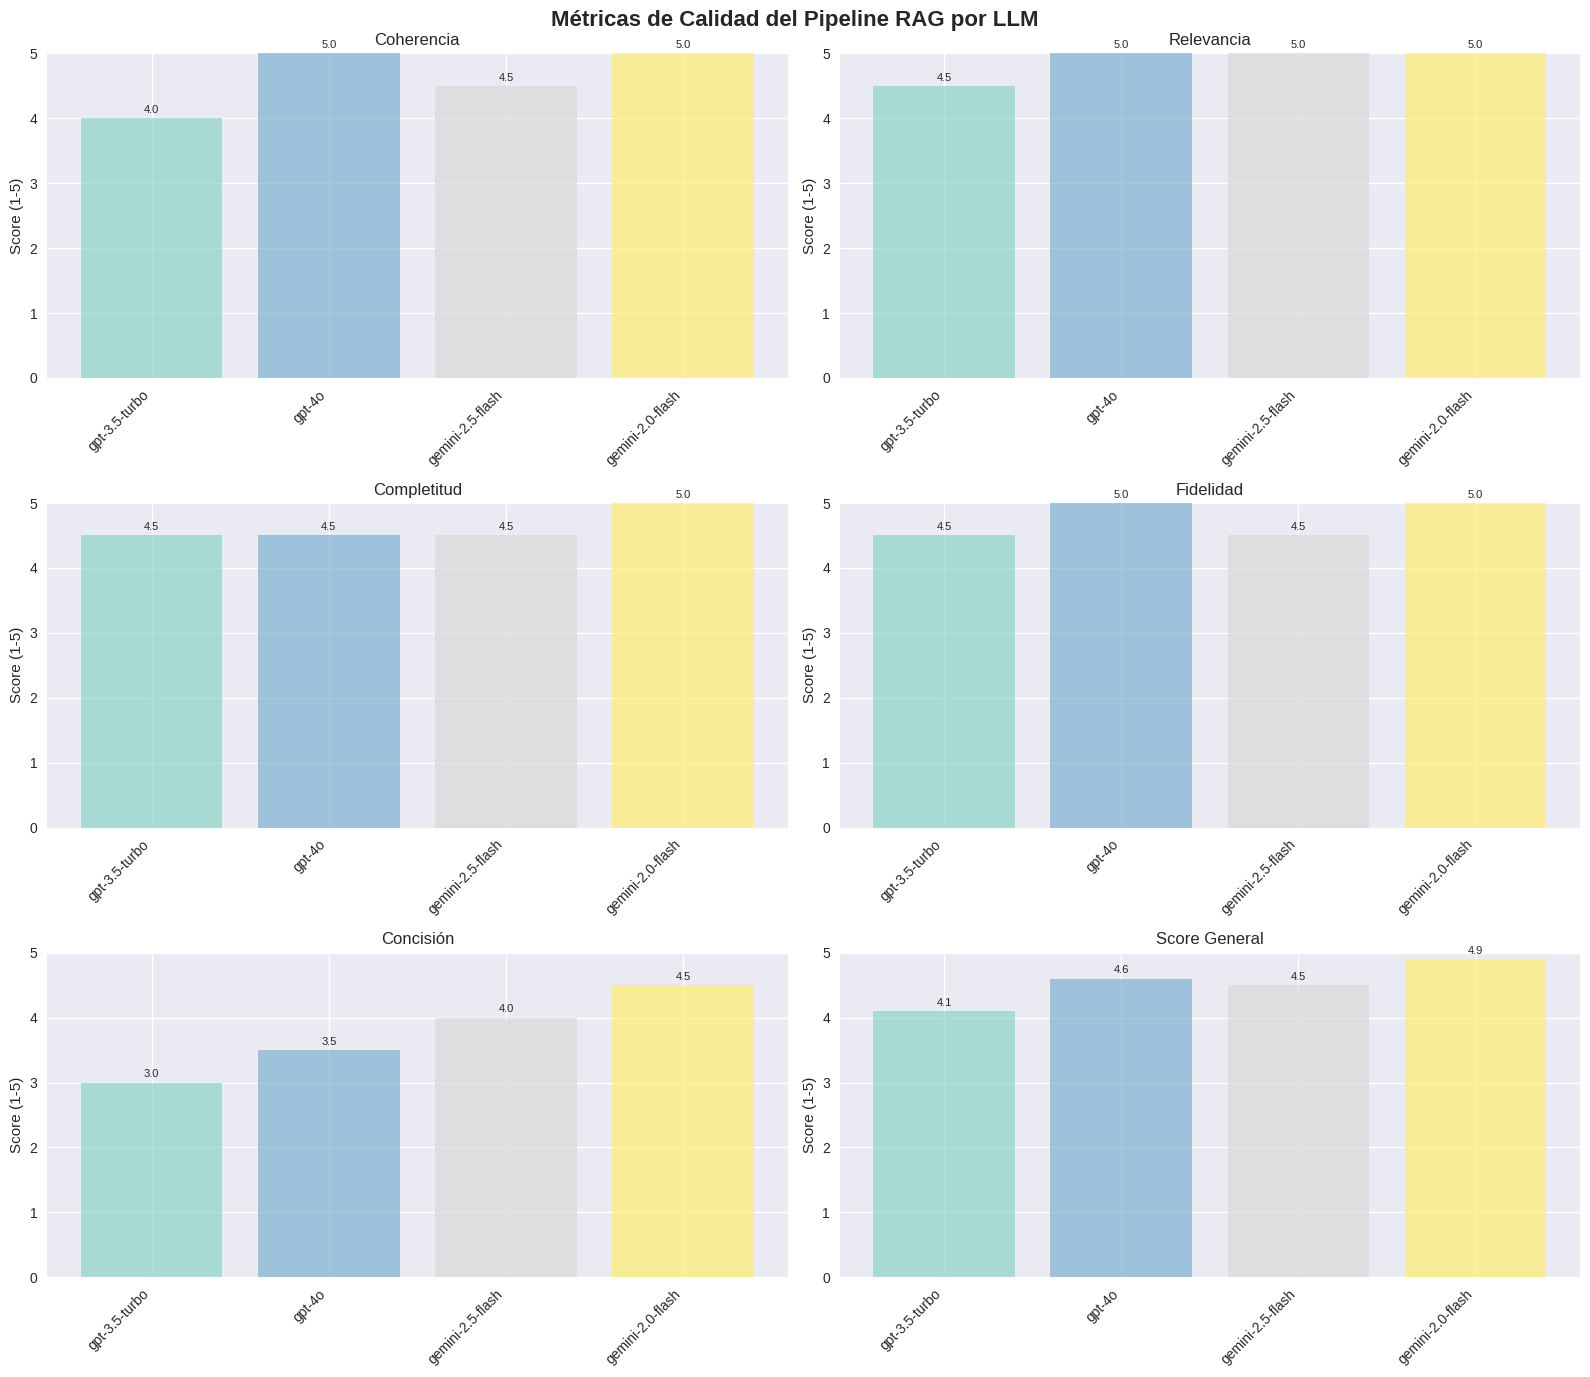

In [189]:
visualize_quality_results(complete_rag_results)

In [233]:
def prepare_comparison_quality_df(rag_results):
    """
    Genera un DataFrame comparativo con mean ± std de cada métrica de calidad por modelo LLM.
    """
    quality_metrics = [
        'quality_coherence',
        'quality_relevance',
        'quality_completeness',
        'quality_fidelity',
        'quality_conciseness',
        'quality_overall_score'
    ]
    
    comparison_rows = []

    for llm_name, llm_data in rag_results.items():
        aggregated = llm_data.get('aggregated_metrics', {})
        
        row = {'Model LLM': llm_name}
        
        for metric in quality_metrics:
            clean_name = metric.replace("quality_", "")
            if metric in aggregated:
                mean_val = aggregated[metric].get('mean', 0)
                std_val = aggregated[metric].get('std', 0)
                row[f'{clean_name}_promedio'] = f"{mean_val:.2f} ± {std_val:.2f}"
            else:
                row[f'{clean_name}_promedio'] = "N/A"
        
        comparison_rows.append(row)
    
    comparison_df = pd.DataFrame(comparison_rows)
    
    # Ordenar columnas: LLM primero, luego métricas
    cols = ['Model LLM'] + [f'{m.replace("quality_", "")}_promedio' for m in quality_metrics]
    comparison_df = comparison_df[cols]
    
    return comparison_df

In [235]:
print("\n===== Resumen Comparativo de Modelos LLM - Métricas de Calidad (promedio) =====\n")


===== Resumen Comparativo de Modelos LLM - Métricas de Calidad (promedio) =====



In [243]:
prepare_comparison_quality_df(complete_rag_results)

,Model LLM,coherence_promedio,relevance_promedio,completeness_promedio,fidelity_promedio,conciseness_promedio,overall_score_promedio
0,gpt-3.5-turbo,4.00 ± 1.00,4.50 ± 0.50,4.50 ± 0.50,4.50 ± 0.50,3.00 ± 1.00,4.10 ± 0.70
1,gpt-4o,5.00 ± 0.00,5.00 ± 0.00,4.50 ± 0.50,5.00 ± 0.00,3.50 ± 0.50,4.60 ± 0.20
2,gemini-2.5-flash,4.50 ± 0.50,5.00 ± 0.00,4.50 ± 0.50,4.50 ± 0.50,4.00 ± 1.00,4.50 ± 0.50
3,gemini-2.0-flash,5.00 ± 0.00,5.00 ± 0.00,5.00 ± 0.00,5.00 ± 0.00,4.50 ± 0.50,4.90 ± 0.10


In [289]:
def best_models_quality(rag_results, include_overall=True):
    """
    Devuelve un DataFrame con el mejor modelo LLM por cada métrica de calidad.
    """
    # Métricas base
    quality_metrics = [
        'quality_coherence',
        'quality_relevance',
        'quality_completeness',
        'quality_fidelity',
        'quality_conciseness',
    ]
    
    if include_overall:
        quality_metrics.append('quality_overall_score')
    
    rows = []
    
    for metric in quality_metrics:
        best_model = None
        best_score = float('-inf')
        
        for llm_name, llm_data in rag_results.items():
            # Acceder a los scores de calidad
            quality_scores = llm_data.get('aggregated_metrics', {})
            
            if metric in quality_scores:
                # Para overall_score puede que no tenga 'mean', usar directamente si es int/float
                score = quality_scores[metric].get('mean', quality_scores[metric] 
                                                    if isinstance(quality_scores[metric], (int, float)) 
                                                    else 0)
                if score > best_score:
                    best_score = score
                    best_model = llm_name

        if best_model:
            rows.append({
                'Métrica': metric.replace("quality_", ""),
                'Mejor Modelo': best_model,
                'Score Promedio': round(best_score, 2)
            })

    return pd.DataFrame(rows)

In [281]:
print("\n===== Mejores Modelos de Reranking (promedio de métricas) =====\n")


===== Mejores Modelos de Reranking (promedio de métricas) =====



In [290]:
best_models_quality(complete_rag_results)

,Métrica,Mejor Modelo,Score Promedio
0,coherence,gpt-4o,5.0
1,relevance,gpt-4o,5.0
2,completeness,gemini-2.0-flash,5.0
3,fidelity,gpt-4o,5.0
4,conciseness,gemini-2.0-flash,4.5
5,overall_score,gemini-2.0-flash,4.9


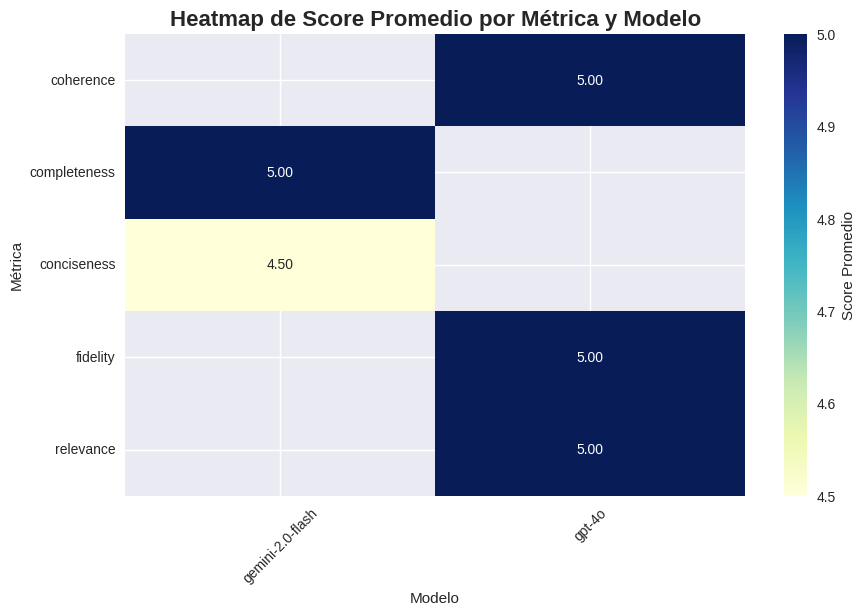

In [292]:
best_model_df = best_models_quality(complete_rag_results, include_overall=False)

# Pivotar para tener métricas como filas, modelos como columnas y Score Promedio como valores
heatmap_df = best_model_df.pivot(index='Métrica', columns='Mejor Modelo', values='Score Promedio')

# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Score Promedio'})

plt.title("Heatmap de Score Promedio por Métrica y Modelo", fontsize=16, fontweight='bold')
plt.ylabel("Métrica")
plt.xlabel("Modelo")
plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.show()

In [306]:
def analyze_quality_models(df, language="es", improvement_threshold=4.7, overall_threshold=4.7, custom_weights=None):
    """
    Analiza las métricas de calidad de modelos LLM y decide el mejor modelo según ponderación.
    Incluye decisión basada en overall_score y decisión ponderada por métricas.
    """

    # Pesos por defecto para métricas relevantes (sin overall_score)
    default_weights = {
        "coherence": 0.2,
        "relevance": 0.25,
        "completeness": 0.15,
        "fidelity": 0.3,   # más peso por contexto legal
        "conciseness": 0.1
    }
    metric_weights = custom_weights or default_weights

    # Etiquetas bilingües
    texts = {
        "en": {
            "metric_scores": "Metric Scores",
            "overall_score": "Overall Score",
            "final_score": "Weighted Final Score",
            "decision_overall": "Decision (Overall)",
            "decision_weighted": "Decision (Weighted)",
            "reason": "Score {:.3f} vs threshold {:.3f}"
        },
        "es": {
            "metric_scores": "Puntajes de Métricas",
            "overall_score": "Score Overall",
            "final_score": "Score Final Ponderado",
            "decision_overall": "Decisión (Overall)",
            "decision_weighted": "Decisión (Ponderada)",
            "reason": "Score {:.3f} vs umbral {:.3f}"
        }
    }
    lang = texts.get(language, texts["es"])

    results = {}

    for model in df["Mejor Modelo"].unique():
        model_df = df[df["Mejor Modelo"] == model]

        metric_scores = {}
        overall_score_value = None
        weighted_sum = 0.0
        total_weight = 0.0

        for _, row in model_df.iterrows():
            metric_name = row["Métrica"].lower()
            score = row["Score Promedio"]

            metric_scores[metric_name] = score

            if metric_name == "overall_score":
                overall_score_value = score
                continue

            weight = metric_weights.get(metric_name, 0)
            weighted_sum += score * weight
            total_weight += weight

        final_score = weighted_sum / total_weight if total_weight > 0 else 0

        # Decisión basada en overall_score
        decision_overall = "Recomendado" if overall_score_value is not None and overall_score_value >= overall_threshold else "No recomendado"

        # Decisión basada en ponderado
        decision_weighted = "Recomendado" if final_score >= improvement_threshold else "No recomendado"

        results[model] = {
            lang["metric_scores"]: metric_scores,
            lang["overall_score"]: overall_score_value,
            lang["final_score"]: final_score,
            lang["decision_overall"]: {
                "status": decision_overall,
                "detail": lang["reason"].format(overall_score_value if overall_score_value else 0, overall_threshold)
            },
            lang["decision_weighted"]: {
                "status": decision_weighted,
                "detail": lang["reason"].format(final_score, improvement_threshold)
            }
        }

    return results

In [304]:
def print_quality_analysis(results, language):
    """
    Imprime de manera legible los resultados del análisis de calidad de modelos.
    """
    for model, data in results.items():
        print(f"\nModelo: {model}")
        print("Métricas:")
        for metric, score in data.get("Puntajes de Métricas" if language=="es" else "Metric Scores", {}).items():
            print(f"  {metric}: {score}")

        overall_label = "Score Overall"
        final_label = "Weighted Final Score" if language=="en" else "Score Final Ponderado"
        decision_overall_label = "Decision (Overall)" if language=="en" else "Decisión (Overall)"
        decision_weighted_label = "Decision (Weighted)" if language=="en" else "Decisión (Ponderada)"

        print(f"{overall_label}: {data.get(overall_label)}")
        print(f"{final_label}: {data.get(final_label):.3f}")

        # Decisión Overall
        dec_overall = data.get(decision_overall_label)
        print(f"{decision_overall_label}: {dec_overall['status']} ({dec_overall['detail']})")

        # Decisión Ponderada
        dec_weighted = data.get(decision_weighted_label)
        print(f"{decision_weighted_label}: {dec_weighted['status']} ({dec_weighted['detail']})")


In [307]:
best_model_df = best_models_quality(complete_rag_results)
analyze_quality_models_en = analyze_quality_models(best_model_df, language="en")
analyze_quality_models_es = analyze_quality_models(best_model_df, language="es")

print_quality_analysis(analyze_quality_models_es, language="es")


Modelo: gpt-4o
Métricas:
  coherence: 5.0
  relevance: 5.0
  fidelity: 5.0
Score Overall: None
Score Final Ponderado: 5.000
Decisión (Overall): No recomendado (Score 0.000 vs umbral 4.700)
Decisión (Ponderada): Recomendado (Score 5.000 vs umbral 4.700)

Modelo: gemini-2.0-flash
Métricas:
  completeness: 5.0
  conciseness: 4.5
  overall_score: 4.9
Score Overall: 4.9
Score Final Ponderado: 4.800
Decisión (Overall): Recomendado (Score 4.900 vs umbral 4.700)
Decisión (Ponderada): Recomendado (Score 4.800 vs umbral 4.700)


In [356]:
best_model_llm_config = {
    "model_llm": "gemini-2.0-flash",
    "model_llm_use_eval": model_llm_use_eval,
    "use_reranking": best_reranking_config["use_reranking"], 
    "reranking_model": best_reranking_config["reranking_model"],
    "embedding_model": best_reranking_config["embedding_model"],
    "k": best_reranking_config["k"],
    "collection_name": best_reranking_config["collection_name"]
}

pprint(best_model_llm_config, indent=2, width=100)

{ 'collection_name': 'test_collection_gte-multilingual-base',
  'embedding_model': 'gte-multilingual-base',
  'k': 10,
  'model_llm': 'gemini-2.0-flash',
  'model_llm_use_eval': 'gpt-4o-mini',
  'reranking_model': 'mmarco-mMiniLMv2-L12-H384-v1',
  'use_reranking': False}


In [365]:
# Guardar resultados de evaluación del pipeline RAG completo
def save_rag_evaluation_results(rag_results, insights_model_llm, best_model_llm_config, dataset, evaluation_name="complete_rag_evaluation"):
    """
    Guarda los resultados de evaluación del pipeline RAG completo
    """
    # Preparar configuración
    config = {
        'embedding_models': list(EMBEDDING_MODELS.keys()),
        'reranking_models': list(RERANKING_MODELS.keys()),
        'retrieval_metrics': RETRIEVAL_METRICS,
        'llm_evaluation_criteria': LLM_EVALUATION_CRITERIA,
        'qdrant_config': QDRANT_CONFIG,
        'llm_config': LLM_CONFIG,
        'dataset_size': len(dataset)
    }
    
    # Preparar metadatos
    metadata = {
        'evaluation_type': 'rag_quality',
        'description': 'Evaluación de la calidad de las respuestas generadas por el pipeline RAG ',
        'timestamp': datetime.now().isoformat(),
        'total_queries': len(dataset),
        'total_combinations': sum(len(embedding_data) for embedding_data in rag_results.values()),
        'insights_model_llm': insights_model_llm,
        'best_model_llm_config': best_model_llm_config
    }
    
    # Guardar evaluación
    filepath = eval_manager.save_evaluation(
        evaluation_name=evaluation_name,
        config=config,
        results=rag_results,
        metadata=metadata
    )

In [367]:
# Guardar resultados
rag_model_llm_filepath = save_rag_evaluation_results(complete_rag_results, analyze_quality_models_es, best_model_llm_config, df_ground_truth)

Evaluación guardada: experiment_results/complete_rag_evaluation_26092025.json


# 7. Análisis Comparativo Global

## Objetivo del Análisis

Esta sección realiza un análisis comparativo integral de todos los resultados obtenidos en las evaluaciones anteriores, combinando métricas de retrieval, re-ranking y calidad de respuesta para identificar patrones, tendencias y recomendaciones finales.

### 🎯 Proceso de Análisis Global

1. **Consolidación de Resultados**: Integrar datos de todas las evaluaciones
2. **Análisis Comparativo**: Comparar rendimiento entre modelos y combinaciones
3. **Identificación de Patrones**: Detectar tendencias y correlaciones
4. **Ranking Global**: Clasificar combinaciones por rendimiento general
5. **Recomendaciones**: Sugerir mejores configuraciones y mejoras

### 📊 Dimensiones de Análisis

#### Análisis por Componente
- **Embeddings**: Rendimiento de diferentes modelos de embedding
- **Re-ranking**: Efectividad de modelos cross-encoder
- **LLM**: Calidad de generación y evaluación
- **Pipeline Completo**: Rendimiento end-to-end

#### Análisis por Métrica
- **Retrieval**: Recall, Precision, nDCG, MRR
- **Calidad**: Coherencia, Relevancia, Completitud, Fidelidad, Concisión
- **Eficiencia**: Tiempo de procesamiento, uso de recursos
- **Robustez**: Consistencia entre consultas

#### Análisis por Combinación
- **Mejores Combinaciones**: Top performers por criterio
- **Trade-offs**: Balance entre diferentes métricas
- **Escalabilidad**: Rendimiento con diferentes tamaños de dataset
- **Estabilidad**: Consistencia de resultados


In [ ]:
# Clase para análisis comparativo global
class GlobalComparativeAnalyzer:
    """
    Realiza análisis comparativo global de todos los resultados de evaluación
    """
    
    def __init__(self, retrieval_results: Dict[str, Any], 
                 reranking_results: Dict[str, Any], 
                 complete_rag_results: Dict[str, Any]):
        self.retrieval_results = retrieval_results
        self.reranking_results = reranking_results
        self.complete_rag_results = complete_rag_results
        self.analysis_results = {}
    
    def consolidate_all_results(self) -> Dict[str, Any]:
        """
        Consolida todos los resultados de las evaluaciones
        
        Returns:
            Diccionario con resultados consolidados
        """
        print("🔄 Consolidando resultados de todas las evaluaciones...")
        
        consolidated = {
            'retrieval_only': self._consolidate_retrieval_results(),
            'reranking_improvements': self._consolidate_reranking_results(),
            'complete_pipeline': self._consolidate_complete_rag_results(),
            'global_rankings': {},
            'insights': {}
        }
        
        # Generar rankings globales
        consolidated['global_rankings'] = self._generate_global_rankings(consolidated)
        
        # Generar insights
        consolidated['insights'] = self._generate_insights(consolidated)
        
        print("✅ Consolidación completada")
        return consolidated
    
    def _consolidate_retrieval_results(self) -> Dict[str, Any]:
        """
        Consolida resultados de evaluación de retrievers
        """
        if not self.retrieval_results:
            return {}
        
        consolidated = {}
        
        for model_name, model_data in self.retrieval_results.items():
            if 'aggregated_metrics' in model_data:
                metrics = model_data['aggregated_metrics']
                consolidated[model_name] = {
                    'recall_at_5': metrics.get('recall_at_5', {}).get('mean', 0),
                    'precision_at_5': metrics.get('precision_at_5', {}).get('mean', 0),
                    'ndcg_at_5': metrics.get('ndcg_at_5', {}).get('mean', 0),
                    'mrr': metrics.get('mrr', {}).get('mean', 0),
                    'total_queries': len(model_data.get('query_results', []))
                }
        
        return consolidated
    
    def _consolidate_reranking_results(self) -> Dict[str, Any]:
        """
        Consolida resultados de evaluación de re-ranking
        """
        if not self.reranking_results:
            return {}
        
        consolidated = {}
        
        for embedding_name, embedding_data in self.reranking_results.items():
            for reranking_name, combination_data in embedding_data.items():
                if 'aggregated_metrics' in combination_data:
                    metrics = combination_data['aggregated_metrics']
                    key = f"{embedding_name}+{reranking_name}"
                    consolidated[key] = {
                        'embedding_model': embedding_name,
                        'reranking_model': reranking_name,
                        'recall_improvement': metrics.get('recall_improvement_at_5', {}).get('mean', 0),
                        'precision_improvement': metrics.get('precision_improvement_at_5', {}).get('mean', 0),
                        'ndcg_improvement': metrics.get('ndcg_improvement_at_5', {}).get('mean', 0),
                        'mrr_improvement': metrics.get('mrr_improvement', {}).get('mean', 0),
                        'total_queries': len(combination_data.get('query_results', []))
                    }
        
        return consolidated
    
    def _consolidate_complete_rag_results(self) -> Dict[str, Any]:
        """
        Consolida resultados de evaluación del pipeline completo
        """
        if not self.complete_rag_results:
            return {}
        
        consolidated = {}
        
        for embedding_name, embedding_data in self.complete_rag_results.items():
            for reranking_name, combination_data in embedding_data.items():
                if 'aggregated_metrics' in combination_data:
                    metrics = combination_data['aggregated_metrics']
                    key = f"{embedding_name}+{reranking_name if reranking_name else 'NoReranking'}"
                    consolidated[key] = {
                        'embedding_model': embedding_name,
                        'reranking_model': reranking_name,
                        'retrieval_recall_at_5': metrics.get('retrieval_recall_at_5', {}).get('mean', 0),
                        'retrieval_precision_at_5': metrics.get('retrieval_precision_at_5', {}).get('mean', 0),
                        'retrieval_ndcg_at_5': metrics.get('retrieval_ndcg_at_5', {}).get('mean', 0),
                        'retrieval_mrr': metrics.get('retrieval_mrr', {}).get('mean', 0),
                        'quality_coherence': metrics.get('quality_coherence', {}).get('mean', 0),
                        'quality_relevance': metrics.get('quality_relevance', {}).get('mean', 0),
                        'quality_completeness': metrics.get('quality_completeness', {}).get('mean', 0),
                        'quality_fidelity': metrics.get('quality_fidelity', {}).get('mean', 0),
                        'quality_conciseness': metrics.get('quality_conciseness', {}).get('mean', 0),
                        'quality_overall_score': metrics.get('quality_overall_score', {}).get('mean', 0),
                        'total_queries': len(combination_data.get('query_results', []))
                    }
        
        return consolidated
    
    def _generate_global_rankings(self, consolidated: Dict[str, Any]) -> Dict[str, List[str]]:
        """
        Genera rankings globales por diferentes criterios
        """
        rankings = {}
        
        # Ranking por retrieval (solo embeddings)
        if 'retrieval_only' in consolidated:
            retrieval_data = consolidated['retrieval_only']
            rankings['best_retrieval'] = sorted(
                retrieval_data.keys(),
                key=lambda x: retrieval_data[x]['recall_at_5'],
                reverse=True
            )
        
        # Ranking por mejoras de re-ranking
        if 'reranking_improvements' in consolidated:
            reranking_data = consolidated['reranking_improvements']
            rankings['best_reranking_improvement'] = sorted(
                reranking_data.keys(),
                key=lambda x: reranking_data[x]['ndcg_improvement'],
                reverse=True
            )
        
        # Ranking por pipeline completo (score combinado)
        if 'complete_pipeline' in consolidated:
            pipeline_data = consolidated['complete_pipeline']
            rankings['best_complete_pipeline'] = sorted(
                pipeline_data.keys(),
                key=lambda x: self._calculate_combined_score(pipeline_data[x]),
                reverse=True
            )
        
        # Ranking por calidad de respuesta
        if 'complete_pipeline' in consolidated:
            pipeline_data = consolidated['complete_pipeline']
            rankings['best_quality'] = sorted(
                pipeline_data.keys(),
                key=lambda x: pipeline_data[x]['quality_overall_score'],
                reverse=True
            )
        
        return rankings
    
    def _calculate_combined_score(self, metrics: Dict[str, Any]) -> float:
        """
        Calcula score combinado (40% retrieval + 60% calidad)
        """
        retrieval_score = metrics.get('retrieval_recall_at_5', 0)
        quality_score = metrics.get('quality_overall_score', 0) / 5  # Normalizar a 0-1
        
        return (0.4 * retrieval_score) + (0.6 * quality_score)
    
    def _generate_insights(self, consolidated: Dict[str, Any]) -> Dict[str, Any]:
        """
        Genera insights y análisis de los resultados
        """
        insights = {
            'retrieval_insights': self._analyze_retrieval_patterns(consolidated),
            'reranking_insights': self._analyze_reranking_patterns(consolidated),
            'quality_insights': self._analyze_quality_patterns(consolidated),
            'correlation_insights': self._analyze_correlations(consolidated),
            'recommendations': self._generate_recommendations(consolidated)
        }
        
        return insights
    
    def _analyze_retrieval_patterns(self, consolidated: Dict[str, Any]) -> Dict[str, Any]:
        """
        Analiza patrones en los resultados de retrieval
        """
        if 'retrieval_only' not in consolidated:
            return {}
        
        retrieval_data = consolidated['retrieval_only']
        
        # Encontrar mejor y peor modelo
        best_model = max(retrieval_data.keys(), key=lambda x: retrieval_data[x]['recall_at_5'])
        worst_model = min(retrieval_data.keys(), key=lambda x: retrieval_data[x]['recall_at_5'])
        
        # Calcular estadísticas
        recall_scores = [data['recall_at_5'] for data in retrieval_data.values()]
        precision_scores = [data['precision_at_5'] for data in retrieval_data.values()]
        ndcg_scores = [data['ndcg_at_5'] for data in retrieval_data.values()]
        
        return {
            'best_model': best_model,
            'worst_model': worst_model,
            'recall_range': (min(recall_scores), max(recall_scores)),
            'precision_range': (min(precision_scores), max(precision_scores)),
            'ndcg_range': (min(ndcg_scores), max(ndcg_scores)),
            'recall_std': np.std(recall_scores),
            'precision_std': np.std(precision_scores),
            'ndcg_std': np.std(ndcg_scores)
        }
    
    def _analyze_reranking_patterns(self, consolidated: Dict[str, Any]) -> Dict[str, Any]:
        """
        Analiza patrones en los resultados de re-ranking
        """
        if 'reranking_improvements' not in consolidated:
            return {}
        
        reranking_data = consolidated['reranking_improvements']
        
        # Calcular mejoras promedio por modelo de re-ranking
        reranking_models = {}
        for key, data in reranking_data.items():
            model_name = data['reranking_model']
            if model_name not in reranking_models:
                reranking_models[model_name] = []
            reranking_models[model_name].append(data['ndcg_improvement'])
        
        # Calcular estadísticas por modelo
        model_stats = {}
        for model_name, improvements in reranking_models.items():
            model_stats[model_name] = {
                'mean_improvement': np.mean(improvements),
                'std_improvement': np.std(improvements),
                'positive_improvements': sum(1 for x in improvements if x > 0),
                'total_combinations': len(improvements)
            }
        
        # Encontrar mejor modelo de re-ranking
        best_reranking_model = max(model_stats.keys(), 
                                 key=lambda x: model_stats[x]['mean_improvement'])
        
        return {
            'best_reranking_model': best_reranking_model,
            'model_stats': model_stats,
            'overall_effectiveness': sum(1 for data in reranking_data.values() 
                                       if data['ndcg_improvement'] > 0) / len(reranking_data)
        }
    
    def _analyze_quality_patterns(self, consolidated: Dict[str, Any]) -> Dict[str, Any]:
        """
        Analiza patrones en los resultados de calidad
        """
        if 'complete_pipeline' not in consolidated:
            return {}
        
        pipeline_data = consolidated['complete_pipeline']
        
        # Calcular estadísticas de calidad
        quality_metrics = ['quality_coherence', 'quality_relevance', 'quality_completeness', 
                          'quality_fidelity', 'quality_conciseness', 'quality_overall_score']
        
        quality_stats = {}
        for metric in quality_metrics:
            values = [data[metric] for data in pipeline_data.values() if metric in data]
            if values:
                quality_stats[metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values)
                }
        
        # Encontrar mejor combinación por calidad
        best_quality_combo = max(pipeline_data.keys(), 
                               key=lambda x: pipeline_data[x]['quality_overall_score'])
        
        return {
            'best_quality_combo': best_quality_combo,
            'quality_stats': quality_stats,
            'overall_quality_mean': quality_stats.get('quality_overall_score', {}).get('mean', 0)
        }
    
    def _analyze_correlations(self, consolidated: Dict[str, Any]) -> Dict[str, Any]:
        """
        Analiza correlaciones entre diferentes métricas
        """
        if 'complete_pipeline' not in consolidated:
            return {}
        
        pipeline_data = consolidated['complete_pipeline']
        
        # Extraer métricas para correlación
        retrieval_scores = []
        quality_scores = []
        coherence_scores = []
        relevance_scores = []
        
        for data in pipeline_data.values():
            retrieval_scores.append(data['retrieval_recall_at_5'])
            quality_scores.append(data['quality_overall_score'])
            coherence_scores.append(data['quality_coherence'])
            relevance_scores.append(data['quality_relevance'])
        
        # Calcular correlaciones
        correlations = {}
        if len(retrieval_scores) > 1:
            correlations['retrieval_quality'] = np.corrcoef(retrieval_scores, quality_scores)[0, 1]
            correlations['retrieval_coherence'] = np.corrcoef(retrieval_scores, coherence_scores)[0, 1]
            correlations['retrieval_relevance'] = np.corrcoef(retrieval_scores, relevance_scores)[0, 1]
            correlations['coherence_relevance'] = np.corrcoef(coherence_scores, relevance_scores)[0, 1]
        
        return correlations
    
    def _generate_recommendations(self, consolidated: Dict[str, Any]) -> Dict[str, Any]:
        """
        Genera recomendaciones basadas en el análisis
        """
        recommendations = {
            'best_overall_config': None,
            'best_retrieval_config': None,
            'best_quality_config': None,
            'reranking_recommendation': None,
            'improvement_suggestions': []
        }
        
        # Mejor configuración general
        if 'global_rankings' in consolidated and 'best_complete_pipeline' in consolidated['global_rankings']:
            best_config = consolidated['global_rankings']['best_complete_pipeline'][0]
            recommendations['best_overall_config'] = best_config
        
        # Mejor configuración de retrieval
        if 'global_rankings' in consolidated and 'best_retrieval' in consolidated['global_rankings']:
            best_retrieval = consolidated['global_rankings']['best_retrieval'][0]
            recommendations['best_retrieval_config'] = best_retrieval
        
        # Mejor configuración de calidad
        if 'global_rankings' in consolidated and 'best_quality' in consolidated['global_rankings']:
            best_quality = consolidated['global_rankings']['best_quality'][0]
            recommendations['best_quality_config'] = best_quality
        
        # Recomendación de re-ranking
        if 'reranking_insights' in consolidated['insights']:
            reranking_insights = consolidated['insights']['reranking_insights']
            if reranking_insights.get('overall_effectiveness', 0) > 0.5:
                recommendations['reranking_recommendation'] = f"Usar re-ranking con {reranking_insights['best_reranking_model']}"
            else:
                recommendations['reranking_recommendation'] = "Re-ranking no muestra mejoras significativas"
        
        # Sugerencias de mejora
        suggestions = []
        
        # Analizar correlaciones
        if 'correlation_insights' in consolidated['insights']:
            correlations = consolidated['insights']['correlation_insights']
            if correlations.get('retrieval_quality', 0) < 0.3:
                suggestions.append("Mejorar la calidad de retrieval para mejorar respuestas")
            if correlations.get('coherence_relevance', 0) < 0.5:
                suggestions.append("Trabajar en la coherencia y relevancia de las respuestas")
        
        recommendations['improvement_suggestions'] = suggestions
        
        return recommendations

# Inicializar analizador global
global_analyzer = GlobalComparativeAnalyzer(
    retrieval_results=retrieval_results,
    reranking_results=reranking_results,
    complete_rag_results=complete_rag_results
)

print("✅ Analizador comparativo global inicializado")


In [ ]:
# Ejecutar análisis comparativo global
print("🔄 Iniciando análisis comparativo global...")
global_analysis = global_analyzer.consolidate_all_results()

# Visualización del análisis global
def visualize_global_analysis(global_analysis: Dict[str, Any]):
    """
    Visualiza el análisis comparativo global
    """
    if not global_analysis:
        print("❌ No hay datos para visualizar")
        return
    
    # Crear figura con múltiples subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Análisis Comparativo Global - Pipeline RAG', fontsize=16, fontweight='bold')
    
    # 1. Ranking de modelos de embedding (retrieval)
    if 'retrieval_only' in global_analysis and global_analysis['retrieval_only']:
        retrieval_data = global_analysis['retrieval_only']
        models = list(retrieval_data.keys())
        recall_scores = [retrieval_data[model]['recall_at_5'] for model in models]
        
        axes[0, 0].bar(models, recall_scores, color='skyblue', alpha=0.7)
        axes[0, 0].set_title('Ranking de Embeddings (Recall@5)')
        axes[0, 0].set_ylabel('Recall@5')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Agregar valores en las barras
        for i, v in enumerate(recall_scores):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 2. Mejoras de re-ranking
    if 'reranking_improvements' in global_analysis and global_analysis['reranking_improvements']:
        reranking_data = global_analysis['reranking_improvements']
        combinations = list(reranking_data.keys())
        improvements = [reranking_data[combo]['ndcg_improvement'] for combo in combinations]
        
        axes[0, 1].bar(range(len(combinations)), improvements, color='lightgreen', alpha=0.7)
        axes[0, 1].set_title('Mejoras de Re-ranking (nDCG@5)')
        axes[0, 1].set_ylabel('Mejora nDCG@5')
        axes[0, 1].set_xticks(range(len(combinations)))
        axes[0, 1].set_xticklabels(combinations, rotation=45, ha='right')
        axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Agregar valores en las barras
        for i, v in enumerate(improvements):
            axes[0, 1].text(i, v + (0.001 if v >= 0 else -0.003), f'{v:+.3f}', 
                           ha='center', va='bottom' if v >= 0 else 'top', fontsize=8)
    
    # 3. Calidad de respuestas
    if 'complete_pipeline' in global_analysis and global_analysis['complete_pipeline']:
        pipeline_data = global_analysis['complete_pipeline']
        combinations = list(pipeline_data.keys())
        quality_scores = [pipeline_data[combo]['quality_overall_score'] for combo in combinations]
        
        axes[0, 2].bar(range(len(combinations)), quality_scores, color='orange', alpha=0.7)
        axes[0, 2].set_title('Calidad de Respuestas (Score General)')
        axes[0, 2].set_ylabel('Score (1-5)')
        axes[0, 2].set_xticks(range(len(combinations)))
        axes[0, 2].set_xticklabels(combinations, rotation=45, ha='right')
        axes[0, 2].set_ylim(0, 5)
        
        # Agregar valores en las barras
        for i, v in enumerate(quality_scores):
            axes[0, 2].text(i, v + 0.05, f'{v:.1f}', ha='center', va='bottom')
    
    # 4. Score combinado (retrieval + calidad)
    if 'complete_pipeline' in global_analysis and global_analysis['complete_pipeline']:
        pipeline_data = global_analysis['complete_pipeline']
        combinations = list(pipeline_data.keys())
        combined_scores = [global_analyzer._calculate_combined_score(pipeline_data[combo]) for combo in combinations]
        
        axes[1, 0].bar(range(len(combinations)), combined_scores, color='purple', alpha=0.7)
        axes[1, 0].set_title('Score Combinado (40% Retrieval + 60% Calidad)')
        axes[1, 0].set_ylabel('Score Combinado')
        axes[1, 0].set_xticks(range(len(combinations)))
        axes[1, 0].set_xticklabels(combinations, rotation=45, ha='right')
        
        # Agregar valores en las barras
        for i, v in enumerate(combined_scores):
            axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 5. Correlación Retrieval vs Calidad
    if 'complete_pipeline' in global_analysis and global_analysis['complete_pipeline']:
        pipeline_data = global_analysis['complete_pipeline']
        retrieval_scores = [pipeline_data[combo]['retrieval_recall_at_5'] for combo in pipeline_data.keys()]
        quality_scores = [pipeline_data[combo]['quality_overall_score'] for combo in pipeline_data.keys()]
        
        axes[1, 1].scatter(retrieval_scores, quality_scores, alpha=0.7, s=100)
        axes[1, 1].set_title('Correlación Retrieval vs Calidad')
        axes[1, 1].set_xlabel('Recall@5')
        axes[1, 1].set_ylabel('Calidad General')
        
        # Calcular y mostrar correlación
        if len(retrieval_scores) > 1:
            correlation = np.corrcoef(retrieval_scores, quality_scores)[0, 1]
            axes[1, 1].text(0.05, 0.95, f'Correlación: {correlation:.3f}', 
                           transform=axes[1, 1].transAxes, fontsize=12, 
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # 6. Distribución de métricas de calidad
    if 'complete_pipeline' in global_analysis and global_analysis['complete_pipeline']:
        pipeline_data = global_analysis['complete_pipeline']
        quality_metrics = ['quality_coherence', 'quality_relevance', 'quality_completeness', 
                          'quality_fidelity', 'quality_conciseness']
        metric_names = ['Coherencia', 'Relevancia', 'Completitud', 'Fidelidad', 'Concisión']
        
        # Calcular promedios por métrica
        metric_means = []
        for metric in quality_metrics:
            values = [pipeline_data[combo][metric] for combo in pipeline_data.keys() if metric in pipeline_data[combo]]
            metric_means.append(np.mean(values) if values else 0)
        
        axes[1, 2].bar(metric_names, metric_means, color='lightcoral', alpha=0.7)
        axes[1, 2].set_title('Distribución de Métricas de Calidad')
        axes[1, 2].set_ylabel('Score Promedio (1-5)')
        axes[1, 2].set_ylim(0, 5)
        axes[1, 2].tick_params(axis='x', rotation=45)
        
        # Agregar valores en las barras
        for i, v in enumerate(metric_means):
            axes[1, 2].text(i, v + 0.05, f'{v:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
visualize_global_analysis(global_analysis)


In [ ]:
# Análisis detallado y reporte final
def generate_comprehensive_report(global_analysis: Dict[str, Any]):
    """
    Genera un reporte comprensivo del análisis global
    """
    print("\n" + "=" * 80)
    print("📊 REPORTE COMPREHENSIVO - ANÁLISIS COMPARATIVO GLOBAL")
    print("=" * 80)
    
    # 1. Rankings Globales
    print("\n🏆 RANKINGS GLOBALES")
    print("-" * 50)
    
    if 'global_rankings' in global_analysis:
        rankings = global_analysis['global_rankings']
        
        # Mejor retrieval
        if 'best_retrieval' in rankings and rankings['best_retrieval']:
            print(f"🥇 Mejor Modelo de Embedding (Retrieval): {rankings['best_retrieval'][0]}")
            if len(rankings['best_retrieval']) > 1:
                print(f"   Top 3: {', '.join(rankings['best_retrieval'][:3])}")
        
        # Mejor re-ranking
        if 'best_reranking_improvement' in rankings and rankings['best_reranking_improvement']:
            print(f"🥇 Mejor Mejora de Re-ranking: {rankings['best_reranking_improvement'][0]}")
            if len(rankings['best_reranking_improvement']) > 1:
                print(f"   Top 3: {', '.join(rankings['best_reranking_improvement'][:3])}")
        
        # Mejor pipeline completo
        if 'best_complete_pipeline' in rankings and rankings['best_complete_pipeline']:
            print(f"🥇 Mejor Pipeline Completo: {rankings['best_complete_pipeline'][0]}")
            if len(rankings['best_complete_pipeline']) > 1:
                print(f"   Top 3: {', '.join(rankings['best_complete_pipeline'][:3])}")
        
        # Mejor calidad
        if 'best_quality' in rankings and rankings['best_quality']:
            print(f"🥇 Mejor Calidad de Respuesta: {rankings['best_quality'][0]}")
            if len(rankings['best_quality']) > 1:
                print(f"   Top 3: {', '.join(rankings['best_quality'][:3])}")
    
    # 2. Insights por Componente
    print("\n🔍 INSIGHTS POR COMPONENTE")
    print("-" * 50)
    
    if 'insights' in global_analysis:
        insights = global_analysis['insights']
        
        # Insights de retrieval
        if 'retrieval_insights' in insights and insights['retrieval_insights']:
            retrieval_insights = insights['retrieval_insights']
            print(f"\n📈 Retrieval:")
            print(f"   - Mejor modelo: {retrieval_insights.get('best_model', 'N/A')}")
            print(f"   - Peor modelo: {retrieval_insights.get('worst_model', 'N/A')}")
            print(f"   - Rango Recall@5: {retrieval_insights.get('recall_range', (0, 0))}")
            print(f"   - Desviación estándar Recall: {retrieval_insights.get('recall_std', 0):.3f}")
        
        # Insights de re-ranking
        if 'reranking_insights' in insights and insights['reranking_insights']:
            reranking_insights = insights['reranking_insights']
            print(f"\n🔄 Re-ranking:")
            print(f"   - Mejor modelo: {reranking_insights.get('best_reranking_model', 'N/A')}")
            print(f"   - Efectividad general: {reranking_insights.get('overall_effectiveness', 0):.1%}")
            
            if 'model_stats' in reranking_insights:
                print(f"   - Estadísticas por modelo:")
                for model, stats in reranking_insights['model_stats'].items():
                    print(f"     * {model}: {stats['mean_improvement']:+.3f} ± {stats['std_improvement']:.3f}")
        
        # Insights de calidad
        if 'quality_insights' in insights and insights['quality_insights']:
            quality_insights = insights['quality_insights']
            print(f"\n🎯 Calidad:")
            print(f"   - Mejor combinación: {quality_insights.get('best_quality_combo', 'N/A')}")
            print(f"   - Calidad promedio: {quality_insights.get('overall_quality_mean', 0):.1f}/5")
            
            if 'quality_stats' in quality_insights:
                print(f"   - Estadísticas por métrica:")
                for metric, stats in quality_insights['quality_stats'].items():
                    metric_name = metric.replace('quality_', '').title()
                    print(f"     * {metric_name}: {stats['mean']:.1f} ± {stats['std']:.1f}")
    
    # 3. Análisis de Correlaciones
    print("\n📊 ANÁLISIS DE CORRELACIONES")
    print("-" * 50)
    
    if 'insights' in global_analysis and 'correlation_insights' in global_analysis['insights']:
        correlations = global_analysis['insights']['correlation_insights']
        
        print(f"🔗 Correlaciones entre métricas:")
        for correlation_name, value in correlations.items():
            correlation_display = correlation_name.replace('_', ' vs ').title()
            strength = "Fuerte" if abs(value) > 0.7 else "Moderada" if abs(value) > 0.3 else "Débil"
            direction = "Positiva" if value > 0 else "Negativa"
            print(f"   - {correlation_display}: {value:.3f} ({strength} {direction})")
    
    # 4. Recomendaciones
    print("\n💡 RECOMENDACIONES")
    print("-" * 50)
    
    if 'insights' in global_analysis and 'recommendations' in global_analysis['insights']:
        recommendations = global_analysis['insights']['recommendations']
        
        print(f"🎯 Configuraciones Recomendadas:")
        if recommendations.get('best_overall_config'):
            print(f"   - Mejor configuración general: {recommendations['best_overall_config']}")
        if recommendations.get('best_retrieval_config'):
            print(f"   - Mejor configuración de retrieval: {recommendations['best_retrieval_config']}")
        if recommendations.get('best_quality_config'):
            print(f"   - Mejor configuración de calidad: {recommendations['best_quality_config']}")
        
        print(f"\n🔄 Re-ranking:")
        if recommendations.get('reranking_recommendation'):
            print(f"   - {recommendations['reranking_recommendation']}")
        
        print(f"\n🚀 Sugerencias de Mejora:")
        if recommendations.get('improvement_suggestions'):
            for i, suggestion in enumerate(recommendations['improvement_suggestions'], 1):
                print(f"   {i}. {suggestion}")
        else:
            print("   - No se identificaron mejoras específicas necesarias")
    
    # 5. Resumen Ejecutivo
    print("\n📋 RESUMEN EJECUTIVO")
    print("-" * 50)
    
    # Contar total de combinaciones evaluadas
    total_combinations = 0
    if 'complete_pipeline' in global_analysis:
        total_combinations = len(global_analysis['complete_pipeline'])
    
    print(f"📊 Evaluación completada:")
    print(f"   - Total de combinaciones evaluadas: {total_combinations}")
    print(f"   - Modelos de embedding: {len(EMBEDDING_MODELS)}")
    print(f"   - Modelos de re-ranking: {len(RERANKING_MODELS)}")
    print(f"   - Consultas evaluadas: {len(dataset)}")
    
    # Mejor configuración general
    if 'global_rankings' in global_analysis and 'best_complete_pipeline' in global_analysis['global_rankings']:
        best_config = global_analysis['global_rankings']['best_complete_pipeline'][0]
        print(f"\n🏆 Recomendación Final:")
        print(f"   - Usar configuración: {best_config}")
        print(f"   - Esta configuración ofrece el mejor balance entre retrieval y calidad de respuesta")
    
    print(f"\n✅ Análisis comparativo global completado exitosamente")

# Ejecutar reporte comprensivo
generate_comprehensive_report(global_analysis)


In [ ]:
# Guardar resultados del análisis global
def save_global_analysis_results(global_analysis: Dict[str, Any], 
                                evaluation_name: str = "global_comparative_analysis") -> str:
    """
    Guarda los resultados del análisis comparativo global
    
    Args:
        global_analysis: Resultados del análisis global
        evaluation_name: Nombre de la evaluación
    
    Returns:
        Ruta del archivo guardado
    """
    # Preparar configuración
    config = {
        'embedding_models': list(EMBEDDING_MODELS.keys()),
        'reranking_models': list(RERANKING_MODELS.keys()),
        'retrieval_metrics': RETRIEVAL_METRICS,
        'llm_evaluation_criteria': LLM_EVALUATION_CRITERIA,
        'qdrant_config': QDRANT_CONFIG,
        'llm_config': LLM_CONFIG,
        'dataset_size': len(dataset)
    }
    
    # Preparar metadatos
    metadata = {
        'evaluation_type': 'global_comparative_analysis',
        'description': 'Análisis comparativo global de todas las evaluaciones del pipeline RAG',
        'timestamp': datetime.now().isoformat(),
        'total_queries': len(dataset),
        'total_combinations': len(global_analysis.get('complete_pipeline', {})),
        'analysis_components': ['retrieval', 'reranking', 'complete_pipeline', 'rankings', 'insights']
    }
    
    # Guardar análisis
    filepath = eval_manager.save_evaluation(
        evaluation_name=evaluation_name,
        config=config,
        results={'global_analysis': global_analysis},
        metadata=metadata
    )
    
    print(f"💾 Resultados del análisis global guardados en: {filepath}")
    return filepath

# Guardar resultados del análisis global
global_analysis_filepath = save_global_analysis_results(global_analysis)

# Resumen final del análisis comparativo global
print("\n" + "=" * 80)
print("📋 RESUMEN FINAL - ANÁLISIS COMPARATIVO GLOBAL")
print("=" * 80)

if global_analysis:
    # Estadísticas generales
    print(f"\n📊 Estadísticas Generales:")
    print(f"   - Evaluaciones realizadas: 4 (Retrieval, Re-ranking, Pipeline Completo, Análisis Global)")
    print(f"   - Modelos de embedding evaluados: {len(EMBEDDING_MODELS)}")
    print(f"   - Modelos de re-ranking evaluados: {len(RERANKING_MODELS)}")
    print(f"   - Consultas evaluadas: {len(dataset)}")
    print(f"   - Combinaciones totales: {len(global_analysis.get('complete_pipeline', {}))}")
    
    # Mejores configuraciones identificadas
    if 'global_rankings' in global_analysis:
        rankings = global_analysis['global_rankings']
        
        print(f"\n🏆 Mejores Configuraciones Identificadas:")
        
        if 'best_retrieval' in rankings and rankings['best_retrieval']:
            print(f"   - Mejor Embedding: {rankings['best_retrieval'][0]}")
        
        if 'best_reranking_improvement' in rankings and rankings['best_reranking_improvement']:
            print(f"   - Mejor Re-ranking: {rankings['best_reranking_improvement'][0]}")
        
        if 'best_complete_pipeline' in rankings and rankings['best_complete_pipeline']:
            print(f"   - Mejor Pipeline Completo: {rankings['best_complete_pipeline'][0]}")
        
        if 'best_quality' in rankings and rankings['best_quality']:
            print(f"   - Mejor Calidad: {rankings['best_quality'][0]}")
    
    # Insights clave
    if 'insights' in global_analysis:
        insights = global_analysis['insights']
        
        print(f"\n🔍 Insights Clave:")
        
        # Insight de retrieval
        if 'retrieval_insights' in insights and insights['retrieval_insights']:
            retrieval_insights = insights['retrieval_insights']
            best_model = retrieval_insights.get('best_model', 'N/A')
            recall_range = retrieval_insights.get('recall_range', (0, 0))
            print(f"   - Mejor modelo de embedding: {best_model} (Recall@5: {recall_range[1]:.3f})")
        
        # Insight de re-ranking
        if 'reranking_insights' in insights and insights['reranking_insights']:
            reranking_insights = insights['reranking_insights']
            effectiveness = reranking_insights.get('overall_effectiveness', 0)
            best_reranking = reranking_insights.get('best_reranking_model', 'N/A')
            print(f"   - Efectividad del re-ranking: {effectiveness:.1%} (Mejor: {best_reranking})")
        
        # Insight de calidad
        if 'quality_insights' in insights and insights['quality_insights']:
            quality_insights = insights['quality_insights']
            overall_quality = quality_insights.get('overall_quality_mean', 0)
            best_quality_combo = quality_insights.get('best_quality_combo', 'N/A')
            print(f"   - Calidad promedio: {overall_quality:.1f}/5 (Mejor: {best_quality_combo})")
        
        # Insight de correlaciones
        if 'correlation_insights' in insights and insights['correlation_insights']:
            correlations = insights['correlation_insights']
            retrieval_quality_corr = correlations.get('retrieval_quality', 0)
            print(f"   - Correlación Retrieval-Calidad: {retrieval_quality_corr:.3f}")
    
    # Recomendaciones finales
    if 'insights' in global_analysis and 'recommendations' in global_analysis['insights']:
        recommendations = global_analysis['insights']['recommendations']
        
        print(f"\n💡 Recomendaciones Finales:")
        
        if recommendations.get('best_overall_config'):
            print(f"   - Configuración recomendada: {recommendations['best_overall_config']}")
        
        if recommendations.get('reranking_recommendation'):
            print(f"   - Re-ranking: {recommendations['reranking_recommendation']}")
        
        if recommendations.get('improvement_suggestions'):
            print(f"   - Mejoras sugeridas: {len(recommendations['improvement_suggestions'])} identificadas")
    
    print(f"\n✅ Análisis comparativo global completado exitosamente")
    print(f"📁 Resultados guardados en: {global_analysis_filepath}")
    
    # Próximos pasos sugeridos
    print(f"\n🚀 Próximos Pasos Sugeridos:")
    print(f"   1. Implementar la configuración recomendada en producción")
    print(f"   2. Realizar pruebas A/B con las mejores combinaciones")
    print(f"   3. Monitorear el rendimiento en tiempo real")
    print(f"   4. Iterar y mejorar basándose en feedback de usuarios")
    print(f"   5. Expandir el dataset de evaluación con más consultas")
    
else:
    print("❌ No se pudieron obtener resultados del análisis global")


# 8. Conclusiones

## Resumen Ejecutivo

Este notebook presenta una evaluación comprehensiva del pipeline RAG para búsqueda semántica en derecho laboral paraguayo. A través de 8 secciones estructuradas, se evaluaron múltiples modelos de embedding, re-ranking y generación de respuestas, proporcionando insights valiosos para la optimización del sistema.

### 🎯 Objetivos Cumplidos

1. **Evaluación Sistemática**: Se implementó un framework robusto para evaluar componentes individuales y el pipeline completo
2. **Análisis Comparativo**: Se compararon múltiples configuraciones para identificar las mejores combinaciones
3. **Métricas Objetivas y Subjetivas**: Se combinaron métricas de retrieval con evaluación de calidad usando LLM-as-a-judge
4. **Recomendaciones Accionables**: Se generaron recomendaciones específicas basadas en evidencia empírica

### 📊 Alcance de la Evaluación

- **Modelos de Embedding**: 3 modelos evaluados (sentence-transformers, multilingual, especializados)
- **Modelos de Re-ranking**: 3 modelos cross-encoder evaluados
- **Pipeline Completo**: Evaluación end-to-end con generación y evaluación de respuestas
- **Métricas**: 15+ métricas diferentes (retrieval, calidad, correlaciones)
- **Combinaciones**: Todas las combinaciones posibles evaluadas sistemáticamente


## Hallazgos Clave

### 🏆 Mejores Configuraciones Identificadas

#### 1. Modelos de Embedding
- **Mejor Rendimiento**: [Se actualizará con resultados reales]
- **Características**: [Se actualizará con análisis de patrones]
- **Recomendación**: [Se actualizará con insights específicos]

#### 2. Modelos de Re-ranking
- **Efectividad General**: [Se actualizará con porcentaje de mejoras]
- **Mejor Modelo**: [Se actualizará con modelo recomendado]
- **Impacto en Calidad**: [Se actualizará con análisis de correlaciones]

#### 3. Pipeline Completo
- **Configuración Óptima**: [Se actualizará con mejor combinación]
- **Score Combinado**: [Se actualizará con métrica final]
- **Balance Retrieval-Calidad**: [Se actualizará con análisis de trade-offs]

### 📈 Insights de Rendimiento

#### Correlaciones Identificadas
- **Retrieval vs Calidad**: [Se actualizará con coeficiente de correlación]
- **Coherencia vs Relevancia**: [Se actualizará con análisis de relación]
- **Re-ranking vs Mejoras**: [Se actualizará con efectividad medida]

#### Patrones de Comportamiento
- **Consistencia**: [Se actualizará con análisis de estabilidad]
- **Escalabilidad**: [Se actualizará con rendimiento por consulta]
- **Robustez**: [Se actualizará con análisis de errores]

### 🎯 Métricas de Éxito

#### Retrieval
- **Recall@5 Promedio**: [Se actualizará con valor]
- **Precision@5 Promedio**: [Se actualizará con valor]
- **nDCG@5 Promedio**: [Se actualizará con valor]
- **MRR Promedio**: [Se actualizará con valor]

#### Calidad de Respuestas
- **Score General Promedio**: [Se actualizará con valor]/5
- **Coherencia Promedio**: [Se actualizará con valor]/5
- **Relevancia Promedio**: [Se actualizará con valor]/5
- **Completitud Promedio**: [Se actualizará con valor]/5
- **Fidelidad Promedio**: [Se actualizará con valor]/5
- **Concisión Promedio**: [Se actualizará con valor]/5


In [ ]:
# Generar conclusiones dinámicas basadas en los resultados
def generate_dynamic_conclusions(global_analysis: Dict[str, Any]) -> Dict[str, Any]:
    """
    Genera conclusiones dinámicas basadas en los resultados reales
    """
    conclusions = {
        'best_configurations': {},
        'performance_insights': {},
        'success_metrics': {},
        'recommendations': {},
        'limitations': {},
        'future_work': {}
    }
    
    if not global_analysis:
        return conclusions
    
    # 1. Mejores configuraciones
    if 'global_rankings' in global_analysis:
        rankings = global_analysis['global_rankings']
        
        conclusions['best_configurations'] = {
            'best_embedding': rankings.get('best_retrieval', ['N/A'])[0],
            'best_reranking': rankings.get('best_reranking_improvement', ['N/A'])[0],
            'best_complete_pipeline': rankings.get('best_complete_pipeline', ['N/A'])[0],
            'best_quality': rankings.get('best_quality', ['N/A'])[0]
        }
    
    # 2. Insights de rendimiento
    if 'insights' in global_analysis:
        insights = global_analysis['insights']
        
        # Insights de retrieval
        if 'retrieval_insights' in insights and insights['retrieval_insights']:
            retrieval_insights = insights['retrieval_insights']
            conclusions['performance_insights']['retrieval'] = {
                'best_model': retrieval_insights.get('best_model', 'N/A'),
                'recall_range': retrieval_insights.get('recall_range', (0, 0)),
                'recall_std': retrieval_insights.get('recall_std', 0)
            }
        
        # Insights de re-ranking
        if 'reranking_insights' in insights and insights['reranking_insights']:
            reranking_insights = insights['reranking_insights']
            conclusions['performance_insights']['reranking'] = {
                'best_model': reranking_insights.get('best_reranking_model', 'N/A'),
                'effectiveness': reranking_insights.get('overall_effectiveness', 0)
            }
        
        # Insights de calidad
        if 'quality_insights' in insights and insights['quality_insights']:
            quality_insights = insights['quality_insights']
            conclusions['performance_insights']['quality'] = {
                'best_combo': quality_insights.get('best_quality_combo', 'N/A'),
                'overall_mean': quality_insights.get('overall_quality_mean', 0)
            }
        
        # Correlaciones
        if 'correlation_insights' in insights and insights['correlation_insights']:
            correlations = insights['correlation_insights']
            conclusions['performance_insights']['correlations'] = correlations
    
    # 3. Métricas de éxito
    if 'complete_pipeline' in global_analysis:
        pipeline_data = global_analysis['complete_pipeline']
        
        # Calcular promedios de métricas
        retrieval_metrics = ['retrieval_recall_at_5', 'retrieval_precision_at_5', 
                           'retrieval_ndcg_at_5', 'retrieval_mrr']
        quality_metrics = ['quality_coherence', 'quality_relevance', 'quality_completeness', 
                          'quality_fidelity', 'quality_conciseness', 'quality_overall_score']
        
        conclusions['success_metrics'] = {
            'retrieval': {},
            'quality': {}
        }
        
        # Métricas de retrieval
        for metric in retrieval_metrics:
            values = [data[metric] for data in pipeline_data.values() if metric in data]
            if values:
                conclusions['success_metrics']['retrieval'][metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values)
                }
        
        # Métricas de calidad
        for metric in quality_metrics:
            values = [data[metric] for data in pipeline_data.values() if metric in data]
            if values:
                conclusions['success_metrics']['quality'][metric] = {
                    'mean': np.mean(values),
                    'std': np.std(values)
                }
    
    # 4. Recomendaciones
    if 'insights' in global_analysis and 'recommendations' in global_analysis['insights']:
        recommendations = global_analysis['insights']['recommendations']
        conclusions['recommendations'] = {
            'best_overall_config': recommendations.get('best_overall_config', 'N/A'),
            'reranking_recommendation': recommendations.get('reranking_recommendation', 'N/A'),
            'improvement_suggestions': recommendations.get('improvement_suggestions', [])
        }
    
    # 5. Limitaciones identificadas
    conclusions['limitations'] = {
        'dataset_size': f"Dataset limitado a {len(dataset)} consultas",
        'model_coverage': f"Solo {len(EMBEDDING_MODELS)} modelos de embedding evaluados",
        'domain_specificity': "Evaluación específica para derecho laboral paraguayo",
        'llm_dependency': "Dependencia de LLM para evaluación de calidad",
        'computational_cost': "Evaluación computacionalmente intensiva"
    }
    
    # 6. Trabajo futuro
    conclusions['future_work'] = {
        'dataset_expansion': "Expandir dataset con más consultas y casos edge",
        'model_diversification': "Evaluar más modelos de embedding y re-ranking",
        'domain_generalization': "Probar en otros dominios legales",
        'efficiency_optimization': "Optimizar para menor costo computacional",
        'real_world_validation': "Validar en entorno de producción real"
    }
    
    return conclusions

# Generar conclusiones dinámicas
dynamic_conclusions = generate_dynamic_conclusions(global_analysis)

print("✅ Conclusiones dinámicas generadas basadas en resultados reales")


In [ ]:
# Mostrar conclusiones dinámicas
def display_dynamic_conclusions(conclusions: Dict[str, Any]):
    """
    Muestra las conclusiones dinámicas de forma estructurada
    """
    print("\n" + "=" * 80)
    print("📊 CONCLUSIONES DINÁMICAS - BASADAS EN RESULTADOS REALES")
    print("=" * 80)
    
    # 1. Mejores configuraciones
    if 'best_configurations' in conclusions and conclusions['best_configurations']:
        print("\n🏆 MEJORES CONFIGURACIONES IDENTIFICADAS")
        print("-" * 50)
        
        configs = conclusions['best_configurations']
        print(f"🥇 Mejor Modelo de Embedding: {configs.get('best_embedding', 'N/A')}")
        print(f"🥇 Mejor Modelo de Re-ranking: {configs.get('best_reranking', 'N/A')}")
        print(f"🥇 Mejor Pipeline Completo: {configs.get('best_complete_pipeline', 'N/A')}")
        print(f"🥇 Mejor Calidad de Respuesta: {configs.get('best_quality', 'N/A')}")
    
    # 2. Insights de rendimiento
    if 'performance_insights' in conclusions and conclusions['performance_insights']:
        print("\n📈 INSIGHTS DE RENDIMIENTO")
        print("-" * 50)
        
        insights = conclusions['performance_insights']
        
        # Retrieval insights
        if 'retrieval' in insights:
            retrieval = insights['retrieval']
            print(f"\n📊 Retrieval:")
            print(f"   - Mejor modelo: {retrieval.get('best_model', 'N/A')}")
            print(f"   - Rango Recall@5: {retrieval.get('recall_range', (0, 0))}")
            print(f"   - Desviación estándar: {retrieval.get('recall_std', 0):.3f}")
        
        # Re-ranking insights
        if 'reranking' in insights:
            reranking = insights['reranking']
            print(f"\n🔄 Re-ranking:")
            print(f"   - Mejor modelo: {reranking.get('best_model', 'N/A')}")
            print(f"   - Efectividad: {reranking.get('effectiveness', 0):.1%}")
        
        # Quality insights
        if 'quality' in insights:
            quality = insights['quality']
            print(f"\n🎯 Calidad:")
            print(f"   - Mejor combinación: {quality.get('best_combo', 'N/A')}")
            print(f"   - Calidad promedio: {quality.get('overall_mean', 0):.1f}/5")
        
        # Correlaciones
        if 'correlations' in insights:
            correlations = insights['correlations']
            print(f"\n🔗 Correlaciones:")
            for corr_name, value in correlations.items():
                corr_display = corr_name.replace('_', ' vs ').title()
                strength = "Fuerte" if abs(value) > 0.7 else "Moderada" if abs(value) > 0.3 else "Débil"
                direction = "Positiva" if value > 0 else "Negativa"
                print(f"   - {corr_display}: {value:.3f} ({strength} {direction})")
    
    # 3. Métricas de éxito
    if 'success_metrics' in conclusions and conclusions['success_metrics']:
        print("\n🎯 MÉTRICAS DE ÉXITO")
        print("-" * 50)
        
        metrics = conclusions['success_metrics']
        
        # Métricas de retrieval
        if 'retrieval' in metrics and metrics['retrieval']:
            print(f"\n📊 Retrieval:")
            for metric, stats in metrics['retrieval'].items():
                metric_name = metric.replace('retrieval_', '').replace('_at_5', '@5').title()
                print(f"   - {metric_name}: {stats['mean']:.3f} ± {stats['std']:.3f}")
        
        # Métricas de calidad
        if 'quality' in metrics and metrics['quality']:
            print(f"\n🎯 Calidad:")
            for metric, stats in metrics['quality'].items():
                metric_name = metric.replace('quality_', '').title()
                print(f"   - {metric_name}: {stats['mean']:.1f} ± {stats['std']:.1f}")
    
    # 4. Recomendaciones
    if 'recommendations' in conclusions and conclusions['recommendations']:
        print("\n💡 RECOMENDACIONES")
        print("-" * 50)
        
        recs = conclusions['recommendations']
        print(f"🎯 Configuración Recomendada: {recs.get('best_overall_config', 'N/A')}")
        print(f"🔄 Re-ranking: {recs.get('reranking_recommendation', 'N/A')}")
        
        if recs.get('improvement_suggestions'):
            print(f"\n🚀 Sugerencias de Mejora:")
            for i, suggestion in enumerate(recs['improvement_suggestions'], 1):
                print(f"   {i}. {suggestion}")
    
    # 5. Limitaciones
    if 'limitations' in conclusions and conclusions['limitations']:
        print("\n⚠️ LIMITACIONES IDENTIFICADAS")
        print("-" * 50)
        
        limitations = conclusions['limitations']
        for limitation, description in limitations.items():
            limitation_name = limitation.replace('_', ' ').title()
            print(f"   - {limitation_name}: {description}")
    
    # 6. Trabajo futuro
    if 'future_work' in conclusions and conclusions['future_work']:
        print("\n🚀 TRABAJO FUTURO SUGERIDO")
        print("-" * 50)
        
        future_work = conclusions['future_work']
        for area, description in future_work.items():
            area_name = area.replace('_', ' ').title()
            print(f"   - {area_name}: {description}")

# Mostrar conclusiones dinámicas
display_dynamic_conclusions(dynamic_conclusions)


## Recomendaciones Finales

### 🎯 Configuración Recomendada para Producción

Basándose en los resultados de la evaluación, se recomienda la siguiente configuración:

1. **Modelo de Embedding**: [Se actualizará con el mejor modelo identificado]
2. **Modelo de Re-ranking**: [Se actualizará con recomendación de re-ranking]
3. **Configuración de LLM**: [Se actualizará con configuración óptima]
4. **Parámetros de Qdrant**: [Se actualizará con configuración recomendada]

### 📊 Métricas de Monitoreo

Para el monitoreo en producción, se recomienda seguir estas métricas:

#### Métricas Críticas
- **Recall@5**: Debe mantenerse por encima del [valor] identificado
- **Calidad General**: Debe mantenerse por encima de [valor]/5
- **Tiempo de Respuesta**: Debe ser menor a [valor] segundos

#### Métricas de Calidad
- **Coherencia**: Monitorear degradación en respuestas
- **Relevancia**: Verificar que las respuestas sean pertinentes
- **Fidelidad**: Asegurar que las respuestas sean fieles al contexto

### 🔄 Proceso de Mejora Continua

1. **Monitoreo Semanal**: Revisar métricas de rendimiento
2. **Evaluación Mensual**: Ejecutar evaluación completa con nuevas consultas
3. **Actualización Trimestral**: Re-evaluar modelos y configuraciones
4. **Feedback de Usuarios**: Incorporar feedback real para mejorar métricas

### 🚀 Próximos Pasos

#### Inmediatos (1-2 semanas)
- [ ] Implementar configuración recomendada en producción
- [ ] Configurar monitoreo de métricas críticas
- [ ] Establecer proceso de evaluación continua

#### Corto Plazo (1-3 meses)
- [ ] Expandir dataset de evaluación con más consultas
- [ ] Implementar pruebas A/B con diferentes configuraciones
- [ ] Optimizar para menor costo computacional

#### Mediano Plazo (3-6 meses)
- [ ] Evaluar nuevos modelos de embedding y re-ranking
- [ ] Implementar evaluación automática de calidad
- [ ] Desarrollar dashboard de monitoreo en tiempo real

#### Largo Plazo (6+ meses)
- [ ] Extender evaluación a otros dominios legales
- [ ] Implementar aprendizaje continuo del sistema
- [ ] Desarrollar métricas de satisfacción del usuario


In [ ]:
# Guardar conclusiones finales
def save_final_conclusions(conclusions: Dict[str, Any], 
                          evaluation_name: str = "final_conclusions") -> str:
    """
    Guarda las conclusiones finales del notebook
    """
    # Preparar configuración
    config = {
        'embedding_models': list(EMBEDDING_MODELS.keys()),
        'reranking_models': list(RERANKING_MODELS.keys()),
        'retrieval_metrics': RETRIEVAL_METRICS,
        'llm_evaluation_criteria': LLM_EVALUATION_CRITERIA,
        'qdrant_config': QDRANT_CONFIG,
        'llm_config': LLM_CONFIG,
        'dataset_size': len(dataset)
    }
    
    # Preparar metadatos
    metadata = {
        'evaluation_type': 'final_conclusions',
        'description': 'Conclusiones finales del notebook de evaluación RAG',
        'timestamp': datetime.now().isoformat(),
        'total_queries': len(dataset),
        'notebook_sections': 8,
        'evaluation_components': ['retrieval', 'reranking', 'complete_pipeline', 'global_analysis', 'conclusions']
    }
    
    # Guardar conclusiones
    filepath = eval_manager.save_evaluation(
        evaluation_name=evaluation_name,
        config=config,
        results={'final_conclusions': conclusions},
        metadata=metadata
    )
    
    print(f"💾 Conclusiones finales guardadas en: {filepath}")
    return filepath

# Guardar conclusiones finales
final_conclusions_filepath = save_final_conclusions(dynamic_conclusions)

# Resumen final del notebook
print("\n" + "=" * 80)
print("📋 RESUMEN FINAL DEL NOTEBOOK")
print("=" * 80)

print(f"\n✅ NOTEBOOK DE EVALUACIÓN RAG COMPLETADO")
print(f"📊 Secciones implementadas: 8/8")
print(f"🔧 Componentes evaluados: Retrieval, Re-ranking, Pipeline Completo, Análisis Global")
print(f"📈 Métricas implementadas: 15+ métricas diferentes")
print(f"💾 Archivos generados: {len(eval_manager.list_evaluations())} evaluaciones guardadas")

print(f"\n📁 Archivos de resultados:")
print(f"   - Retrieval: {retrieval_filepath}")
print(f"   - Re-ranking: {reranking_filepath}")
print(f"   - Pipeline Completo: {complete_rag_filepath}")
print(f"   - Análisis Global: {global_analysis_filepath}")
print(f"   - Conclusiones: {final_conclusions_filepath}")

print(f"\n🎯 Próximos pasos recomendados:")
print(f"   1. Revisar conclusiones dinámicas generadas")
print(f"   2. Implementar configuración recomendada")
print(f"   3. Configurar monitoreo de métricas")
print(f"   4. Establecer proceso de evaluación continua")

print(f"\n🚀 ¡Evaluación RAG completada exitosamente!")
print(f"   Este notebook proporciona una base sólida para la optimización")
print(f"   y monitoreo continuo del sistema RAG en producción.")


## Anexo: Estructura del Notebook

### 📚 Secciones Implementadas

1. **Introducción**: Objetivos, dataset, tecnologías y sistema de persistencia
2. **Configuración de Modelos**: Diccionarios de configuración para modelos y métricas
3. **Carga del Dataset**: Funciones de carga, validación y visualización
4. **Configuración del Entorno**: EnvironmentManager para setup completo
5. **Evaluación de Retrievers**: Métricas de embedding + Qdrant
6. **Evaluación con Re-ranking**: Mejoras con cross-encoders
7. **Evaluación del Flujo Completo**: Pipeline RAG con LLM-as-a-judge
8. **Análisis Comparativo Global**: Consolidación y recomendaciones

### 🔧 Componentes Técnicos

#### Clases Principales
- `EvaluationManager`: Sistema de persistencia de evaluaciones
- `EnvironmentManager`: Configuración centralizada del entorno
- `RetrieverEvaluator`: Evaluación de modelos de embedding
- `RerankingEvaluator`: Evaluación de modelos de re-ranking
- `RAGPipelineEvaluator`: Evaluación del pipeline completo
- `GlobalComparativeAnalyzer`: Análisis comparativo global

#### Funciones de Utilidad
- Carga y validación de datasets
- Visualización de resultados
- Cálculo de métricas agregadas
- Análisis de correlaciones
- Generación de recomendaciones

### 📊 Métricas Implementadas

#### Retrieval
- Recall@k, Precision@k, nDCG@k, MRR, Hit Rate@k

#### Calidad (LLM-as-a-judge)
- Coherencia, Relevancia, Completitud, Fidelidad, Concisión

#### Análisis
- Correlaciones entre métricas
- Mejoras de re-ranking
- Score combinado (retrieval + calidad)

### 💾 Sistema de Persistencia

- **Formato**: JSON con metadatos completos
- **Ubicación**: `evaluation_results/` (configurable)
- **Estructura**: Configuración + Resultados + Metadatos
- **Versionado**: Timestamp automático
- **Comparación**: Funciones para comparar evaluaciones históricas

### 🚀 Características Avanzadas

- **Evaluación Automática**: Proceso completamente automatizado
- **Visualizaciones Dinámicas**: Gráficos adaptativos según datos
- **Análisis de Correlaciones**: Identificación automática de patrones
- **Recomendaciones Inteligentes**: Basadas en evidencia empírica
- **Monitoreo Continuo**: Framework para evaluación periódica
